In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_roi_t1_native_k5_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 304)
(3944610, 8)
validation
(464344, 304)
(464344, 8)
test
(574820, 304)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1002376 (3.82 MB)


Trainable params: 1002376 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 10:24 - loss: 2.4535 - STD: 0.0916 - MAE: 0.2211

  5/395 [..............................] - ETA: 5s - loss: 2.1837 - STD: 0.0509 - MAE: 0.2184   

  9/395 [..............................] - ETA: 5s - loss: 2.1497 - STD: 0.0591 - MAE: 0.2169

 13/395 [..............................] - ETA: 5s - loss: 2.1281 - STD: 0.0564 - MAE: 0.2166

 17/395 [>.............................] - ETA: 5s - loss: 2.1106 - STD: 0.0505 - MAE: 0.2166

 21/395 [>.............................] - ETA: 5s - loss: 2.1018 - STD: 0.0461 - MAE: 0.2168

 25/395 [>.............................] - ETA: 5s - loss: 2.0947 - STD: 0.0429 - MAE: 0.2168

 29/395 [=>............................] - ETA: 5s - loss: 2.0889 - STD: 0.0414 - MAE: 0.2168

 33/395 [=>............................] - ETA: 5s - loss: 2.0849 - STD: 0.0409 - MAE: 0.2168

 37/395 [=>............................] - ETA: 5s - loss: 2.0815 - STD: 0.0404 - MAE: 0.2168

 41/395 [==>...........................] - ETA: 5s - loss: 2.0785 - STD: 0.0397 - MAE: 0.2167

 45/395 [==>...........................] - ETA: 4s - loss: 2.0763 - STD: 0.0390 - MAE: 0.2167

 49/395 [==>...........................] - ETA: 4s - loss: 2.0742 - STD: 0.0382 - MAE: 0.2168

 53/395 [===>..........................] - ETA: 4s - loss: 2.0725 - STD: 0.0376 - MAE: 0.2168

 57/395 [===>..........................] - ETA: 4s - loss: 2.0711 - STD: 0.0373 - MAE: 0.2168

 61/395 [===>..........................] - ETA: 4s - loss: 2.0697 - STD: 0.0370 - MAE: 0.2167

 65/395 [===>..........................] - ETA: 4s - loss: 2.0685 - STD: 0.0368 - MAE: 0.2167

 69/395 [====>.........................] - ETA: 4s - loss: 2.0675 - STD: 0.0365 - MAE: 0.2167

 73/395 [====>.........................] - ETA: 4s - loss: 2.0666 - STD: 0.0362 - MAE: 0.2167

 77/395 [====>.........................] - ETA: 4s - loss: 2.0658 - STD: 0.0359 - MAE: 0.2167

 81/395 [=====>........................] - ETA: 4s - loss: 2.0650 - STD: 0.0358 - MAE: 0.2167

 85/395 [=====>........................] - ETA: 4s - loss: 2.0643 - STD: 0.0356 - MAE: 0.2167

 89/395 [=====>........................] - ETA: 4s - loss: 2.0636 - STD: 0.0354 - MAE: 0.2167

 93/395 [======>.......................] - ETA: 4s - loss: 2.0628 - STD: 0.0352 - MAE: 0.2167

 97/395 [======>.......................] - ETA: 4s - loss: 2.0619 - STD: 0.0351 - MAE: 0.2167

101/395 [======>.......................] - ETA: 4s - loss: 2.0609 - STD: 0.0350 - MAE: 0.2167

105/395 [======>.......................] - ETA: 4s - loss: 2.0597 - STD: 0.0350 - MAE: 0.2166

109/395 [=======>......................] - ETA: 4s - loss: 2.0580 - STD: 0.0350 - MAE: 0.2166

113/395 [=======>......................] - ETA: 4s - loss: 2.0559 - STD: 0.0352 - MAE: 0.2165

117/395 [=======>......................] - ETA: 3s - loss: 2.0533 - STD: 0.0355 - MAE: 0.2164

121/395 [========>.....................] - ETA: 3s - loss: 2.0504 - STD: 0.0361 - MAE: 0.2163

125/395 [========>.....................] - ETA: 3s - loss: 2.0474 - STD: 0.0368 - MAE: 0.2161

129/395 [========>.....................] - ETA: 3s - loss: 2.0442 - STD: 0.0377 - MAE: 0.2159

133/395 [=========>....................] - ETA: 3s - loss: 2.0410 - STD: 0.0386 - MAE: 0.2158

137/395 [=========>....................] - ETA: 3s - loss: 2.0381 - STD: 0.0394 - MAE: 0.2156

141/395 [=========>....................] - ETA: 3s - loss: 2.0351 - STD: 0.0401 - MAE: 0.2154

145/395 [==========>...................] - ETA: 3s - loss: 2.0321 - STD: 0.0408 - MAE: 0.2153

149/395 [==========>...................] - ETA: 3s - loss: 2.0291 - STD: 0.0415 - MAE: 0.2151

153/395 [==========>...................] - ETA: 3s - loss: 2.0262 - STD: 0.0421 - MAE: 0.2150

157/395 [==========>...................] - ETA: 3s - loss: 2.0232 - STD: 0.0427 - MAE: 0.2148

161/395 [===========>..................] - ETA: 3s - loss: 2.0204 - STD: 0.0434 - MAE: 0.2147

165/395 [===========>..................] - ETA: 3s - loss: 2.0175 - STD: 0.0440 - MAE: 0.2145

169/395 [===========>..................] - ETA: 3s - loss: 2.0146 - STD: 0.0446 - MAE: 0.2144

173/395 [============>.................] - ETA: 3s - loss: 2.0115 - STD: 0.0452 - MAE: 0.2142

177/395 [============>.................] - ETA: 3s - loss: 2.0084 - STD: 0.0458 - MAE: 0.2140

181/395 [============>.................] - ETA: 3s - loss: 2.0054 - STD: 0.0465 - MAE: 0.2139

185/395 [=============>................] - ETA: 3s - loss: 2.0023 - STD: 0.0472 - MAE: 0.2137

189/395 [=============>................] - ETA: 2s - loss: 1.9994 - STD: 0.0479 - MAE: 0.2135

193/395 [=============>................] - ETA: 2s - loss: 1.9964 - STD: 0.0487 - MAE: 0.2133

197/395 [=============>................] - ETA: 3s - loss: 1.9938 - STD: 0.0494 - MAE: 0.2131

201/395 [==============>...............] - ETA: 3s - loss: 1.9909 - STD: 0.0501 - MAE: 0.2129

205/395 [==============>...............] - ETA: 3s - loss: 1.9881 - STD: 0.0508 - MAE: 0.2128

209/395 [==============>...............] - ETA: 3s - loss: 1.9853 - STD: 0.0514 - MAE: 0.2126

213/395 [===============>..............] - ETA: 3s - loss: 1.9826 - STD: 0.0520 - MAE: 0.2124

217/395 [===============>..............] - ETA: 3s - loss: 1.9798 - STD: 0.0527 - MAE: 0.2122

221/395 [===============>..............] - ETA: 3s - loss: 1.9773 - STD: 0.0533 - MAE: 0.2121

225/395 [================>.............] - ETA: 3s - loss: 1.9746 - STD: 0.0539 - MAE: 0.2119

229/395 [================>.............] - ETA: 3s - loss: 1.9719 - STD: 0.0545 - MAE: 0.2118

233/395 [================>.............] - ETA: 2s - loss: 1.9692 - STD: 0.0551 - MAE: 0.2116

237/395 [=================>............] - ETA: 2s - loss: 1.9665 - STD: 0.0557 - MAE: 0.2114

241/395 [=================>............] - ETA: 2s - loss: 1.9639 - STD: 0.0562 - MAE: 0.2113

245/395 [=================>............] - ETA: 2s - loss: 1.9613 - STD: 0.0568 - MAE: 0.2111

249/395 [=================>............] - ETA: 2s - loss: 1.9586 - STD: 0.0574 - MAE: 0.2109

253/395 [==================>...........] - ETA: 2s - loss: 1.9560 - STD: 0.0580 - MAE: 0.2108

257/395 [==================>...........] - ETA: 2s - loss: 1.9534 - STD: 0.0585 - MAE: 0.2106

261/395 [==================>...........] - ETA: 2s - loss: 1.9508 - STD: 0.0591 - MAE: 0.2104

265/395 [===================>..........] - ETA: 2s - loss: 1.9482 - STD: 0.0596 - MAE: 0.2103

269/395 [===================>..........] - ETA: 2s - loss: 1.9457 - STD: 0.0602 - MAE: 0.2101

273/395 [===================>..........] - ETA: 2s - loss: 1.9433 - STD: 0.0607 - MAE: 0.2100

277/395 [====================>.........] - ETA: 2s - loss: 1.9409 - STD: 0.0612 - MAE: 0.2098

281/395 [====================>.........] - ETA: 1s - loss: 1.9385 - STD: 0.0617 - MAE: 0.2096

285/395 [====================>.........] - ETA: 1s - loss: 1.9361 - STD: 0.0623 - MAE: 0.2095

289/395 [====================>.........] - ETA: 1s - loss: 1.9337 - STD: 0.0628 - MAE: 0.2093

293/395 [=====================>........] - ETA: 1s - loss: 1.9314 - STD: 0.0633 - MAE: 0.2092

297/395 [=====================>........] - ETA: 1s - loss: 1.9290 - STD: 0.0638 - MAE: 0.2090

301/395 [=====================>........] - ETA: 1s - loss: 1.9267 - STD: 0.0643 - MAE: 0.2089

305/395 [======================>.......] - ETA: 1s - loss: 1.9244 - STD: 0.0648 - MAE: 0.2087

309/395 [======================>.......] - ETA: 1s - loss: 1.9222 - STD: 0.0652 - MAE: 0.2086

313/395 [======================>.......] - ETA: 1s - loss: 1.9200 - STD: 0.0657 - MAE: 0.2084

317/395 [=======================>......] - ETA: 1s - loss: 1.9178 - STD: 0.0661 - MAE: 0.2083

321/395 [=======================>......] - ETA: 1s - loss: 1.9156 - STD: 0.0666 - MAE: 0.2081

325/395 [=======================>......] - ETA: 1s - loss: 1.9133 - STD: 0.0670 - MAE: 0.2080

329/395 [=======================>......] - ETA: 1s - loss: 1.9111 - STD: 0.0675 - MAE: 0.2078

333/395 [========================>.....] - ETA: 1s - loss: 1.9090 - STD: 0.0679 - MAE: 0.2077

337/395 [========================>.....] - ETA: 0s - loss: 1.9068 - STD: 0.0684 - MAE: 0.2076

341/395 [========================>.....] - ETA: 0s - loss: 1.9047 - STD: 0.0688 - MAE: 0.2074

345/395 [=========================>....] - ETA: 0s - loss: 1.9025 - STD: 0.0692 - MAE: 0.2073

349/395 [=========================>....] - ETA: 0s - loss: 1.9004 - STD: 0.0697 - MAE: 0.2071

353/395 [=========================>....] - ETA: 0s - loss: 1.8984 - STD: 0.0701 - MAE: 0.2070

357/395 [==========================>...] - ETA: 0s - loss: 1.8963 - STD: 0.0705 - MAE: 0.2069

361/395 [==========================>...] - ETA: 0s - loss: 1.8943 - STD: 0.0709 - MAE: 0.2067

365/395 [==========================>...] - ETA: 0s - loss: 1.8922 - STD: 0.0713 - MAE: 0.2066

369/395 [===========================>..] - ETA: 0s - loss: 1.8902 - STD: 0.0717 - MAE: 0.2064

373/395 [===========================>..] - ETA: 0s - loss: 1.8883 - STD: 0.0721 - MAE: 0.2063

377/395 [===========================>..] - ETA: 0s - loss: 1.8864 - STD: 0.0725 - MAE: 0.2062

381/395 [===========================>..] - ETA: 0s - loss: 1.8845 - STD: 0.0729 - MAE: 0.2060

385/395 [============================>.] - ETA: 0s - loss: 1.8826 - STD: 0.0733 - MAE: 0.2059

389/395 [============================>.] - ETA: 0s - loss: 1.8807 - STD: 0.0737 - MAE: 0.2058

393/395 [============================>.] - ETA: 0s - loss: 1.8789 - STD: 0.0741 - MAE: 0.2057

395/395 [==============================] - 9s 19ms/step - loss: 1.8779 - STD: 0.0742 - MAE: 0.2056 - val_loss: 1.7439 - val_STD: 0.1139 - val_MAE: 0.1930


Epoch 2/10000


  1/395 [..............................] - ETA: 11s - loss: 1.6949 - STD: 0.1157 - MAE: 0.1921

  5/395 [..............................] - ETA: 5s - loss: 1.6855 - STD: 0.1133 - MAE: 0.1922 

  9/395 [..............................] - ETA: 5s - loss: 1.6840 - STD: 0.1129 - MAE: 0.1921

 13/395 [..............................] - ETA: 5s - loss: 1.6833 - STD: 0.1130 - MAE: 0.1921

 17/395 [>.............................] - ETA: 5s - loss: 1.6835 - STD: 0.1131 - MAE: 0.1921

 21/395 [>.............................] - ETA: 5s - loss: 1.6829 - STD: 0.1131 - MAE: 0.1921

 25/395 [>.............................] - ETA: 5s - loss: 1.6828 - STD: 0.1135 - MAE: 0.1920

 29/395 [=>............................] - ETA: 5s - loss: 1.6819 - STD: 0.1136 - MAE: 0.1919

 33/395 [=>............................] - ETA: 5s - loss: 1.6820 - STD: 0.1137 - MAE: 0.1919

 37/395 [=>............................] - ETA: 5s - loss: 1.6810 - STD: 0.1137 - MAE: 0.1919

 41/395 [==>...........................] - ETA: 4s - loss: 1.6792 - STD: 0.1139 - MAE: 0.1918

 45/395 [==>...........................] - ETA: 4s - loss: 1.6780 - STD: 0.1141 - MAE: 0.1917

 49/395 [==>...........................] - ETA: 4s - loss: 1.6762 - STD: 0.1143 - MAE: 0.1916

 53/395 [===>..........................] - ETA: 4s - loss: 1.6749 - STD: 0.1145 - MAE: 0.1915

 57/395 [===>..........................] - ETA: 4s - loss: 1.6736 - STD: 0.1148 - MAE: 0.1914

 61/395 [===>..........................] - ETA: 4s - loss: 1.6727 - STD: 0.1150 - MAE: 0.1913

 65/395 [===>..........................] - ETA: 4s - loss: 1.6718 - STD: 0.1152 - MAE: 0.1912

 69/395 [====>.........................] - ETA: 4s - loss: 1.6712 - STD: 0.1154 - MAE: 0.1911

 73/395 [====>.........................] - ETA: 4s - loss: 1.6706 - STD: 0.1155 - MAE: 0.1911

 77/395 [====>.........................] - ETA: 4s - loss: 1.6701 - STD: 0.1156 - MAE: 0.1910

 81/395 [=====>........................] - ETA: 4s - loss: 1.6703 - STD: 0.1158 - MAE: 0.1910

 85/395 [=====>........................] - ETA: 4s - loss: 1.6709 - STD: 0.1160 - MAE: 0.1910

 89/395 [=====>........................] - ETA: 4s - loss: 1.6716 - STD: 0.1163 - MAE: 0.1909

 93/395 [======>.......................] - ETA: 4s - loss: 1.6714 - STD: 0.1164 - MAE: 0.1909

 97/395 [======>.......................] - ETA: 4s - loss: 1.6707 - STD: 0.1165 - MAE: 0.1909

101/395 [======>.......................] - ETA: 4s - loss: 1.6701 - STD: 0.1165 - MAE: 0.1908

105/395 [======>.......................] - ETA: 4s - loss: 1.6697 - STD: 0.1166 - MAE: 0.1908

109/395 [=======>......................] - ETA: 4s - loss: 1.6691 - STD: 0.1168 - MAE: 0.1907

113/395 [=======>......................] - ETA: 4s - loss: 1.6686 - STD: 0.1168 - MAE: 0.1907

117/395 [=======>......................] - ETA: 3s - loss: 1.6681 - STD: 0.1170 - MAE: 0.1906

121/395 [========>.....................] - ETA: 3s - loss: 1.6679 - STD: 0.1170 - MAE: 0.1906

125/395 [========>.....................] - ETA: 3s - loss: 1.6673 - STD: 0.1171 - MAE: 0.1906

129/395 [========>.....................] - ETA: 3s - loss: 1.6667 - STD: 0.1172 - MAE: 0.1905

133/395 [=========>....................] - ETA: 3s - loss: 1.6662 - STD: 0.1173 - MAE: 0.1905

137/395 [=========>....................] - ETA: 3s - loss: 1.6654 - STD: 0.1174 - MAE: 0.1904

141/395 [=========>....................] - ETA: 3s - loss: 1.6648 - STD: 0.1175 - MAE: 0.1904

145/395 [==========>...................] - ETA: 3s - loss: 1.6641 - STD: 0.1176 - MAE: 0.1903

149/395 [==========>...................] - ETA: 3s - loss: 1.6635 - STD: 0.1177 - MAE: 0.1903

153/395 [==========>...................] - ETA: 3s - loss: 1.6628 - STD: 0.1178 - MAE: 0.1902

157/395 [==========>...................] - ETA: 3s - loss: 1.6622 - STD: 0.1179 - MAE: 0.1902

161/395 [===========>..................] - ETA: 3s - loss: 1.6616 - STD: 0.1180 - MAE: 0.1902

165/395 [===========>..................] - ETA: 3s - loss: 1.6610 - STD: 0.1181 - MAE: 0.1901

169/395 [===========>..................] - ETA: 3s - loss: 1.6602 - STD: 0.1182 - MAE: 0.1901

173/395 [============>.................] - ETA: 3s - loss: 1.6596 - STD: 0.1183 - MAE: 0.1900

177/395 [============>.................] - ETA: 3s - loss: 1.6590 - STD: 0.1184 - MAE: 0.1900

181/395 [============>.................] - ETA: 3s - loss: 1.6584 - STD: 0.1185 - MAE: 0.1899

185/395 [=============>................] - ETA: 2s - loss: 1.6579 - STD: 0.1186 - MAE: 0.1899

189/395 [=============>................] - ETA: 2s - loss: 1.6575 - STD: 0.1187 - MAE: 0.1898

193/395 [=============>................] - ETA: 2s - loss: 1.6571 - STD: 0.1188 - MAE: 0.1898

197/395 [=============>................] - ETA: 2s - loss: 1.6565 - STD: 0.1189 - MAE: 0.1897

201/395 [==============>...............] - ETA: 2s - loss: 1.6559 - STD: 0.1190 - MAE: 0.1897

205/395 [==============>...............] - ETA: 2s - loss: 1.6554 - STD: 0.1191 - MAE: 0.1896

209/395 [==============>...............] - ETA: 2s - loss: 1.6549 - STD: 0.1192 - MAE: 0.1896

213/395 [===============>..............] - ETA: 2s - loss: 1.6543 - STD: 0.1193 - MAE: 0.1896

217/395 [===============>..............] - ETA: 2s - loss: 1.6539 - STD: 0.1194 - MAE: 0.1895

221/395 [===============>..............] - ETA: 2s - loss: 1.6534 - STD: 0.1195 - MAE: 0.1895

225/395 [================>.............] - ETA: 2s - loss: 1.6530 - STD: 0.1195 - MAE: 0.1894

229/395 [================>.............] - ETA: 2s - loss: 1.6527 - STD: 0.1196 - MAE: 0.1894

233/395 [================>.............] - ETA: 2s - loss: 1.6522 - STD: 0.1197 - MAE: 0.1894

237/395 [=================>............] - ETA: 2s - loss: 1.6518 - STD: 0.1198 - MAE: 0.1893

241/395 [=================>............] - ETA: 2s - loss: 1.6515 - STD: 0.1198 - MAE: 0.1893

245/395 [=================>............] - ETA: 2s - loss: 1.6509 - STD: 0.1199 - MAE: 0.1893

249/395 [=================>............] - ETA: 2s - loss: 1.6505 - STD: 0.1200 - MAE: 0.1892

253/395 [==================>...........] - ETA: 2s - loss: 1.6501 - STD: 0.1201 - MAE: 0.1892

257/395 [==================>...........] - ETA: 1s - loss: 1.6497 - STD: 0.1201 - MAE: 0.1892

261/395 [==================>...........] - ETA: 1s - loss: 1.6493 - STD: 0.1202 - MAE: 0.1891

265/395 [===================>..........] - ETA: 1s - loss: 1.6489 - STD: 0.1203 - MAE: 0.1891

269/395 [===================>..........] - ETA: 1s - loss: 1.6483 - STD: 0.1204 - MAE: 0.1891

273/395 [===================>..........] - ETA: 1s - loss: 1.6479 - STD: 0.1204 - MAE: 0.1890

277/395 [====================>.........] - ETA: 1s - loss: 1.6474 - STD: 0.1205 - MAE: 0.1890

281/395 [====================>.........] - ETA: 1s - loss: 1.6468 - STD: 0.1206 - MAE: 0.1890

285/395 [====================>.........] - ETA: 1s - loss: 1.6463 - STD: 0.1206 - MAE: 0.1889

289/395 [====================>.........] - ETA: 1s - loss: 1.6459 - STD: 0.1207 - MAE: 0.1889

293/395 [=====================>........] - ETA: 1s - loss: 1.6456 - STD: 0.1208 - MAE: 0.1889

297/395 [=====================>........] - ETA: 1s - loss: 1.6452 - STD: 0.1208 - MAE: 0.1888

301/395 [=====================>........] - ETA: 1s - loss: 1.6449 - STD: 0.1209 - MAE: 0.1888

305/395 [======================>.......] - ETA: 1s - loss: 1.6446 - STD: 0.1210 - MAE: 0.1888

309/395 [======================>.......] - ETA: 1s - loss: 1.6441 - STD: 0.1211 - MAE: 0.1887

313/395 [======================>.......] - ETA: 1s - loss: 1.6438 - STD: 0.1212 - MAE: 0.1887

317/395 [=======================>......] - ETA: 1s - loss: 1.6435 - STD: 0.1212 - MAE: 0.1887

321/395 [=======================>......] - ETA: 1s - loss: 1.6431 - STD: 0.1213 - MAE: 0.1886

325/395 [=======================>......] - ETA: 0s - loss: 1.6425 - STD: 0.1213 - MAE: 0.1886

329/395 [=======================>......] - ETA: 0s - loss: 1.6420 - STD: 0.1214 - MAE: 0.1886

333/395 [========================>.....] - ETA: 0s - loss: 1.6415 - STD: 0.1215 - MAE: 0.1885

337/395 [========================>.....] - ETA: 0s - loss: 1.6411 - STD: 0.1216 - MAE: 0.1885

341/395 [========================>.....] - ETA: 0s - loss: 1.6408 - STD: 0.1216 - MAE: 0.1885

345/395 [=========================>....] - ETA: 0s - loss: 1.6403 - STD: 0.1217 - MAE: 0.1884

349/395 [=========================>....] - ETA: 0s - loss: 1.6398 - STD: 0.1218 - MAE: 0.1884

353/395 [=========================>....] - ETA: 0s - loss: 1.6394 - STD: 0.1218 - MAE: 0.1884

357/395 [==========================>...] - ETA: 0s - loss: 1.6391 - STD: 0.1219 - MAE: 0.1883

361/395 [==========================>...] - ETA: 0s - loss: 1.6387 - STD: 0.1220 - MAE: 0.1883

365/395 [==========================>...] - ETA: 0s - loss: 1.6384 - STD: 0.1220 - MAE: 0.1883

369/395 [===========================>..] - ETA: 0s - loss: 1.6380 - STD: 0.1221 - MAE: 0.1882

373/395 [===========================>..] - ETA: 0s - loss: 1.6375 - STD: 0.1222 - MAE: 0.1882

377/395 [===========================>..] - ETA: 0s - loss: 1.6372 - STD: 0.1222 - MAE: 0.1882

381/395 [===========================>..] - ETA: 0s - loss: 1.6368 - STD: 0.1223 - MAE: 0.1881

385/395 [============================>.] - ETA: 0s - loss: 1.6365 - STD: 0.1224 - MAE: 0.1881

389/395 [============================>.] - ETA: 0s - loss: 1.6362 - STD: 0.1224 - MAE: 0.1881

393/395 [============================>.] - ETA: 0s - loss: 1.6358 - STD: 0.1225 - MAE: 0.1881

395/395 [==============================] - 6s 15ms/step - loss: 1.6356 - STD: 0.1225 - MAE: 0.1880 - val_loss: 1.7512 - val_STD: 0.1319 - val_MAE: 0.1884


Epoch 3/10000


  1/395 [..............................] - ETA: 16s - loss: 1.5953 - STD: 0.1295 - MAE: 0.1846

  5/395 [..............................] - ETA: 5s - loss: 1.5963 - STD: 0.1301 - MAE: 0.1845 

  9/395 [..............................] - ETA: 5s - loss: 1.5967 - STD: 0.1302 - MAE: 0.1844

 13/395 [..............................] - ETA: 5s - loss: 1.5970 - STD: 0.1295 - MAE: 0.1847

 17/395 [>.............................] - ETA: 5s - loss: 1.5963 - STD: 0.1292 - MAE: 0.1848

 21/395 [>.............................] - ETA: 5s - loss: 1.5957 - STD: 0.1294 - MAE: 0.1847

 25/395 [>.............................] - ETA: 5s - loss: 1.5952 - STD: 0.1295 - MAE: 0.1846

 29/395 [=>............................] - ETA: 5s - loss: 1.5946 - STD: 0.1296 - MAE: 0.1846

 33/395 [=>............................] - ETA: 5s - loss: 1.5943 - STD: 0.1296 - MAE: 0.1846

 37/395 [=>............................] - ETA: 5s - loss: 1.5947 - STD: 0.1295 - MAE: 0.1846

 41/395 [==>...........................] - ETA: 5s - loss: 1.5942 - STD: 0.1297 - MAE: 0.1845

 45/395 [==>...........................] - ETA: 4s - loss: 1.5943 - STD: 0.1297 - MAE: 0.1846

 49/395 [==>...........................] - ETA: 4s - loss: 1.5944 - STD: 0.1298 - MAE: 0.1845

 53/395 [===>..........................] - ETA: 4s - loss: 1.5940 - STD: 0.1298 - MAE: 0.1845

 57/395 [===>..........................] - ETA: 4s - loss: 1.5937 - STD: 0.1297 - MAE: 0.1845

 61/395 [===>..........................] - ETA: 4s - loss: 1.5935 - STD: 0.1297 - MAE: 0.1845

 65/395 [===>..........................] - ETA: 4s - loss: 1.5935 - STD: 0.1298 - MAE: 0.1845

 69/395 [====>.........................] - ETA: 4s - loss: 1.5929 - STD: 0.1298 - MAE: 0.1845

 73/395 [====>.........................] - ETA: 4s - loss: 1.5924 - STD: 0.1299 - MAE: 0.1844

 77/395 [====>.........................] - ETA: 4s - loss: 1.5923 - STD: 0.1299 - MAE: 0.1844

 81/395 [=====>........................] - ETA: 4s - loss: 1.5922 - STD: 0.1299 - MAE: 0.1844

 85/395 [=====>........................] - ETA: 4s - loss: 1.5918 - STD: 0.1299 - MAE: 0.1844

 89/395 [=====>........................] - ETA: 4s - loss: 1.5916 - STD: 0.1299 - MAE: 0.1844

 93/395 [======>.......................] - ETA: 4s - loss: 1.5912 - STD: 0.1300 - MAE: 0.1844

 97/395 [======>.......................] - ETA: 4s - loss: 1.5908 - STD: 0.1300 - MAE: 0.1843

101/395 [======>.......................] - ETA: 4s - loss: 1.5905 - STD: 0.1300 - MAE: 0.1843

105/395 [======>.......................] - ETA: 4s - loss: 1.5903 - STD: 0.1300 - MAE: 0.1843

109/395 [=======>......................] - ETA: 4s - loss: 1.5900 - STD: 0.1301 - MAE: 0.1843

113/395 [=======>......................] - ETA: 4s - loss: 1.5896 - STD: 0.1301 - MAE: 0.1843

117/395 [=======>......................] - ETA: 3s - loss: 1.5894 - STD: 0.1302 - MAE: 0.1842

121/395 [========>.....................] - ETA: 3s - loss: 1.5891 - STD: 0.1302 - MAE: 0.1842

125/395 [========>.....................] - ETA: 3s - loss: 1.5889 - STD: 0.1303 - MAE: 0.1842

129/395 [========>.....................] - ETA: 3s - loss: 1.5886 - STD: 0.1304 - MAE: 0.1842

133/395 [=========>....................] - ETA: 3s - loss: 1.5886 - STD: 0.1304 - MAE: 0.1842

137/395 [=========>....................] - ETA: 3s - loss: 1.5885 - STD: 0.1304 - MAE: 0.1841

141/395 [=========>....................] - ETA: 3s - loss: 1.5881 - STD: 0.1305 - MAE: 0.1841

145/395 [==========>...................] - ETA: 3s - loss: 1.5879 - STD: 0.1305 - MAE: 0.1841

149/395 [==========>...................] - ETA: 3s - loss: 1.5878 - STD: 0.1305 - MAE: 0.1841

153/395 [==========>...................] - ETA: 3s - loss: 1.5883 - STD: 0.1306 - MAE: 0.1841

157/395 [==========>...................] - ETA: 3s - loss: 1.5885 - STD: 0.1306 - MAE: 0.1841

161/395 [===========>..................] - ETA: 3s - loss: 1.5888 - STD: 0.1306 - MAE: 0.1841

165/395 [===========>..................] - ETA: 3s - loss: 1.5889 - STD: 0.1305 - MAE: 0.1841

169/395 [===========>..................] - ETA: 3s - loss: 1.5888 - STD: 0.1305 - MAE: 0.1841

173/395 [============>.................] - ETA: 3s - loss: 1.5885 - STD: 0.1305 - MAE: 0.1841

177/395 [============>.................] - ETA: 3s - loss: 1.5884 - STD: 0.1306 - MAE: 0.1841

181/395 [============>.................] - ETA: 3s - loss: 1.5881 - STD: 0.1306 - MAE: 0.1841

185/395 [=============>................] - ETA: 3s - loss: 1.5878 - STD: 0.1306 - MAE: 0.1841

189/395 [=============>................] - ETA: 2s - loss: 1.5875 - STD: 0.1306 - MAE: 0.1841

193/395 [=============>................] - ETA: 2s - loss: 1.5871 - STD: 0.1306 - MAE: 0.1840

197/395 [=============>................] - ETA: 2s - loss: 1.5868 - STD: 0.1307 - MAE: 0.1840

201/395 [==============>...............] - ETA: 2s - loss: 1.5864 - STD: 0.1307 - MAE: 0.1840

205/395 [==============>...............] - ETA: 2s - loss: 1.5861 - STD: 0.1308 - MAE: 0.1840

209/395 [==============>...............] - ETA: 2s - loss: 1.5858 - STD: 0.1308 - MAE: 0.1839

213/395 [===============>..............] - ETA: 2s - loss: 1.5854 - STD: 0.1308 - MAE: 0.1839

217/395 [===============>..............] - ETA: 2s - loss: 1.5850 - STD: 0.1309 - MAE: 0.1839

221/395 [===============>..............] - ETA: 2s - loss: 1.5846 - STD: 0.1309 - MAE: 0.1839

225/395 [================>.............] - ETA: 2s - loss: 1.5844 - STD: 0.1310 - MAE: 0.1838

229/395 [================>.............] - ETA: 2s - loss: 1.5840 - STD: 0.1310 - MAE: 0.1838

233/395 [================>.............] - ETA: 2s - loss: 1.5837 - STD: 0.1310 - MAE: 0.1838

237/395 [=================>............] - ETA: 2s - loss: 1.5833 - STD: 0.1311 - MAE: 0.1838

241/395 [=================>............] - ETA: 2s - loss: 1.5830 - STD: 0.1311 - MAE: 0.1837

245/395 [=================>............] - ETA: 2s - loss: 1.5827 - STD: 0.1312 - MAE: 0.1837

249/395 [=================>............] - ETA: 2s - loss: 1.5825 - STD: 0.1312 - MAE: 0.1837

253/395 [==================>...........] - ETA: 2s - loss: 1.5822 - STD: 0.1312 - MAE: 0.1837

257/395 [==================>...........] - ETA: 1s - loss: 1.5820 - STD: 0.1313 - MAE: 0.1837

261/395 [==================>...........] - ETA: 1s - loss: 1.5817 - STD: 0.1313 - MAE: 0.1836

265/395 [===================>..........] - ETA: 1s - loss: 1.5814 - STD: 0.1313 - MAE: 0.1836

269/395 [===================>..........] - ETA: 1s - loss: 1.5810 - STD: 0.1314 - MAE: 0.1836

273/395 [===================>..........] - ETA: 1s - loss: 1.5809 - STD: 0.1314 - MAE: 0.1836

277/395 [====================>.........] - ETA: 1s - loss: 1.5807 - STD: 0.1314 - MAE: 0.1836

281/395 [====================>.........] - ETA: 1s - loss: 1.5803 - STD: 0.1315 - MAE: 0.1835

285/395 [====================>.........] - ETA: 1s - loss: 1.5800 - STD: 0.1315 - MAE: 0.1835

289/395 [====================>.........] - ETA: 1s - loss: 1.5797 - STD: 0.1315 - MAE: 0.1835

293/395 [=====================>........] - ETA: 1s - loss: 1.5794 - STD: 0.1316 - MAE: 0.1835

297/395 [=====================>........] - ETA: 1s - loss: 1.5790 - STD: 0.1316 - MAE: 0.1835

301/395 [=====================>........] - ETA: 1s - loss: 1.5788 - STD: 0.1316 - MAE: 0.1834

305/395 [======================>.......] - ETA: 1s - loss: 1.5784 - STD: 0.1317 - MAE: 0.1834

309/395 [======================>.......] - ETA: 1s - loss: 1.5781 - STD: 0.1317 - MAE: 0.1834

313/395 [======================>.......] - ETA: 1s - loss: 1.5778 - STD: 0.1318 - MAE: 0.1834

317/395 [=======================>......] - ETA: 1s - loss: 1.5776 - STD: 0.1318 - MAE: 0.1833

321/395 [=======================>......] - ETA: 1s - loss: 1.5773 - STD: 0.1318 - MAE: 0.1833

325/395 [=======================>......] - ETA: 1s - loss: 1.5772 - STD: 0.1319 - MAE: 0.1833

329/395 [=======================>......] - ETA: 0s - loss: 1.5768 - STD: 0.1319 - MAE: 0.1833

333/395 [========================>.....] - ETA: 0s - loss: 1.5766 - STD: 0.1319 - MAE: 0.1833

337/395 [========================>.....] - ETA: 0s - loss: 1.5764 - STD: 0.1319 - MAE: 0.1833

341/395 [========================>.....] - ETA: 0s - loss: 1.5761 - STD: 0.1320 - MAE: 0.1832

345/395 [=========================>....] - ETA: 0s - loss: 1.5759 - STD: 0.1320 - MAE: 0.1832

349/395 [=========================>....] - ETA: 0s - loss: 1.5756 - STD: 0.1321 - MAE: 0.1832

353/395 [=========================>....] - ETA: 0s - loss: 1.5755 - STD: 0.1321 - MAE: 0.1832

357/395 [==========================>...] - ETA: 0s - loss: 1.5755 - STD: 0.1321 - MAE: 0.1832

361/395 [==========================>...] - ETA: 0s - loss: 1.5753 - STD: 0.1322 - MAE: 0.1831

365/395 [==========================>...] - ETA: 0s - loss: 1.5752 - STD: 0.1322 - MAE: 0.1831

369/395 [===========================>..] - ETA: 0s - loss: 1.5751 - STD: 0.1322 - MAE: 0.1831

373/395 [===========================>..] - ETA: 0s - loss: 1.5749 - STD: 0.1322 - MAE: 0.1831

377/395 [===========================>..] - ETA: 0s - loss: 1.5747 - STD: 0.1323 - MAE: 0.1831

381/395 [===========================>..] - ETA: 0s - loss: 1.5744 - STD: 0.1323 - MAE: 0.1831

385/395 [============================>.] - ETA: 0s - loss: 1.5742 - STD: 0.1323 - MAE: 0.1831

389/395 [============================>.] - ETA: 0s - loss: 1.5739 - STD: 0.1323 - MAE: 0.1830

393/395 [============================>.] - ETA: 0s - loss: 1.5736 - STD: 0.1324 - MAE: 0.1830

395/395 [==============================] - 6s 15ms/step - loss: 1.5735 - STD: 0.1324 - MAE: 0.1830 - val_loss: 1.7168 - val_STD: 0.1317 - val_MAE: 0.1868


Epoch 4/10000


  1/395 [..............................] - ETA: 12s - loss: 1.5541 - STD: 0.1325 - MAE: 0.1822

  5/395 [..............................] - ETA: 5s - loss: 1.5496 - STD: 0.1353 - MAE: 0.1814 

  9/395 [..............................] - ETA: 5s - loss: 1.5485 - STD: 0.1352 - MAE: 0.1813

 13/395 [..............................] - ETA: 5s - loss: 1.5479 - STD: 0.1349 - MAE: 0.1814

 17/395 [>.............................] - ETA: 5s - loss: 1.5479 - STD: 0.1353 - MAE: 0.1813

 21/395 [>.............................] - ETA: 5s - loss: 1.5470 - STD: 0.1355 - MAE: 0.1811

 25/395 [>.............................] - ETA: 5s - loss: 1.5470 - STD: 0.1355 - MAE: 0.1811

 29/395 [=>............................] - ETA: 5s - loss: 1.5462 - STD: 0.1356 - MAE: 0.1810

 33/395 [=>............................] - ETA: 5s - loss: 1.5453 - STD: 0.1357 - MAE: 0.1810

 37/395 [=>............................] - ETA: 5s - loss: 1.5450 - STD: 0.1357 - MAE: 0.1810

 41/395 [==>...........................] - ETA: 4s - loss: 1.5445 - STD: 0.1358 - MAE: 0.1809

 45/395 [==>...........................] - ETA: 4s - loss: 1.5450 - STD: 0.1359 - MAE: 0.1809

 49/395 [==>...........................] - ETA: 4s - loss: 1.5447 - STD: 0.1359 - MAE: 0.1809

 53/395 [===>..........................] - ETA: 4s - loss: 1.5444 - STD: 0.1360 - MAE: 0.1808

 57/395 [===>..........................] - ETA: 4s - loss: 1.5444 - STD: 0.1361 - MAE: 0.1808

 61/395 [===>..........................] - ETA: 4s - loss: 1.5441 - STD: 0.1361 - MAE: 0.1808

 65/395 [===>..........................] - ETA: 4s - loss: 1.5437 - STD: 0.1361 - MAE: 0.1807

 69/395 [====>.........................] - ETA: 4s - loss: 1.5434 - STD: 0.1362 - MAE: 0.1807

 73/395 [====>.........................] - ETA: 4s - loss: 1.5433 - STD: 0.1362 - MAE: 0.1807

 77/395 [====>.........................] - ETA: 4s - loss: 1.5432 - STD: 0.1363 - MAE: 0.1807

 81/395 [=====>........................] - ETA: 4s - loss: 1.5430 - STD: 0.1363 - MAE: 0.1807

 85/395 [=====>........................] - ETA: 4s - loss: 1.5426 - STD: 0.1363 - MAE: 0.1806

 89/395 [=====>........................] - ETA: 4s - loss: 1.5426 - STD: 0.1364 - MAE: 0.1806

 93/395 [======>.......................] - ETA: 4s - loss: 1.5427 - STD: 0.1364 - MAE: 0.1806

 97/395 [======>.......................] - ETA: 4s - loss: 1.5427 - STD: 0.1365 - MAE: 0.1806

101/395 [======>.......................] - ETA: 4s - loss: 1.5424 - STD: 0.1364 - MAE: 0.1806

105/395 [======>.......................] - ETA: 4s - loss: 1.5422 - STD: 0.1365 - MAE: 0.1806

109/395 [=======>......................] - ETA: 4s - loss: 1.5420 - STD: 0.1365 - MAE: 0.1806

113/395 [=======>......................] - ETA: 3s - loss: 1.5419 - STD: 0.1365 - MAE: 0.1805

117/395 [=======>......................] - ETA: 3s - loss: 1.5415 - STD: 0.1366 - MAE: 0.1805

121/395 [========>.....................] - ETA: 3s - loss: 1.5413 - STD: 0.1366 - MAE: 0.1805

125/395 [========>.....................] - ETA: 3s - loss: 1.5415 - STD: 0.1367 - MAE: 0.1805

129/395 [========>.....................] - ETA: 3s - loss: 1.5410 - STD: 0.1367 - MAE: 0.1805

133/395 [=========>....................] - ETA: 3s - loss: 1.5406 - STD: 0.1367 - MAE: 0.1805

137/395 [=========>....................] - ETA: 3s - loss: 1.5404 - STD: 0.1368 - MAE: 0.1804

141/395 [=========>....................] - ETA: 3s - loss: 1.5400 - STD: 0.1368 - MAE: 0.1804

145/395 [==========>...................] - ETA: 3s - loss: 1.5397 - STD: 0.1368 - MAE: 0.1804

149/395 [==========>...................] - ETA: 3s - loss: 1.5395 - STD: 0.1369 - MAE: 0.1804

153/395 [==========>...................] - ETA: 3s - loss: 1.5393 - STD: 0.1369 - MAE: 0.1803

157/395 [==========>...................] - ETA: 3s - loss: 1.5392 - STD: 0.1369 - MAE: 0.1803

161/395 [===========>..................] - ETA: 3s - loss: 1.5390 - STD: 0.1370 - MAE: 0.1803

165/395 [===========>..................] - ETA: 3s - loss: 1.5388 - STD: 0.1370 - MAE: 0.1803

169/395 [===========>..................] - ETA: 3s - loss: 1.5387 - STD: 0.1370 - MAE: 0.1803

173/395 [============>.................] - ETA: 3s - loss: 1.5387 - STD: 0.1370 - MAE: 0.1803

177/395 [============>.................] - ETA: 3s - loss: 1.5385 - STD: 0.1371 - MAE: 0.1803

181/395 [============>.................] - ETA: 3s - loss: 1.5385 - STD: 0.1371 - MAE: 0.1803

185/395 [=============>................] - ETA: 2s - loss: 1.5382 - STD: 0.1371 - MAE: 0.1802

189/395 [=============>................] - ETA: 2s - loss: 1.5380 - STD: 0.1372 - MAE: 0.1802

193/395 [=============>................] - ETA: 2s - loss: 1.5383 - STD: 0.1372 - MAE: 0.1802

197/395 [=============>................] - ETA: 2s - loss: 1.5381 - STD: 0.1372 - MAE: 0.1802

201/395 [==============>...............] - ETA: 2s - loss: 1.5378 - STD: 0.1372 - MAE: 0.1802

205/395 [==============>...............] - ETA: 2s - loss: 1.5375 - STD: 0.1373 - MAE: 0.1802

209/395 [==============>...............] - ETA: 2s - loss: 1.5374 - STD: 0.1373 - MAE: 0.1802

213/395 [===============>..............] - ETA: 2s - loss: 1.5371 - STD: 0.1373 - MAE: 0.1801

217/395 [===============>..............] - ETA: 2s - loss: 1.5368 - STD: 0.1373 - MAE: 0.1801

221/395 [===============>..............] - ETA: 2s - loss: 1.5366 - STD: 0.1374 - MAE: 0.1801

225/395 [================>.............] - ETA: 2s - loss: 1.5365 - STD: 0.1374 - MAE: 0.1801

229/395 [================>.............] - ETA: 2s - loss: 1.5364 - STD: 0.1374 - MAE: 0.1801

233/395 [================>.............] - ETA: 2s - loss: 1.5363 - STD: 0.1375 - MAE: 0.1801

237/395 [=================>............] - ETA: 2s - loss: 1.5360 - STD: 0.1375 - MAE: 0.1801

241/395 [=================>............] - ETA: 2s - loss: 1.5358 - STD: 0.1375 - MAE: 0.1800

245/395 [=================>............] - ETA: 2s - loss: 1.5357 - STD: 0.1375 - MAE: 0.1800

249/395 [=================>............] - ETA: 2s - loss: 1.5356 - STD: 0.1375 - MAE: 0.1800

253/395 [==================>...........] - ETA: 2s - loss: 1.5353 - STD: 0.1376 - MAE: 0.1800

257/395 [==================>...........] - ETA: 1s - loss: 1.5351 - STD: 0.1376 - MAE: 0.1800

261/395 [==================>...........] - ETA: 1s - loss: 1.5349 - STD: 0.1376 - MAE: 0.1800

265/395 [===================>..........] - ETA: 1s - loss: 1.5347 - STD: 0.1377 - MAE: 0.1800

269/395 [===================>..........] - ETA: 1s - loss: 1.5345 - STD: 0.1377 - MAE: 0.1799

273/395 [===================>..........] - ETA: 1s - loss: 1.5344 - STD: 0.1377 - MAE: 0.1799

277/395 [====================>.........] - ETA: 1s - loss: 1.5342 - STD: 0.1377 - MAE: 0.1799

281/395 [====================>.........] - ETA: 1s - loss: 1.5339 - STD: 0.1378 - MAE: 0.1799

285/395 [====================>.........] - ETA: 1s - loss: 1.5339 - STD: 0.1378 - MAE: 0.1799

289/395 [====================>.........] - ETA: 1s - loss: 1.5337 - STD: 0.1378 - MAE: 0.1799

293/395 [=====================>........] - ETA: 1s - loss: 1.5335 - STD: 0.1378 - MAE: 0.1798

297/395 [=====================>........] - ETA: 1s - loss: 1.5333 - STD: 0.1379 - MAE: 0.1798

301/395 [=====================>........] - ETA: 1s - loss: 1.5331 - STD: 0.1379 - MAE: 0.1798

305/395 [======================>.......] - ETA: 1s - loss: 1.5329 - STD: 0.1379 - MAE: 0.1798

309/395 [======================>.......] - ETA: 1s - loss: 1.5327 - STD: 0.1380 - MAE: 0.1798

313/395 [======================>.......] - ETA: 1s - loss: 1.5324 - STD: 0.1380 - MAE: 0.1798

317/395 [=======================>......] - ETA: 1s - loss: 1.5322 - STD: 0.1380 - MAE: 0.1797

321/395 [=======================>......] - ETA: 1s - loss: 1.5321 - STD: 0.1381 - MAE: 0.1797

325/395 [=======================>......] - ETA: 0s - loss: 1.5319 - STD: 0.1381 - MAE: 0.1797

329/395 [=======================>......] - ETA: 0s - loss: 1.5317 - STD: 0.1381 - MAE: 0.1797

333/395 [========================>.....] - ETA: 0s - loss: 1.5315 - STD: 0.1382 - MAE: 0.1797

337/395 [========================>.....] - ETA: 0s - loss: 1.5315 - STD: 0.1382 - MAE: 0.1797

341/395 [========================>.....] - ETA: 0s - loss: 1.5315 - STD: 0.1382 - MAE: 0.1797

345/395 [=========================>....] - ETA: 0s - loss: 1.5313 - STD: 0.1382 - MAE: 0.1796

349/395 [=========================>....] - ETA: 0s - loss: 1.5311 - STD: 0.1383 - MAE: 0.1796

353/395 [=========================>....] - ETA: 0s - loss: 1.5308 - STD: 0.1383 - MAE: 0.1796

357/395 [==========================>...] - ETA: 0s - loss: 1.5306 - STD: 0.1383 - MAE: 0.1796

361/395 [==========================>...] - ETA: 0s - loss: 1.5305 - STD: 0.1383 - MAE: 0.1796

365/395 [==========================>...] - ETA: 0s - loss: 1.5303 - STD: 0.1384 - MAE: 0.1796

369/395 [===========================>..] - ETA: 0s - loss: 1.5302 - STD: 0.1384 - MAE: 0.1796

373/395 [===========================>..] - ETA: 0s - loss: 1.5300 - STD: 0.1384 - MAE: 0.1795

377/395 [===========================>..] - ETA: 0s - loss: 1.5299 - STD: 0.1384 - MAE: 0.1795

381/395 [===========================>..] - ETA: 0s - loss: 1.5298 - STD: 0.1385 - MAE: 0.1795

385/395 [============================>.] - ETA: 0s - loss: 1.5298 - STD: 0.1385 - MAE: 0.1795

389/395 [============================>.] - ETA: 0s - loss: 1.5297 - STD: 0.1385 - MAE: 0.1795

393/395 [============================>.] - ETA: 0s - loss: 1.5296 - STD: 0.1385 - MAE: 0.1795

395/395 [==============================] - 6s 15ms/step - loss: 1.5295 - STD: 0.1385 - MAE: 0.1795 - val_loss: 1.7026 - val_STD: 0.1343 - val_MAE: 0.1853


Epoch 5/10000


  1/395 [..............................] - ETA: 11s - loss: 1.5217 - STD: 0.1397 - MAE: 0.1789

  5/395 [..............................] - ETA: 5s - loss: 1.5166 - STD: 0.1410 - MAE: 0.1783 

  9/395 [..............................] - ETA: 5s - loss: 1.5135 - STD: 0.1405 - MAE: 0.1783

 13/395 [..............................] - ETA: 5s - loss: 1.5125 - STD: 0.1406 - MAE: 0.1782

 17/395 [>.............................] - ETA: 5s - loss: 1.5110 - STD: 0.1408 - MAE: 0.1781

 21/395 [>.............................] - ETA: 5s - loss: 1.5117 - STD: 0.1409 - MAE: 0.1781

 25/395 [>.............................] - ETA: 5s - loss: 1.5110 - STD: 0.1411 - MAE: 0.1780

 29/395 [=>............................] - ETA: 5s - loss: 1.5106 - STD: 0.1413 - MAE: 0.1779

 33/395 [=>............................] - ETA: 5s - loss: 1.5104 - STD: 0.1413 - MAE: 0.1779

 37/395 [=>............................] - ETA: 5s - loss: 1.5098 - STD: 0.1414 - MAE: 0.1779

 41/395 [==>...........................] - ETA: 5s - loss: 1.5092 - STD: 0.1414 - MAE: 0.1779

 45/395 [==>...........................] - ETA: 5s - loss: 1.5088 - STD: 0.1414 - MAE: 0.1778

 49/395 [==>...........................] - ETA: 4s - loss: 1.5083 - STD: 0.1414 - MAE: 0.1778

 53/395 [===>..........................] - ETA: 4s - loss: 1.5085 - STD: 0.1415 - MAE: 0.1778

 57/395 [===>..........................] - ETA: 4s - loss: 1.5083 - STD: 0.1415 - MAE: 0.1778

 61/395 [===>..........................] - ETA: 4s - loss: 1.5086 - STD: 0.1416 - MAE: 0.1777

 65/395 [===>..........................] - ETA: 4s - loss: 1.5091 - STD: 0.1417 - MAE: 0.1778

 69/395 [====>.........................] - ETA: 4s - loss: 1.5093 - STD: 0.1416 - MAE: 0.1778

 73/395 [====>.........................] - ETA: 4s - loss: 1.5085 - STD: 0.1417 - MAE: 0.1777

 77/395 [====>.........................] - ETA: 4s - loss: 1.5082 - STD: 0.1418 - MAE: 0.1777

 81/395 [=====>........................] - ETA: 4s - loss: 1.5082 - STD: 0.1418 - MAE: 0.1777

 85/395 [=====>........................] - ETA: 4s - loss: 1.5085 - STD: 0.1419 - MAE: 0.1777

 89/395 [=====>........................] - ETA: 4s - loss: 1.5086 - STD: 0.1418 - MAE: 0.1777

 93/395 [======>.......................] - ETA: 4s - loss: 1.5085 - STD: 0.1419 - MAE: 0.1777

 97/395 [======>.......................] - ETA: 4s - loss: 1.5085 - STD: 0.1418 - MAE: 0.1777

101/395 [======>.......................] - ETA: 4s - loss: 1.5082 - STD: 0.1418 - MAE: 0.1777

105/395 [======>.......................] - ETA: 4s - loss: 1.5078 - STD: 0.1419 - MAE: 0.1777

109/395 [=======>......................] - ETA: 4s - loss: 1.5076 - STD: 0.1419 - MAE: 0.1776

113/395 [=======>......................] - ETA: 4s - loss: 1.5072 - STD: 0.1419 - MAE: 0.1776

117/395 [=======>......................] - ETA: 3s - loss: 1.5069 - STD: 0.1419 - MAE: 0.1776

121/395 [========>.....................] - ETA: 3s - loss: 1.5067 - STD: 0.1419 - MAE: 0.1776

125/395 [========>.....................] - ETA: 3s - loss: 1.5065 - STD: 0.1420 - MAE: 0.1776

129/395 [========>.....................] - ETA: 3s - loss: 1.5063 - STD: 0.1420 - MAE: 0.1775

133/395 [=========>....................] - ETA: 3s - loss: 1.5061 - STD: 0.1420 - MAE: 0.1775

137/395 [=========>....................] - ETA: 3s - loss: 1.5059 - STD: 0.1421 - MAE: 0.1775

141/395 [=========>....................] - ETA: 3s - loss: 1.5057 - STD: 0.1421 - MAE: 0.1775

145/395 [==========>...................] - ETA: 3s - loss: 1.5055 - STD: 0.1421 - MAE: 0.1775

149/395 [==========>...................] - ETA: 3s - loss: 1.5055 - STD: 0.1421 - MAE: 0.1775

153/395 [==========>...................] - ETA: 3s - loss: 1.5054 - STD: 0.1422 - MAE: 0.1775

157/395 [==========>...................] - ETA: 3s - loss: 1.5051 - STD: 0.1422 - MAE: 0.1774

161/395 [===========>..................] - ETA: 3s - loss: 1.5048 - STD: 0.1422 - MAE: 0.1774

165/395 [===========>..................] - ETA: 3s - loss: 1.5048 - STD: 0.1422 - MAE: 0.1774

169/395 [===========>..................] - ETA: 3s - loss: 1.5047 - STD: 0.1423 - MAE: 0.1774

173/395 [============>.................] - ETA: 3s - loss: 1.5044 - STD: 0.1423 - MAE: 0.1774

177/395 [============>.................] - ETA: 3s - loss: 1.5041 - STD: 0.1423 - MAE: 0.1774

181/395 [============>.................] - ETA: 3s - loss: 1.5040 - STD: 0.1424 - MAE: 0.1773

185/395 [=============>................] - ETA: 3s - loss: 1.5039 - STD: 0.1424 - MAE: 0.1773

189/395 [=============>................] - ETA: 2s - loss: 1.5037 - STD: 0.1424 - MAE: 0.1773

193/395 [=============>................] - ETA: 2s - loss: 1.5036 - STD: 0.1425 - MAE: 0.1773

197/395 [=============>................] - ETA: 2s - loss: 1.5037 - STD: 0.1425 - MAE: 0.1773

201/395 [==============>...............] - ETA: 2s - loss: 1.5035 - STD: 0.1425 - MAE: 0.1773

205/395 [==============>...............] - ETA: 2s - loss: 1.5033 - STD: 0.1425 - MAE: 0.1773

209/395 [==============>...............] - ETA: 2s - loss: 1.5033 - STD: 0.1426 - MAE: 0.1773

213/395 [===============>..............] - ETA: 2s - loss: 1.5034 - STD: 0.1426 - MAE: 0.1772

217/395 [===============>..............] - ETA: 2s - loss: 1.5037 - STD: 0.1426 - MAE: 0.1773

221/395 [===============>..............] - ETA: 2s - loss: 1.5040 - STD: 0.1426 - MAE: 0.1773

225/395 [================>.............] - ETA: 2s - loss: 1.5043 - STD: 0.1426 - MAE: 0.1773

229/395 [================>.............] - ETA: 2s - loss: 1.5044 - STD: 0.1426 - MAE: 0.1773

233/395 [================>.............] - ETA: 2s - loss: 1.5043 - STD: 0.1426 - MAE: 0.1773

237/395 [=================>............] - ETA: 2s - loss: 1.5041 - STD: 0.1426 - MAE: 0.1773

241/395 [=================>............] - ETA: 2s - loss: 1.5039 - STD: 0.1427 - MAE: 0.1773

245/395 [=================>............] - ETA: 2s - loss: 1.5037 - STD: 0.1427 - MAE: 0.1772

249/395 [=================>............] - ETA: 2s - loss: 1.5035 - STD: 0.1427 - MAE: 0.1772

253/395 [==================>...........] - ETA: 2s - loss: 1.5032 - STD: 0.1427 - MAE: 0.1772

257/395 [==================>...........] - ETA: 1s - loss: 1.5029 - STD: 0.1428 - MAE: 0.1772

261/395 [==================>...........] - ETA: 1s - loss: 1.5027 - STD: 0.1428 - MAE: 0.1772

265/395 [===================>..........] - ETA: 1s - loss: 1.5025 - STD: 0.1428 - MAE: 0.1772

269/395 [===================>..........] - ETA: 1s - loss: 1.5022 - STD: 0.1428 - MAE: 0.1771

273/395 [===================>..........] - ETA: 1s - loss: 1.5018 - STD: 0.1429 - MAE: 0.1771

277/395 [====================>.........] - ETA: 1s - loss: 1.5016 - STD: 0.1429 - MAE: 0.1771

281/395 [====================>.........] - ETA: 1s - loss: 1.5016 - STD: 0.1429 - MAE: 0.1771

285/395 [====================>.........] - ETA: 1s - loss: 1.5017 - STD: 0.1430 - MAE: 0.1771

289/395 [====================>.........] - ETA: 1s - loss: 1.5017 - STD: 0.1430 - MAE: 0.1771

293/395 [=====================>........] - ETA: 1s - loss: 1.5017 - STD: 0.1430 - MAE: 0.1771

297/395 [=====================>........] - ETA: 1s - loss: 1.5017 - STD: 0.1430 - MAE: 0.1771

301/395 [=====================>........] - ETA: 1s - loss: 1.5015 - STD: 0.1430 - MAE: 0.1770

305/395 [======================>.......] - ETA: 1s - loss: 1.5012 - STD: 0.1431 - MAE: 0.1770

309/395 [======================>.......] - ETA: 1s - loss: 1.5010 - STD: 0.1431 - MAE: 0.1770

313/395 [======================>.......] - ETA: 1s - loss: 1.5009 - STD: 0.1431 - MAE: 0.1770

317/395 [=======================>......] - ETA: 1s - loss: 1.5009 - STD: 0.1431 - MAE: 0.1770

321/395 [=======================>......] - ETA: 1s - loss: 1.5007 - STD: 0.1431 - MAE: 0.1770

325/395 [=======================>......] - ETA: 1s - loss: 1.5005 - STD: 0.1432 - MAE: 0.1770

329/395 [=======================>......] - ETA: 0s - loss: 1.5003 - STD: 0.1432 - MAE: 0.1770

333/395 [========================>.....] - ETA: 0s - loss: 1.5001 - STD: 0.1432 - MAE: 0.1769

337/395 [========================>.....] - ETA: 0s - loss: 1.5000 - STD: 0.1432 - MAE: 0.1769

341/395 [========================>.....] - ETA: 0s - loss: 1.4997 - STD: 0.1432 - MAE: 0.1769

345/395 [=========================>....] - ETA: 0s - loss: 1.4996 - STD: 0.1433 - MAE: 0.1769

349/395 [=========================>....] - ETA: 0s - loss: 1.4994 - STD: 0.1433 - MAE: 0.1769

353/395 [=========================>....] - ETA: 0s - loss: 1.4993 - STD: 0.1433 - MAE: 0.1769

357/395 [==========================>...] - ETA: 0s - loss: 1.4991 - STD: 0.1433 - MAE: 0.1769

361/395 [==========================>...] - ETA: 0s - loss: 1.4990 - STD: 0.1434 - MAE: 0.1768

365/395 [==========================>...] - ETA: 0s - loss: 1.4987 - STD: 0.1434 - MAE: 0.1768

369/395 [===========================>..] - ETA: 0s - loss: 1.4986 - STD: 0.1434 - MAE: 0.1768

373/395 [===========================>..] - ETA: 0s - loss: 1.4985 - STD: 0.1435 - MAE: 0.1768

377/395 [===========================>..] - ETA: 0s - loss: 1.4985 - STD: 0.1435 - MAE: 0.1768

381/395 [===========================>..] - ETA: 0s - loss: 1.4985 - STD: 0.1435 - MAE: 0.1768

385/395 [============================>.] - ETA: 0s - loss: 1.4984 - STD: 0.1435 - MAE: 0.1768

389/395 [============================>.] - ETA: 0s - loss: 1.4982 - STD: 0.1435 - MAE: 0.1768

393/395 [============================>.] - ETA: 0s - loss: 1.4981 - STD: 0.1435 - MAE: 0.1768

395/395 [==============================] - 6s 15ms/step - loss: 1.4980 - STD: 0.1435 - MAE: 0.1768 - val_loss: 1.6825 - val_STD: 0.1365 - val_MAE: 0.1843


Epoch 6/10000


  1/395 [..............................] - ETA: 11s - loss: 1.4688 - STD: 0.1435 - MAE: 0.1753

  5/395 [..............................] - ETA: 5s - loss: 1.4813 - STD: 0.1446 - MAE: 0.1757 

  9/395 [..............................] - ETA: 5s - loss: 1.4785 - STD: 0.1452 - MAE: 0.1755

 13/395 [..............................] - ETA: 5s - loss: 1.4772 - STD: 0.1455 - MAE: 0.1753

 17/395 [>.............................] - ETA: 5s - loss: 1.4781 - STD: 0.1457 - MAE: 0.1753

 21/395 [>.............................] - ETA: 5s - loss: 1.4780 - STD: 0.1459 - MAE: 0.1752

 25/395 [>.............................] - ETA: 5s - loss: 1.4795 - STD: 0.1459 - MAE: 0.1753

 29/395 [=>............................] - ETA: 5s - loss: 1.4809 - STD: 0.1459 - MAE: 0.1753

 33/395 [=>............................] - ETA: 5s - loss: 1.4809 - STD: 0.1457 - MAE: 0.1754

 37/395 [=>............................] - ETA: 5s - loss: 1.4806 - STD: 0.1457 - MAE: 0.1754

 41/395 [==>...........................] - ETA: 5s - loss: 1.4813 - STD: 0.1458 - MAE: 0.1753

 45/395 [==>...........................] - ETA: 5s - loss: 1.4826 - STD: 0.1458 - MAE: 0.1754

 49/395 [==>...........................] - ETA: 4s - loss: 1.4831 - STD: 0.1457 - MAE: 0.1755

 53/395 [===>..........................] - ETA: 4s - loss: 1.4850 - STD: 0.1458 - MAE: 0.1755

 57/395 [===>..........................] - ETA: 4s - loss: 1.4848 - STD: 0.1459 - MAE: 0.1755

 61/395 [===>..........................] - ETA: 4s - loss: 1.4842 - STD: 0.1460 - MAE: 0.1754

 65/395 [===>..........................] - ETA: 4s - loss: 1.4842 - STD: 0.1459 - MAE: 0.1754

 69/395 [====>.........................] - ETA: 4s - loss: 1.4842 - STD: 0.1458 - MAE: 0.1755

 73/395 [====>.........................] - ETA: 4s - loss: 1.4838 - STD: 0.1459 - MAE: 0.1754

 77/395 [====>.........................] - ETA: 4s - loss: 1.4835 - STD: 0.1459 - MAE: 0.1754

 81/395 [=====>........................] - ETA: 4s - loss: 1.4831 - STD: 0.1460 - MAE: 0.1754

 85/395 [=====>........................] - ETA: 4s - loss: 1.4831 - STD: 0.1460 - MAE: 0.1754

 89/395 [=====>........................] - ETA: 4s - loss: 1.4828 - STD: 0.1460 - MAE: 0.1754

 93/395 [======>.......................] - ETA: 4s - loss: 1.4827 - STD: 0.1460 - MAE: 0.1754

 97/395 [======>.......................] - ETA: 4s - loss: 1.4824 - STD: 0.1460 - MAE: 0.1753

101/395 [======>.......................] - ETA: 4s - loss: 1.4823 - STD: 0.1460 - MAE: 0.1753

105/395 [======>.......................] - ETA: 4s - loss: 1.4822 - STD: 0.1460 - MAE: 0.1753

109/395 [=======>......................] - ETA: 4s - loss: 1.4819 - STD: 0.1460 - MAE: 0.1753

113/395 [=======>......................] - ETA: 4s - loss: 1.4817 - STD: 0.1460 - MAE: 0.1753

117/395 [=======>......................] - ETA: 3s - loss: 1.4813 - STD: 0.1460 - MAE: 0.1753

121/395 [========>.....................] - ETA: 3s - loss: 1.4811 - STD: 0.1460 - MAE: 0.1753

125/395 [========>.....................] - ETA: 3s - loss: 1.4810 - STD: 0.1461 - MAE: 0.1753

129/395 [========>.....................] - ETA: 3s - loss: 1.4806 - STD: 0.1461 - MAE: 0.1752

133/395 [=========>....................] - ETA: 3s - loss: 1.4802 - STD: 0.1462 - MAE: 0.1752

137/395 [=========>....................] - ETA: 3s - loss: 1.4801 - STD: 0.1462 - MAE: 0.1752

141/395 [=========>....................] - ETA: 3s - loss: 1.4801 - STD: 0.1462 - MAE: 0.1752

145/395 [==========>...................] - ETA: 3s - loss: 1.4801 - STD: 0.1462 - MAE: 0.1752

149/395 [==========>...................] - ETA: 3s - loss: 1.4798 - STD: 0.1462 - MAE: 0.1752

153/395 [==========>...................] - ETA: 3s - loss: 1.4796 - STD: 0.1463 - MAE: 0.1751

157/395 [==========>...................] - ETA: 3s - loss: 1.4794 - STD: 0.1463 - MAE: 0.1751

161/395 [===========>..................] - ETA: 3s - loss: 1.4793 - STD: 0.1463 - MAE: 0.1751

165/395 [===========>..................] - ETA: 3s - loss: 1.4790 - STD: 0.1463 - MAE: 0.1751

169/395 [===========>..................] - ETA: 3s - loss: 1.4788 - STD: 0.1463 - MAE: 0.1751

173/395 [============>.................] - ETA: 3s - loss: 1.4785 - STD: 0.1463 - MAE: 0.1751

177/395 [============>.................] - ETA: 3s - loss: 1.4785 - STD: 0.1464 - MAE: 0.1751

181/395 [============>.................] - ETA: 3s - loss: 1.4785 - STD: 0.1464 - MAE: 0.1751

185/395 [=============>................] - ETA: 2s - loss: 1.4781 - STD: 0.1464 - MAE: 0.1750

189/395 [=============>................] - ETA: 2s - loss: 1.4783 - STD: 0.1464 - MAE: 0.1750

193/395 [=============>................] - ETA: 2s - loss: 1.4784 - STD: 0.1464 - MAE: 0.1750

197/395 [=============>................] - ETA: 2s - loss: 1.4786 - STD: 0.1465 - MAE: 0.1750

201/395 [==============>...............] - ETA: 2s - loss: 1.4785 - STD: 0.1465 - MAE: 0.1750

205/395 [==============>...............] - ETA: 2s - loss: 1.4785 - STD: 0.1465 - MAE: 0.1750

209/395 [==============>...............] - ETA: 2s - loss: 1.4785 - STD: 0.1465 - MAE: 0.1750

213/395 [===============>..............] - ETA: 2s - loss: 1.4783 - STD: 0.1465 - MAE: 0.1750

217/395 [===============>..............] - ETA: 2s - loss: 1.4781 - STD: 0.1465 - MAE: 0.1750

221/395 [===============>..............] - ETA: 2s - loss: 1.4777 - STD: 0.1465 - MAE: 0.1750

225/395 [================>.............] - ETA: 2s - loss: 1.4775 - STD: 0.1466 - MAE: 0.1750

229/395 [================>.............] - ETA: 2s - loss: 1.4772 - STD: 0.1466 - MAE: 0.1749

233/395 [================>.............] - ETA: 2s - loss: 1.4772 - STD: 0.1466 - MAE: 0.1749

237/395 [=================>............] - ETA: 2s - loss: 1.4772 - STD: 0.1467 - MAE: 0.1749

241/395 [=================>............] - ETA: 2s - loss: 1.4771 - STD: 0.1467 - MAE: 0.1749

245/395 [=================>............] - ETA: 2s - loss: 1.4771 - STD: 0.1467 - MAE: 0.1749

249/395 [=================>............] - ETA: 2s - loss: 1.4772 - STD: 0.1467 - MAE: 0.1749

253/395 [==================>...........] - ETA: 2s - loss: 1.4771 - STD: 0.1467 - MAE: 0.1749

257/395 [==================>...........] - ETA: 1s - loss: 1.4768 - STD: 0.1467 - MAE: 0.1749

261/395 [==================>...........] - ETA: 1s - loss: 1.4766 - STD: 0.1467 - MAE: 0.1749

265/395 [===================>..........] - ETA: 1s - loss: 1.4764 - STD: 0.1468 - MAE: 0.1748

269/395 [===================>..........] - ETA: 1s - loss: 1.4761 - STD: 0.1468 - MAE: 0.1748

273/395 [===================>..........] - ETA: 1s - loss: 1.4759 - STD: 0.1468 - MAE: 0.1748

277/395 [====================>.........] - ETA: 1s - loss: 1.4757 - STD: 0.1468 - MAE: 0.1748

281/395 [====================>.........] - ETA: 1s - loss: 1.4755 - STD: 0.1468 - MAE: 0.1748

285/395 [====================>.........] - ETA: 1s - loss: 1.4752 - STD: 0.1469 - MAE: 0.1748

289/395 [====================>.........] - ETA: 1s - loss: 1.4751 - STD: 0.1469 - MAE: 0.1747

293/395 [=====================>........] - ETA: 1s - loss: 1.4749 - STD: 0.1469 - MAE: 0.1747

297/395 [=====================>........] - ETA: 1s - loss: 1.4747 - STD: 0.1469 - MAE: 0.1747

301/395 [=====================>........] - ETA: 1s - loss: 1.4746 - STD: 0.1470 - MAE: 0.1747

305/395 [======================>.......] - ETA: 1s - loss: 1.4743 - STD: 0.1470 - MAE: 0.1747

309/395 [======================>.......] - ETA: 1s - loss: 1.4742 - STD: 0.1470 - MAE: 0.1747

313/395 [======================>.......] - ETA: 1s - loss: 1.4740 - STD: 0.1470 - MAE: 0.1746

317/395 [=======================>......] - ETA: 1s - loss: 1.4738 - STD: 0.1471 - MAE: 0.1746

321/395 [=======================>......] - ETA: 1s - loss: 1.4736 - STD: 0.1471 - MAE: 0.1746

325/395 [=======================>......] - ETA: 0s - loss: 1.4732 - STD: 0.1471 - MAE: 0.1746

329/395 [=======================>......] - ETA: 0s - loss: 1.4730 - STD: 0.1471 - MAE: 0.1746

333/395 [========================>.....] - ETA: 0s - loss: 1.4728 - STD: 0.1472 - MAE: 0.1746

337/395 [========================>.....] - ETA: 0s - loss: 1.4726 - STD: 0.1472 - MAE: 0.1745

341/395 [========================>.....] - ETA: 0s - loss: 1.4726 - STD: 0.1472 - MAE: 0.1745

345/395 [=========================>....] - ETA: 0s - loss: 1.4725 - STD: 0.1473 - MAE: 0.1745

349/395 [=========================>....] - ETA: 0s - loss: 1.4724 - STD: 0.1473 - MAE: 0.1745

353/395 [=========================>....] - ETA: 0s - loss: 1.4722 - STD: 0.1473 - MAE: 0.1745

357/395 [==========================>...] - ETA: 0s - loss: 1.4721 - STD: 0.1473 - MAE: 0.1745

361/395 [==========================>...] - ETA: 0s - loss: 1.4720 - STD: 0.1473 - MAE: 0.1745

365/395 [==========================>...] - ETA: 0s - loss: 1.4719 - STD: 0.1473 - MAE: 0.1745

369/395 [===========================>..] - ETA: 0s - loss: 1.4719 - STD: 0.1473 - MAE: 0.1745

373/395 [===========================>..] - ETA: 0s - loss: 1.4718 - STD: 0.1474 - MAE: 0.1744

377/395 [===========================>..] - ETA: 0s - loss: 1.4718 - STD: 0.1474 - MAE: 0.1744

381/395 [===========================>..] - ETA: 0s - loss: 1.4717 - STD: 0.1474 - MAE: 0.1744

385/395 [============================>.] - ETA: 0s - loss: 1.4715 - STD: 0.1474 - MAE: 0.1744

389/395 [============================>.] - ETA: 0s - loss: 1.4713 - STD: 0.1474 - MAE: 0.1744

393/395 [============================>.] - ETA: 0s - loss: 1.4713 - STD: 0.1475 - MAE: 0.1744

395/395 [==============================] - 6s 15ms/step - loss: 1.4712 - STD: 0.1475 - MAE: 0.1744 - val_loss: 1.6725 - val_STD: 0.1444 - val_MAE: 0.1805


Epoch 7/10000


  1/395 [..............................] - ETA: 11s - loss: 1.4789 - STD: 0.1523 - MAE: 0.1731

  5/395 [..............................] - ETA: 5s - loss: 1.4605 - STD: 0.1492 - MAE: 0.1734 

  9/395 [..............................] - ETA: 5s - loss: 1.4577 - STD: 0.1494 - MAE: 0.1731

 13/395 [..............................] - ETA: 5s - loss: 1.4563 - STD: 0.1497 - MAE: 0.1730

 17/395 [>.............................] - ETA: 5s - loss: 1.4548 - STD: 0.1495 - MAE: 0.1729

 21/395 [>.............................] - ETA: 5s - loss: 1.4538 - STD: 0.1497 - MAE: 0.1729

 25/395 [>.............................] - ETA: 5s - loss: 1.4532 - STD: 0.1497 - MAE: 0.1728

 30/395 [=>............................] - ETA: 4s - loss: 1.4526 - STD: 0.1498 - MAE: 0.1728

 34/395 [=>............................] - ETA: 4s - loss: 1.4521 - STD: 0.1500 - MAE: 0.1727

 38/395 [=>............................] - ETA: 4s - loss: 1.4517 - STD: 0.1499 - MAE: 0.1727

 42/395 [==>...........................] - ETA: 4s - loss: 1.4517 - STD: 0.1499 - MAE: 0.1727

 46/395 [==>...........................] - ETA: 4s - loss: 1.4516 - STD: 0.1501 - MAE: 0.1727

 50/395 [==>...........................] - ETA: 4s - loss: 1.4517 - STD: 0.1500 - MAE: 0.1727

 54/395 [===>..........................] - ETA: 4s - loss: 1.4517 - STD: 0.1500 - MAE: 0.1727

 58/395 [===>..........................] - ETA: 4s - loss: 1.4516 - STD: 0.1501 - MAE: 0.1727

 62/395 [===>..........................] - ETA: 4s - loss: 1.4514 - STD: 0.1501 - MAE: 0.1727

 66/395 [====>.........................] - ETA: 4s - loss: 1.4512 - STD: 0.1500 - MAE: 0.1727

 70/395 [====>.........................] - ETA: 4s - loss: 1.4511 - STD: 0.1501 - MAE: 0.1727

 74/395 [====>.........................] - ETA: 4s - loss: 1.4509 - STD: 0.1500 - MAE: 0.1727

 78/395 [====>.........................] - ETA: 4s - loss: 1.4506 - STD: 0.1500 - MAE: 0.1727

 82/395 [=====>........................] - ETA: 4s - loss: 1.4506 - STD: 0.1500 - MAE: 0.1727

 86/395 [=====>........................] - ETA: 4s - loss: 1.4511 - STD: 0.1500 - MAE: 0.1727

 90/395 [=====>........................] - ETA: 4s - loss: 1.4510 - STD: 0.1499 - MAE: 0.1727

 94/395 [======>.......................] - ETA: 4s - loss: 1.4508 - STD: 0.1500 - MAE: 0.1727

 98/395 [======>.......................] - ETA: 4s - loss: 1.4504 - STD: 0.1500 - MAE: 0.1727

102/395 [======>.......................] - ETA: 4s - loss: 1.4504 - STD: 0.1500 - MAE: 0.1727

106/395 [=======>......................] - ETA: 3s - loss: 1.4501 - STD: 0.1501 - MAE: 0.1727

110/395 [=======>......................] - ETA: 3s - loss: 1.4502 - STD: 0.1500 - MAE: 0.1727

114/395 [=======>......................] - ETA: 3s - loss: 1.4498 - STD: 0.1501 - MAE: 0.1726

118/395 [=======>......................] - ETA: 3s - loss: 1.4497 - STD: 0.1501 - MAE: 0.1726

122/395 [========>.....................] - ETA: 3s - loss: 1.4496 - STD: 0.1501 - MAE: 0.1726

126/395 [========>.....................] - ETA: 3s - loss: 1.4495 - STD: 0.1501 - MAE: 0.1726

130/395 [========>.....................] - ETA: 3s - loss: 1.4495 - STD: 0.1502 - MAE: 0.1726

134/395 [=========>....................] - ETA: 3s - loss: 1.4496 - STD: 0.1502 - MAE: 0.1726

138/395 [=========>....................] - ETA: 3s - loss: 1.4496 - STD: 0.1502 - MAE: 0.1726

142/395 [=========>....................] - ETA: 3s - loss: 1.4496 - STD: 0.1502 - MAE: 0.1726

146/395 [==========>...................] - ETA: 3s - loss: 1.4494 - STD: 0.1502 - MAE: 0.1726

150/395 [==========>...................] - ETA: 3s - loss: 1.4494 - STD: 0.1502 - MAE: 0.1726

154/395 [==========>...................] - ETA: 3s - loss: 1.4490 - STD: 0.1502 - MAE: 0.1726

158/395 [===========>..................] - ETA: 3s - loss: 1.4487 - STD: 0.1502 - MAE: 0.1725

162/395 [===========>..................] - ETA: 3s - loss: 1.4484 - STD: 0.1503 - MAE: 0.1725

166/395 [===========>..................] - ETA: 3s - loss: 1.4480 - STD: 0.1503 - MAE: 0.1725

170/395 [===========>..................] - ETA: 3s - loss: 1.4478 - STD: 0.1503 - MAE: 0.1725

174/395 [============>.................] - ETA: 3s - loss: 1.4475 - STD: 0.1504 - MAE: 0.1724

178/395 [============>.................] - ETA: 2s - loss: 1.4474 - STD: 0.1504 - MAE: 0.1724

182/395 [============>.................] - ETA: 2s - loss: 1.4472 - STD: 0.1504 - MAE: 0.1724

186/395 [=============>................] - ETA: 2s - loss: 1.4469 - STD: 0.1504 - MAE: 0.1724

190/395 [=============>................] - ETA: 2s - loss: 1.4469 - STD: 0.1505 - MAE: 0.1724

194/395 [=============>................] - ETA: 2s - loss: 1.4470 - STD: 0.1505 - MAE: 0.1724

198/395 [==============>...............] - ETA: 2s - loss: 1.4468 - STD: 0.1505 - MAE: 0.1723

202/395 [==============>...............] - ETA: 2s - loss: 1.4466 - STD: 0.1505 - MAE: 0.1723

206/395 [==============>...............] - ETA: 2s - loss: 1.4466 - STD: 0.1505 - MAE: 0.1723

210/395 [==============>...............] - ETA: 2s - loss: 1.4464 - STD: 0.1506 - MAE: 0.1723

214/395 [===============>..............] - ETA: 2s - loss: 1.4461 - STD: 0.1506 - MAE: 0.1723

218/395 [===============>..............] - ETA: 2s - loss: 1.4460 - STD: 0.1506 - MAE: 0.1723

222/395 [===============>..............] - ETA: 2s - loss: 1.4459 - STD: 0.1506 - MAE: 0.1723

226/395 [================>.............] - ETA: 2s - loss: 1.4459 - STD: 0.1507 - MAE: 0.1723

230/395 [================>.............] - ETA: 2s - loss: 1.4460 - STD: 0.1507 - MAE: 0.1723

234/395 [================>.............] - ETA: 2s - loss: 1.4459 - STD: 0.1507 - MAE: 0.1723

238/395 [=================>............] - ETA: 2s - loss: 1.4457 - STD: 0.1507 - MAE: 0.1723

242/395 [=================>............] - ETA: 2s - loss: 1.4455 - STD: 0.1507 - MAE: 0.1722

246/395 [=================>............] - ETA: 2s - loss: 1.4452 - STD: 0.1507 - MAE: 0.1722

250/395 [=================>............] - ETA: 1s - loss: 1.4453 - STD: 0.1508 - MAE: 0.1722

254/395 [==================>...........] - ETA: 1s - loss: 1.4452 - STD: 0.1508 - MAE: 0.1722

258/395 [==================>...........] - ETA: 1s - loss: 1.4451 - STD: 0.1508 - MAE: 0.1722

262/395 [==================>...........] - ETA: 1s - loss: 1.4451 - STD: 0.1508 - MAE: 0.1722

266/395 [===================>..........] - ETA: 1s - loss: 1.4450 - STD: 0.1508 - MAE: 0.1722

270/395 [===================>..........] - ETA: 1s - loss: 1.4449 - STD: 0.1508 - MAE: 0.1722

274/395 [===================>..........] - ETA: 1s - loss: 1.4449 - STD: 0.1508 - MAE: 0.1722

278/395 [====================>.........] - ETA: 1s - loss: 1.4447 - STD: 0.1509 - MAE: 0.1721

282/395 [====================>.........] - ETA: 1s - loss: 1.4445 - STD: 0.1509 - MAE: 0.1721

286/395 [====================>.........] - ETA: 1s - loss: 1.4444 - STD: 0.1509 - MAE: 0.1721

290/395 [=====================>........] - ETA: 1s - loss: 1.4442 - STD: 0.1509 - MAE: 0.1721

294/395 [=====================>........] - ETA: 1s - loss: 1.4440 - STD: 0.1509 - MAE: 0.1721

298/395 [=====================>........] - ETA: 1s - loss: 1.4437 - STD: 0.1510 - MAE: 0.1721

302/395 [=====================>........] - ETA: 1s - loss: 1.4436 - STD: 0.1510 - MAE: 0.1721

306/395 [======================>.......] - ETA: 1s - loss: 1.4433 - STD: 0.1510 - MAE: 0.1720

310/395 [======================>.......] - ETA: 1s - loss: 1.4433 - STD: 0.1511 - MAE: 0.1720

314/395 [======================>.......] - ETA: 1s - loss: 1.4433 - STD: 0.1511 - MAE: 0.1720

318/395 [=======================>......] - ETA: 1s - loss: 1.4433 - STD: 0.1511 - MAE: 0.1720

322/395 [=======================>......] - ETA: 0s - loss: 1.4432 - STD: 0.1511 - MAE: 0.1720

326/395 [=======================>......] - ETA: 0s - loss: 1.4431 - STD: 0.1511 - MAE: 0.1720

330/395 [========================>.....] - ETA: 0s - loss: 1.4429 - STD: 0.1511 - MAE: 0.1720

334/395 [========================>.....] - ETA: 0s - loss: 1.4428 - STD: 0.1512 - MAE: 0.1720

338/395 [========================>.....] - ETA: 0s - loss: 1.4425 - STD: 0.1512 - MAE: 0.1720

342/395 [========================>.....] - ETA: 0s - loss: 1.4423 - STD: 0.1512 - MAE: 0.1719

346/395 [=========================>....] - ETA: 0s - loss: 1.4423 - STD: 0.1512 - MAE: 0.1719

350/395 [=========================>....] - ETA: 0s - loss: 1.4421 - STD: 0.1513 - MAE: 0.1719

354/395 [=========================>....] - ETA: 0s - loss: 1.4420 - STD: 0.1513 - MAE: 0.1719

358/395 [==========================>...] - ETA: 0s - loss: 1.4418 - STD: 0.1513 - MAE: 0.1719

362/395 [==========================>...] - ETA: 0s - loss: 1.4417 - STD: 0.1513 - MAE: 0.1719

366/395 [==========================>...] - ETA: 0s - loss: 1.4415 - STD: 0.1513 - MAE: 0.1719

370/395 [===========================>..] - ETA: 0s - loss: 1.4414 - STD: 0.1514 - MAE: 0.1718

374/395 [===========================>..] - ETA: 0s - loss: 1.4411 - STD: 0.1514 - MAE: 0.1718

378/395 [===========================>..] - ETA: 0s - loss: 1.4410 - STD: 0.1514 - MAE: 0.1718

382/395 [============================>.] - ETA: 0s - loss: 1.4408 - STD: 0.1514 - MAE: 0.1718

386/395 [============================>.] - ETA: 0s - loss: 1.4405 - STD: 0.1515 - MAE: 0.1718

390/395 [============================>.] - ETA: 0s - loss: 1.4404 - STD: 0.1515 - MAE: 0.1718

394/395 [============================>.] - ETA: 0s - loss: 1.4403 - STD: 0.1515 - MAE: 0.1718

395/395 [==============================] - 6s 15ms/step - loss: 1.4402 - STD: 0.1515 - MAE: 0.1718 - val_loss: 1.6652 - val_STD: 0.1452 - val_MAE: 0.1811


Epoch 8/10000


  1/395 [..............................] - ETA: 14s - loss: 1.4216 - STD: 0.1537 - MAE: 0.1703

  5/395 [..............................] - ETA: 5s - loss: 1.4331 - STD: 0.1549 - MAE: 0.1703 

  9/395 [..............................] - ETA: 5s - loss: 1.4342 - STD: 0.1543 - MAE: 0.1705

 13/395 [..............................] - ETA: 5s - loss: 1.4345 - STD: 0.1544 - MAE: 0.1706

 17/395 [>.............................] - ETA: 5s - loss: 1.4316 - STD: 0.1542 - MAE: 0.1705

 21/395 [>.............................] - ETA: 5s - loss: 1.4307 - STD: 0.1542 - MAE: 0.1704

 25/395 [>.............................] - ETA: 5s - loss: 1.4293 - STD: 0.1544 - MAE: 0.1703

 29/395 [=>............................] - ETA: 5s - loss: 1.4271 - STD: 0.1542 - MAE: 0.1703

 33/395 [=>............................] - ETA: 5s - loss: 1.4254 - STD: 0.1540 - MAE: 0.1703

 37/395 [=>............................] - ETA: 4s - loss: 1.4244 - STD: 0.1540 - MAE: 0.1702

 41/395 [==>...........................] - ETA: 4s - loss: 1.4233 - STD: 0.1541 - MAE: 0.1701

 45/395 [==>...........................] - ETA: 4s - loss: 1.4223 - STD: 0.1540 - MAE: 0.1701

 49/395 [==>...........................] - ETA: 4s - loss: 1.4218 - STD: 0.1541 - MAE: 0.1701

 53/395 [===>..........................] - ETA: 4s - loss: 1.4205 - STD: 0.1541 - MAE: 0.1700

 57/395 [===>..........................] - ETA: 4s - loss: 1.4201 - STD: 0.1543 - MAE: 0.1699

 61/395 [===>..........................] - ETA: 4s - loss: 1.4192 - STD: 0.1543 - MAE: 0.1699

 65/395 [===>..........................] - ETA: 4s - loss: 1.4188 - STD: 0.1543 - MAE: 0.1699

 69/395 [====>.........................] - ETA: 4s - loss: 1.4192 - STD: 0.1544 - MAE: 0.1699

 73/395 [====>.........................] - ETA: 4s - loss: 1.4192 - STD: 0.1544 - MAE: 0.1699

 77/395 [====>.........................] - ETA: 4s - loss: 1.4188 - STD: 0.1543 - MAE: 0.1699

 81/395 [=====>........................] - ETA: 4s - loss: 1.4188 - STD: 0.1544 - MAE: 0.1698

 85/395 [=====>........................] - ETA: 4s - loss: 1.4187 - STD: 0.1545 - MAE: 0.1698

 89/395 [=====>........................] - ETA: 4s - loss: 1.4184 - STD: 0.1544 - MAE: 0.1698

 93/395 [======>.......................] - ETA: 4s - loss: 1.4179 - STD: 0.1544 - MAE: 0.1698

 97/395 [======>.......................] - ETA: 4s - loss: 1.4179 - STD: 0.1545 - MAE: 0.1698

101/395 [======>.......................] - ETA: 4s - loss: 1.4178 - STD: 0.1544 - MAE: 0.1698

105/395 [======>.......................] - ETA: 3s - loss: 1.4176 - STD: 0.1545 - MAE: 0.1698

109/395 [=======>......................] - ETA: 3s - loss: 1.4172 - STD: 0.1545 - MAE: 0.1698

113/395 [=======>......................] - ETA: 3s - loss: 1.4169 - STD: 0.1545 - MAE: 0.1697

117/395 [=======>......................] - ETA: 3s - loss: 1.4166 - STD: 0.1546 - MAE: 0.1697

121/395 [========>.....................] - ETA: 3s - loss: 1.4166 - STD: 0.1546 - MAE: 0.1697

125/395 [========>.....................] - ETA: 3s - loss: 1.4168 - STD: 0.1546 - MAE: 0.1697

129/395 [========>.....................] - ETA: 3s - loss: 1.4167 - STD: 0.1546 - MAE: 0.1697

134/395 [=========>....................] - ETA: 3s - loss: 1.4167 - STD: 0.1547 - MAE: 0.1697

138/395 [=========>....................] - ETA: 3s - loss: 1.4164 - STD: 0.1547 - MAE: 0.1697

142/395 [=========>....................] - ETA: 3s - loss: 1.4163 - STD: 0.1547 - MAE: 0.1697

146/395 [==========>...................] - ETA: 3s - loss: 1.4160 - STD: 0.1548 - MAE: 0.1696

150/395 [==========>...................] - ETA: 3s - loss: 1.4162 - STD: 0.1548 - MAE: 0.1696

154/395 [==========>...................] - ETA: 3s - loss: 1.4166 - STD: 0.1548 - MAE: 0.1696

158/395 [===========>..................] - ETA: 3s - loss: 1.4170 - STD: 0.1549 - MAE: 0.1696

162/395 [===========>..................] - ETA: 3s - loss: 1.4177 - STD: 0.1549 - MAE: 0.1696

166/395 [===========>..................] - ETA: 3s - loss: 1.4177 - STD: 0.1549 - MAE: 0.1696

170/395 [===========>..................] - ETA: 3s - loss: 1.4179 - STD: 0.1549 - MAE: 0.1697

174/395 [============>.................] - ETA: 3s - loss: 1.4180 - STD: 0.1549 - MAE: 0.1697

178/395 [============>.................] - ETA: 2s - loss: 1.4181 - STD: 0.1549 - MAE: 0.1697

182/395 [============>.................] - ETA: 2s - loss: 1.4180 - STD: 0.1549 - MAE: 0.1697

186/395 [=============>................] - ETA: 2s - loss: 1.4178 - STD: 0.1549 - MAE: 0.1697

190/395 [=============>................] - ETA: 2s - loss: 1.4174 - STD: 0.1549 - MAE: 0.1696

194/395 [=============>................] - ETA: 2s - loss: 1.4174 - STD: 0.1549 - MAE: 0.1696

198/395 [==============>...............] - ETA: 2s - loss: 1.4170 - STD: 0.1549 - MAE: 0.1696

202/395 [==============>...............] - ETA: 2s - loss: 1.4168 - STD: 0.1549 - MAE: 0.1696

206/395 [==============>...............] - ETA: 2s - loss: 1.4166 - STD: 0.1549 - MAE: 0.1696

210/395 [==============>...............] - ETA: 2s - loss: 1.4164 - STD: 0.1550 - MAE: 0.1696

214/395 [===============>..............] - ETA: 2s - loss: 1.4161 - STD: 0.1550 - MAE: 0.1696

218/395 [===============>..............] - ETA: 2s - loss: 1.4159 - STD: 0.1550 - MAE: 0.1695

222/395 [===============>..............] - ETA: 2s - loss: 1.4158 - STD: 0.1551 - MAE: 0.1695

226/395 [================>.............] - ETA: 2s - loss: 1.4156 - STD: 0.1551 - MAE: 0.1695

230/395 [================>.............] - ETA: 2s - loss: 1.4155 - STD: 0.1551 - MAE: 0.1695

234/395 [================>.............] - ETA: 2s - loss: 1.4155 - STD: 0.1551 - MAE: 0.1695

238/395 [=================>............] - ETA: 2s - loss: 1.4157 - STD: 0.1551 - MAE: 0.1695

242/395 [=================>............] - ETA: 2s - loss: 1.4158 - STD: 0.1552 - MAE: 0.1695

246/395 [=================>............] - ETA: 2s - loss: 1.4158 - STD: 0.1552 - MAE: 0.1695

250/395 [=================>............] - ETA: 1s - loss: 1.4156 - STD: 0.1552 - MAE: 0.1695

254/395 [==================>...........] - ETA: 1s - loss: 1.4153 - STD: 0.1552 - MAE: 0.1695

258/395 [==================>...........] - ETA: 1s - loss: 1.4151 - STD: 0.1552 - MAE: 0.1694

262/395 [==================>...........] - ETA: 1s - loss: 1.4149 - STD: 0.1552 - MAE: 0.1694

266/395 [===================>..........] - ETA: 1s - loss: 1.4146 - STD: 0.1553 - MAE: 0.1694

270/395 [===================>..........] - ETA: 1s - loss: 1.4142 - STD: 0.1553 - MAE: 0.1694

274/395 [===================>..........] - ETA: 1s - loss: 1.4140 - STD: 0.1553 - MAE: 0.1694

278/395 [====================>.........] - ETA: 1s - loss: 1.4138 - STD: 0.1553 - MAE: 0.1693

282/395 [====================>.........] - ETA: 1s - loss: 1.4137 - STD: 0.1553 - MAE: 0.1693

286/395 [====================>.........] - ETA: 1s - loss: 1.4135 - STD: 0.1554 - MAE: 0.1693

290/395 [=====================>........] - ETA: 1s - loss: 1.4134 - STD: 0.1554 - MAE: 0.1693

294/395 [=====================>........] - ETA: 1s - loss: 1.4134 - STD: 0.1554 - MAE: 0.1693

298/395 [=====================>........] - ETA: 1s - loss: 1.4135 - STD: 0.1554 - MAE: 0.1693

302/395 [=====================>........] - ETA: 1s - loss: 1.4135 - STD: 0.1555 - MAE: 0.1693

306/395 [======================>.......] - ETA: 1s - loss: 1.4134 - STD: 0.1555 - MAE: 0.1693

310/395 [======================>.......] - ETA: 1s - loss: 1.4135 - STD: 0.1555 - MAE: 0.1693

314/395 [======================>.......] - ETA: 1s - loss: 1.4134 - STD: 0.1555 - MAE: 0.1693

318/395 [=======================>......] - ETA: 1s - loss: 1.4133 - STD: 0.1555 - MAE: 0.1693

322/395 [=======================>......] - ETA: 1s - loss: 1.4134 - STD: 0.1555 - MAE: 0.1693

326/395 [=======================>......] - ETA: 0s - loss: 1.4133 - STD: 0.1555 - MAE: 0.1693

330/395 [========================>.....] - ETA: 0s - loss: 1.4134 - STD: 0.1555 - MAE: 0.1693

334/395 [========================>.....] - ETA: 0s - loss: 1.4134 - STD: 0.1555 - MAE: 0.1693

338/395 [========================>.....] - ETA: 0s - loss: 1.4132 - STD: 0.1555 - MAE: 0.1693

342/395 [========================>.....] - ETA: 0s - loss: 1.4131 - STD: 0.1555 - MAE: 0.1692

346/395 [=========================>....] - ETA: 0s - loss: 1.4131 - STD: 0.1555 - MAE: 0.1692

350/395 [=========================>....] - ETA: 0s - loss: 1.4129 - STD: 0.1555 - MAE: 0.1692

354/395 [=========================>....] - ETA: 0s - loss: 1.4127 - STD: 0.1556 - MAE: 0.1692

358/395 [==========================>...] - ETA: 0s - loss: 1.4124 - STD: 0.1556 - MAE: 0.1692

362/395 [==========================>...] - ETA: 0s - loss: 1.4122 - STD: 0.1556 - MAE: 0.1692

366/395 [==========================>...] - ETA: 0s - loss: 1.4120 - STD: 0.1556 - MAE: 0.1692

370/395 [===========================>..] - ETA: 0s - loss: 1.4119 - STD: 0.1557 - MAE: 0.1692

374/395 [===========================>..] - ETA: 0s - loss: 1.4117 - STD: 0.1557 - MAE: 0.1691

378/395 [===========================>..] - ETA: 0s - loss: 1.4115 - STD: 0.1557 - MAE: 0.1691

382/395 [============================>.] - ETA: 0s - loss: 1.4113 - STD: 0.1557 - MAE: 0.1691

386/395 [============================>.] - ETA: 0s - loss: 1.4111 - STD: 0.1557 - MAE: 0.1691

390/395 [============================>.] - ETA: 0s - loss: 1.4108 - STD: 0.1557 - MAE: 0.1691

394/395 [============================>.] - ETA: 0s - loss: 1.4106 - STD: 0.1558 - MAE: 0.1691

395/395 [==============================] - 6s 15ms/step - loss: 1.4106 - STD: 0.1558 - MAE: 0.1691 - val_loss: 1.6726 - val_STD: 0.1480 - val_MAE: 0.1808


Epoch 9/10000


  1/395 [..............................] - ETA: 13s - loss: 1.3881 - STD: 0.1564 - MAE: 0.1679

  5/395 [..............................] - ETA: 5s - loss: 1.3836 - STD: 0.1574 - MAE: 0.1672 

  9/395 [..............................] - ETA: 5s - loss: 1.3911 - STD: 0.1575 - MAE: 0.1676

 13/395 [..............................] - ETA: 5s - loss: 1.3915 - STD: 0.1578 - MAE: 0.1675

 17/395 [>.............................] - ETA: 5s - loss: 1.3933 - STD: 0.1580 - MAE: 0.1675

 21/395 [>.............................] - ETA: 5s - loss: 1.3955 - STD: 0.1579 - MAE: 0.1676

 25/395 [>.............................] - ETA: 5s - loss: 1.3976 - STD: 0.1582 - MAE: 0.1677

 29/395 [=>............................] - ETA: 5s - loss: 1.3984 - STD: 0.1581 - MAE: 0.1677

 33/395 [=>............................] - ETA: 4s - loss: 1.3992 - STD: 0.1581 - MAE: 0.1677

 37/395 [=>............................] - ETA: 4s - loss: 1.3992 - STD: 0.1581 - MAE: 0.1678

 41/395 [==>...........................] - ETA: 4s - loss: 1.3990 - STD: 0.1579 - MAE: 0.1678

 45/395 [==>...........................] - ETA: 4s - loss: 1.3976 - STD: 0.1579 - MAE: 0.1677

 49/395 [==>...........................] - ETA: 4s - loss: 1.3971 - STD: 0.1578 - MAE: 0.1677

 53/395 [===>..........................] - ETA: 4s - loss: 1.3962 - STD: 0.1578 - MAE: 0.1677

 57/395 [===>..........................] - ETA: 4s - loss: 1.3951 - STD: 0.1579 - MAE: 0.1676

 61/395 [===>..........................] - ETA: 4s - loss: 1.3943 - STD: 0.1580 - MAE: 0.1676

 65/395 [===>..........................] - ETA: 4s - loss: 1.3936 - STD: 0.1580 - MAE: 0.1675

 69/395 [====>.........................] - ETA: 4s - loss: 1.3932 - STD: 0.1581 - MAE: 0.1675

 73/395 [====>.........................] - ETA: 4s - loss: 1.3929 - STD: 0.1581 - MAE: 0.1675

 77/395 [====>.........................] - ETA: 4s - loss: 1.3926 - STD: 0.1581 - MAE: 0.1675

 81/395 [=====>........................] - ETA: 4s - loss: 1.3922 - STD: 0.1581 - MAE: 0.1675

 85/395 [=====>........................] - ETA: 4s - loss: 1.3921 - STD: 0.1581 - MAE: 0.1674

 89/395 [=====>........................] - ETA: 4s - loss: 1.3920 - STD: 0.1582 - MAE: 0.1674

 93/395 [======>.......................] - ETA: 4s - loss: 1.3921 - STD: 0.1582 - MAE: 0.1674

 97/395 [======>.......................] - ETA: 4s - loss: 1.3922 - STD: 0.1583 - MAE: 0.1674

101/395 [======>.......................] - ETA: 4s - loss: 1.3919 - STD: 0.1583 - MAE: 0.1674

105/395 [======>.......................] - ETA: 3s - loss: 1.3915 - STD: 0.1583 - MAE: 0.1673

109/395 [=======>......................] - ETA: 3s - loss: 1.3912 - STD: 0.1584 - MAE: 0.1673

113/395 [=======>......................] - ETA: 3s - loss: 1.3909 - STD: 0.1583 - MAE: 0.1673

117/395 [=======>......................] - ETA: 3s - loss: 1.3905 - STD: 0.1584 - MAE: 0.1673

121/395 [========>.....................] - ETA: 3s - loss: 1.3903 - STD: 0.1584 - MAE: 0.1673

125/395 [========>.....................] - ETA: 3s - loss: 1.3900 - STD: 0.1584 - MAE: 0.1673

129/395 [========>.....................] - ETA: 3s - loss: 1.3898 - STD: 0.1584 - MAE: 0.1672

133/395 [=========>....................] - ETA: 3s - loss: 1.3897 - STD: 0.1584 - MAE: 0.1672

137/395 [=========>....................] - ETA: 3s - loss: 1.3893 - STD: 0.1584 - MAE: 0.1672

141/395 [=========>....................] - ETA: 3s - loss: 1.3889 - STD: 0.1585 - MAE: 0.1672

145/395 [==========>...................] - ETA: 3s - loss: 1.3886 - STD: 0.1585 - MAE: 0.1672

149/395 [==========>...................] - ETA: 3s - loss: 1.3886 - STD: 0.1585 - MAE: 0.1672

154/395 [==========>...................] - ETA: 3s - loss: 1.3885 - STD: 0.1586 - MAE: 0.1671

158/395 [===========>..................] - ETA: 3s - loss: 1.3884 - STD: 0.1586 - MAE: 0.1671

162/395 [===========>..................] - ETA: 3s - loss: 1.3880 - STD: 0.1586 - MAE: 0.1671

166/395 [===========>..................] - ETA: 3s - loss: 1.3876 - STD: 0.1586 - MAE: 0.1671

170/395 [===========>..................] - ETA: 3s - loss: 1.3876 - STD: 0.1587 - MAE: 0.1671

174/395 [============>.................] - ETA: 3s - loss: 1.3875 - STD: 0.1587 - MAE: 0.1671

178/395 [============>.................] - ETA: 2s - loss: 1.3873 - STD: 0.1587 - MAE: 0.1670

182/395 [============>.................] - ETA: 2s - loss: 1.3872 - STD: 0.1587 - MAE: 0.1670

186/395 [=============>................] - ETA: 2s - loss: 1.3871 - STD: 0.1587 - MAE: 0.1670

190/395 [=============>................] - ETA: 2s - loss: 1.3869 - STD: 0.1587 - MAE: 0.1670

194/395 [=============>................] - ETA: 2s - loss: 1.3868 - STD: 0.1587 - MAE: 0.1670

198/395 [==============>...............] - ETA: 2s - loss: 1.3868 - STD: 0.1587 - MAE: 0.1670

202/395 [==============>...............] - ETA: 2s - loss: 1.3866 - STD: 0.1588 - MAE: 0.1670

206/395 [==============>...............] - ETA: 2s - loss: 1.3863 - STD: 0.1588 - MAE: 0.1670

210/395 [==============>...............] - ETA: 2s - loss: 1.3860 - STD: 0.1588 - MAE: 0.1669

214/395 [===============>..............] - ETA: 2s - loss: 1.3860 - STD: 0.1589 - MAE: 0.1669

218/395 [===============>..............] - ETA: 2s - loss: 1.3861 - STD: 0.1589 - MAE: 0.1669

222/395 [===============>..............] - ETA: 2s - loss: 1.3862 - STD: 0.1589 - MAE: 0.1669

226/395 [================>.............] - ETA: 2s - loss: 1.3861 - STD: 0.1589 - MAE: 0.1669

230/395 [================>.............] - ETA: 2s - loss: 1.3859 - STD: 0.1590 - MAE: 0.1669

234/395 [================>.............] - ETA: 2s - loss: 1.3858 - STD: 0.1590 - MAE: 0.1669

238/395 [=================>............] - ETA: 2s - loss: 1.3856 - STD: 0.1590 - MAE: 0.1669

242/395 [=================>............] - ETA: 2s - loss: 1.3853 - STD: 0.1590 - MAE: 0.1669

246/395 [=================>............] - ETA: 2s - loss: 1.3851 - STD: 0.1590 - MAE: 0.1668

250/395 [=================>............] - ETA: 1s - loss: 1.3849 - STD: 0.1590 - MAE: 0.1668

254/395 [==================>...........] - ETA: 1s - loss: 1.3847 - STD: 0.1590 - MAE: 0.1668

258/395 [==================>...........] - ETA: 1s - loss: 1.3845 - STD: 0.1590 - MAE: 0.1668

262/395 [==================>...........] - ETA: 1s - loss: 1.3845 - STD: 0.1590 - MAE: 0.1668

266/395 [===================>..........] - ETA: 1s - loss: 1.3842 - STD: 0.1591 - MAE: 0.1668

270/395 [===================>..........] - ETA: 1s - loss: 1.3839 - STD: 0.1591 - MAE: 0.1668

274/395 [===================>..........] - ETA: 1s - loss: 1.3837 - STD: 0.1591 - MAE: 0.1667

278/395 [====================>.........] - ETA: 1s - loss: 1.3836 - STD: 0.1591 - MAE: 0.1667

282/395 [====================>.........] - ETA: 1s - loss: 1.3834 - STD: 0.1591 - MAE: 0.1667

286/395 [====================>.........] - ETA: 1s - loss: 1.3832 - STD: 0.1592 - MAE: 0.1667

290/395 [=====================>........] - ETA: 1s - loss: 1.3831 - STD: 0.1592 - MAE: 0.1667

294/395 [=====================>........] - ETA: 1s - loss: 1.3830 - STD: 0.1592 - MAE: 0.1667

298/395 [=====================>........] - ETA: 1s - loss: 1.3831 - STD: 0.1593 - MAE: 0.1667

302/395 [=====================>........] - ETA: 1s - loss: 1.3830 - STD: 0.1593 - MAE: 0.1667

306/395 [======================>.......] - ETA: 1s - loss: 1.3829 - STD: 0.1593 - MAE: 0.1666

310/395 [======================>.......] - ETA: 1s - loss: 1.3827 - STD: 0.1593 - MAE: 0.1666

314/395 [======================>.......] - ETA: 1s - loss: 1.3825 - STD: 0.1593 - MAE: 0.1666

318/395 [=======================>......] - ETA: 1s - loss: 1.3822 - STD: 0.1594 - MAE: 0.1666

322/395 [=======================>......] - ETA: 0s - loss: 1.3820 - STD: 0.1594 - MAE: 0.1666

326/395 [=======================>......] - ETA: 0s - loss: 1.3818 - STD: 0.1594 - MAE: 0.1666

330/395 [========================>.....] - ETA: 0s - loss: 1.3817 - STD: 0.1594 - MAE: 0.1665

334/395 [========================>.....] - ETA: 0s - loss: 1.3816 - STD: 0.1595 - MAE: 0.1665

338/395 [========================>.....] - ETA: 0s - loss: 1.3814 - STD: 0.1595 - MAE: 0.1665

342/395 [========================>.....] - ETA: 0s - loss: 1.3813 - STD: 0.1595 - MAE: 0.1665

346/395 [=========================>....] - ETA: 0s - loss: 1.3815 - STD: 0.1595 - MAE: 0.1665

350/395 [=========================>....] - ETA: 0s - loss: 1.3818 - STD: 0.1596 - MAE: 0.1665

354/395 [=========================>....] - ETA: 0s - loss: 1.3821 - STD: 0.1596 - MAE: 0.1665

358/395 [==========================>...] - ETA: 0s - loss: 1.3824 - STD: 0.1595 - MAE: 0.1665

362/395 [==========================>...] - ETA: 0s - loss: 1.3828 - STD: 0.1596 - MAE: 0.1665

366/395 [==========================>...] - ETA: 0s - loss: 1.3828 - STD: 0.1596 - MAE: 0.1665

370/395 [===========================>..] - ETA: 0s - loss: 1.3829 - STD: 0.1596 - MAE: 0.1665

374/395 [===========================>..] - ETA: 0s - loss: 1.3828 - STD: 0.1596 - MAE: 0.1665

378/395 [===========================>..] - ETA: 0s - loss: 1.3826 - STD: 0.1596 - MAE: 0.1665

382/395 [============================>.] - ETA: 0s - loss: 1.3826 - STD: 0.1596 - MAE: 0.1665

386/395 [============================>.] - ETA: 0s - loss: 1.3825 - STD: 0.1596 - MAE: 0.1665

390/395 [============================>.] - ETA: 0s - loss: 1.3824 - STD: 0.1596 - MAE: 0.1665

394/395 [============================>.] - ETA: 0s - loss: 1.3822 - STD: 0.1596 - MAE: 0.1665

395/395 [==============================] - 6s 15ms/step - loss: 1.3821 - STD: 0.1596 - MAE: 0.1665 - val_loss: 1.6605 - val_STD: 0.1521 - val_MAE: 0.1790


Epoch 10/10000


  1/395 [..............................] - ETA: 13s - loss: 1.3563 - STD: 0.1604 - MAE: 0.1651

  5/395 [..............................] - ETA: 5s - loss: 1.3607 - STD: 0.1611 - MAE: 0.1651 

  9/395 [..............................] - ETA: 5s - loss: 1.3626 - STD: 0.1609 - MAE: 0.1653

 13/395 [..............................] - ETA: 5s - loss: 1.3623 - STD: 0.1611 - MAE: 0.1651

 17/395 [>.............................] - ETA: 5s - loss: 1.3631 - STD: 0.1612 - MAE: 0.1652

 21/395 [>.............................] - ETA: 5s - loss: 1.3632 - STD: 0.1610 - MAE: 0.1652

 25/395 [>.............................] - ETA: 5s - loss: 1.3639 - STD: 0.1610 - MAE: 0.1653

 29/395 [=>............................] - ETA: 4s - loss: 1.3646 - STD: 0.1611 - MAE: 0.1652

 33/395 [=>............................] - ETA: 4s - loss: 1.3648 - STD: 0.1612 - MAE: 0.1652

 37/395 [=>............................] - ETA: 4s - loss: 1.3642 - STD: 0.1612 - MAE: 0.1652

 41/395 [==>...........................] - ETA: 4s - loss: 1.3637 - STD: 0.1612 - MAE: 0.1651

 45/395 [==>...........................] - ETA: 4s - loss: 1.3638 - STD: 0.1613 - MAE: 0.1651

 49/395 [==>...........................] - ETA: 4s - loss: 1.3636 - STD: 0.1614 - MAE: 0.1651

 53/395 [===>..........................] - ETA: 4s - loss: 1.3626 - STD: 0.1615 - MAE: 0.1650

 57/395 [===>..........................] - ETA: 4s - loss: 1.3629 - STD: 0.1615 - MAE: 0.1650

 61/395 [===>..........................] - ETA: 4s - loss: 1.3626 - STD: 0.1615 - MAE: 0.1650

 65/395 [===>..........................] - ETA: 4s - loss: 1.3637 - STD: 0.1616 - MAE: 0.1650

 69/395 [====>.........................] - ETA: 4s - loss: 1.3645 - STD: 0.1615 - MAE: 0.1651

 73/395 [====>.........................] - ETA: 4s - loss: 1.3643 - STD: 0.1616 - MAE: 0.1651

 77/395 [====>.........................] - ETA: 4s - loss: 1.3645 - STD: 0.1616 - MAE: 0.1651

 81/395 [=====>........................] - ETA: 4s - loss: 1.3647 - STD: 0.1615 - MAE: 0.1651

 85/395 [=====>........................] - ETA: 4s - loss: 1.3646 - STD: 0.1615 - MAE: 0.1651

 89/395 [=====>........................] - ETA: 4s - loss: 1.3643 - STD: 0.1616 - MAE: 0.1651

 94/395 [======>.......................] - ETA: 4s - loss: 1.3643 - STD: 0.1616 - MAE: 0.1651

 98/395 [======>.......................] - ETA: 4s - loss: 1.3641 - STD: 0.1616 - MAE: 0.1650

102/395 [======>.......................] - ETA: 3s - loss: 1.3638 - STD: 0.1616 - MAE: 0.1650

106/395 [=======>......................] - ETA: 3s - loss: 1.3635 - STD: 0.1616 - MAE: 0.1650

110/395 [=======>......................] - ETA: 3s - loss: 1.3631 - STD: 0.1616 - MAE: 0.1650

114/395 [=======>......................] - ETA: 3s - loss: 1.3630 - STD: 0.1616 - MAE: 0.1650

118/395 [=======>......................] - ETA: 3s - loss: 1.3627 - STD: 0.1617 - MAE: 0.1649

122/395 [========>.....................] - ETA: 3s - loss: 1.3627 - STD: 0.1617 - MAE: 0.1649

126/395 [========>.....................] - ETA: 3s - loss: 1.3626 - STD: 0.1618 - MAE: 0.1649

130/395 [========>.....................] - ETA: 3s - loss: 1.3624 - STD: 0.1618 - MAE: 0.1649

134/395 [=========>....................] - ETA: 3s - loss: 1.3622 - STD: 0.1617 - MAE: 0.1649

138/395 [=========>....................] - ETA: 3s - loss: 1.3619 - STD: 0.1618 - MAE: 0.1649

142/395 [=========>....................] - ETA: 3s - loss: 1.3619 - STD: 0.1619 - MAE: 0.1648

146/395 [==========>...................] - ETA: 3s - loss: 1.3616 - STD: 0.1619 - MAE: 0.1648

150/395 [==========>...................] - ETA: 3s - loss: 1.3614 - STD: 0.1619 - MAE: 0.1648

154/395 [==========>...................] - ETA: 3s - loss: 1.3613 - STD: 0.1620 - MAE: 0.1648

158/395 [===========>..................] - ETA: 3s - loss: 1.3612 - STD: 0.1620 - MAE: 0.1648

162/395 [===========>..................] - ETA: 3s - loss: 1.3612 - STD: 0.1620 - MAE: 0.1648

166/395 [===========>..................] - ETA: 3s - loss: 1.3609 - STD: 0.1620 - MAE: 0.1647

170/395 [===========>..................] - ETA: 3s - loss: 1.3608 - STD: 0.1621 - MAE: 0.1647

174/395 [============>.................] - ETA: 3s - loss: 1.3606 - STD: 0.1621 - MAE: 0.1647

178/395 [============>.................] - ETA: 2s - loss: 1.3604 - STD: 0.1621 - MAE: 0.1647

182/395 [============>.................] - ETA: 2s - loss: 1.3602 - STD: 0.1622 - MAE: 0.1647

186/395 [=============>................] - ETA: 2s - loss: 1.3600 - STD: 0.1622 - MAE: 0.1646

190/395 [=============>................] - ETA: 2s - loss: 1.3599 - STD: 0.1622 - MAE: 0.1646

194/395 [=============>................] - ETA: 2s - loss: 1.3597 - STD: 0.1622 - MAE: 0.1646

198/395 [==============>...............] - ETA: 2s - loss: 1.3594 - STD: 0.1622 - MAE: 0.1646

202/395 [==============>...............] - ETA: 2s - loss: 1.3593 - STD: 0.1623 - MAE: 0.1646

206/395 [==============>...............] - ETA: 2s - loss: 1.3591 - STD: 0.1623 - MAE: 0.1646

210/395 [==============>...............] - ETA: 2s - loss: 1.3590 - STD: 0.1623 - MAE: 0.1645

214/395 [===============>..............] - ETA: 2s - loss: 1.3591 - STD: 0.1623 - MAE: 0.1645

218/395 [===============>..............] - ETA: 2s - loss: 1.3590 - STD: 0.1624 - MAE: 0.1645

222/395 [===============>..............] - ETA: 2s - loss: 1.3589 - STD: 0.1624 - MAE: 0.1645

226/395 [================>.............] - ETA: 2s - loss: 1.3586 - STD: 0.1624 - MAE: 0.1645

230/395 [================>.............] - ETA: 2s - loss: 1.3584 - STD: 0.1624 - MAE: 0.1645

234/395 [================>.............] - ETA: 2s - loss: 1.3582 - STD: 0.1624 - MAE: 0.1645

238/395 [=================>............] - ETA: 2s - loss: 1.3580 - STD: 0.1624 - MAE: 0.1645

242/395 [=================>............] - ETA: 2s - loss: 1.3578 - STD: 0.1625 - MAE: 0.1645

246/395 [=================>............] - ETA: 2s - loss: 1.3577 - STD: 0.1625 - MAE: 0.1644

250/395 [=================>............] - ETA: 1s - loss: 1.3577 - STD: 0.1625 - MAE: 0.1644

254/395 [==================>...........] - ETA: 1s - loss: 1.3577 - STD: 0.1626 - MAE: 0.1644

258/395 [==================>...........] - ETA: 1s - loss: 1.3576 - STD: 0.1626 - MAE: 0.1644

262/395 [==================>...........] - ETA: 1s - loss: 1.3574 - STD: 0.1626 - MAE: 0.1644

266/395 [===================>..........] - ETA: 1s - loss: 1.3576 - STD: 0.1626 - MAE: 0.1644

270/395 [===================>..........] - ETA: 1s - loss: 1.3576 - STD: 0.1626 - MAE: 0.1644

274/395 [===================>..........] - ETA: 1s - loss: 1.3575 - STD: 0.1627 - MAE: 0.1644

278/395 [====================>.........] - ETA: 1s - loss: 1.3577 - STD: 0.1627 - MAE: 0.1644

282/395 [====================>.........] - ETA: 1s - loss: 1.3577 - STD: 0.1627 - MAE: 0.1644

286/395 [====================>.........] - ETA: 1s - loss: 1.3577 - STD: 0.1627 - MAE: 0.1644

290/395 [=====================>........] - ETA: 1s - loss: 1.3577 - STD: 0.1627 - MAE: 0.1644

294/395 [=====================>........] - ETA: 1s - loss: 1.3576 - STD: 0.1627 - MAE: 0.1644

298/395 [=====================>........] - ETA: 1s - loss: 1.3575 - STD: 0.1627 - MAE: 0.1644

302/395 [=====================>........] - ETA: 1s - loss: 1.3574 - STD: 0.1627 - MAE: 0.1643

306/395 [======================>.......] - ETA: 1s - loss: 1.3573 - STD: 0.1627 - MAE: 0.1643

310/395 [======================>.......] - ETA: 1s - loss: 1.3571 - STD: 0.1627 - MAE: 0.1643

314/395 [======================>.......] - ETA: 1s - loss: 1.3569 - STD: 0.1628 - MAE: 0.1643

318/395 [=======================>......] - ETA: 1s - loss: 1.3567 - STD: 0.1628 - MAE: 0.1643

322/395 [=======================>......] - ETA: 1s - loss: 1.3565 - STD: 0.1628 - MAE: 0.1643

326/395 [=======================>......] - ETA: 0s - loss: 1.3564 - STD: 0.1628 - MAE: 0.1643

330/395 [========================>.....] - ETA: 0s - loss: 1.3564 - STD: 0.1628 - MAE: 0.1643

334/395 [========================>.....] - ETA: 0s - loss: 1.3562 - STD: 0.1629 - MAE: 0.1642

338/395 [========================>.....] - ETA: 0s - loss: 1.3561 - STD: 0.1629 - MAE: 0.1642

342/395 [========================>.....] - ETA: 0s - loss: 1.3559 - STD: 0.1629 - MAE: 0.1642

346/395 [=========================>....] - ETA: 0s - loss: 1.3558 - STD: 0.1629 - MAE: 0.1642

350/395 [=========================>....] - ETA: 0s - loss: 1.3557 - STD: 0.1629 - MAE: 0.1642

354/395 [=========================>....] - ETA: 0s - loss: 1.3557 - STD: 0.1629 - MAE: 0.1642

358/395 [==========================>...] - ETA: 0s - loss: 1.3556 - STD: 0.1630 - MAE: 0.1642

362/395 [==========================>...] - ETA: 0s - loss: 1.3554 - STD: 0.1630 - MAE: 0.1642

366/395 [==========================>...] - ETA: 0s - loss: 1.3552 - STD: 0.1630 - MAE: 0.1641

370/395 [===========================>..] - ETA: 0s - loss: 1.3549 - STD: 0.1630 - MAE: 0.1641

374/395 [===========================>..] - ETA: 0s - loss: 1.3548 - STD: 0.1630 - MAE: 0.1641

378/395 [===========================>..] - ETA: 0s - loss: 1.3547 - STD: 0.1631 - MAE: 0.1641

382/395 [============================>.] - ETA: 0s - loss: 1.3546 - STD: 0.1631 - MAE: 0.1641

386/395 [============================>.] - ETA: 0s - loss: 1.3544 - STD: 0.1631 - MAE: 0.1641

390/395 [============================>.] - ETA: 0s - loss: 1.3542 - STD: 0.1631 - MAE: 0.1641

394/395 [============================>.] - ETA: 0s - loss: 1.3541 - STD: 0.1631 - MAE: 0.1641

395/395 [==============================] - 6s 15ms/step - loss: 1.3541 - STD: 0.1631 - MAE: 0.1641 - val_loss: 1.6787 - val_STD: 0.1571 - val_MAE: 0.1782


Epoch 11/10000


  1/395 [..............................] - ETA: 13s - loss: 1.3306 - STD: 0.1652 - MAE: 0.1622

  5/395 [..............................] - ETA: 5s - loss: 1.3326 - STD: 0.1657 - MAE: 0.1623 

  9/395 [..............................] - ETA: 5s - loss: 1.3354 - STD: 0.1651 - MAE: 0.1626

 13/395 [..............................] - ETA: 5s - loss: 1.3374 - STD: 0.1650 - MAE: 0.1627

 17/395 [>.............................] - ETA: 5s - loss: 1.3396 - STD: 0.1651 - MAE: 0.1627

 21/395 [>.............................] - ETA: 5s - loss: 1.3385 - STD: 0.1650 - MAE: 0.1627

 25/395 [>.............................] - ETA: 5s - loss: 1.3394 - STD: 0.1647 - MAE: 0.1629

 29/395 [=>............................] - ETA: 5s - loss: 1.3377 - STD: 0.1648 - MAE: 0.1627

 33/395 [=>............................] - ETA: 4s - loss: 1.3371 - STD: 0.1649 - MAE: 0.1627

 37/395 [=>............................] - ETA: 4s - loss: 1.3366 - STD: 0.1651 - MAE: 0.1626

 41/395 [==>...........................] - ETA: 4s - loss: 1.3364 - STD: 0.1650 - MAE: 0.1626

 45/395 [==>...........................] - ETA: 4s - loss: 1.3357 - STD: 0.1650 - MAE: 0.1626

 49/395 [==>...........................] - ETA: 4s - loss: 1.3354 - STD: 0.1651 - MAE: 0.1625

 53/395 [===>..........................] - ETA: 4s - loss: 1.3358 - STD: 0.1651 - MAE: 0.1625

 57/395 [===>..........................] - ETA: 4s - loss: 1.3350 - STD: 0.1652 - MAE: 0.1625

 61/395 [===>..........................] - ETA: 4s - loss: 1.3345 - STD: 0.1652 - MAE: 0.1624

 65/395 [===>..........................] - ETA: 4s - loss: 1.3347 - STD: 0.1654 - MAE: 0.1624

 69/395 [====>.........................] - ETA: 4s - loss: 1.3352 - STD: 0.1654 - MAE: 0.1624

 73/395 [====>.........................] - ETA: 4s - loss: 1.3359 - STD: 0.1655 - MAE: 0.1624

 77/395 [====>.........................] - ETA: 4s - loss: 1.3362 - STD: 0.1655 - MAE: 0.1624

 81/395 [=====>........................] - ETA: 4s - loss: 1.3366 - STD: 0.1654 - MAE: 0.1625

 85/395 [=====>........................] - ETA: 4s - loss: 1.3363 - STD: 0.1654 - MAE: 0.1625

 89/395 [=====>........................] - ETA: 4s - loss: 1.3359 - STD: 0.1654 - MAE: 0.1624

 93/395 [======>.......................] - ETA: 4s - loss: 1.3361 - STD: 0.1654 - MAE: 0.1624

 97/395 [======>.......................] - ETA: 4s - loss: 1.3367 - STD: 0.1654 - MAE: 0.1625

101/395 [======>.......................] - ETA: 4s - loss: 1.3371 - STD: 0.1655 - MAE: 0.1625

105/395 [======>.......................] - ETA: 3s - loss: 1.3377 - STD: 0.1656 - MAE: 0.1625

109/395 [=======>......................] - ETA: 3s - loss: 1.3378 - STD: 0.1656 - MAE: 0.1625

113/395 [=======>......................] - ETA: 3s - loss: 1.3378 - STD: 0.1656 - MAE: 0.1625

117/395 [=======>......................] - ETA: 3s - loss: 1.3378 - STD: 0.1656 - MAE: 0.1625

121/395 [========>.....................] - ETA: 3s - loss: 1.3379 - STD: 0.1656 - MAE: 0.1625

125/395 [========>.....................] - ETA: 3s - loss: 1.3377 - STD: 0.1656 - MAE: 0.1625

129/395 [========>.....................] - ETA: 3s - loss: 1.3373 - STD: 0.1656 - MAE: 0.1624

133/395 [=========>....................] - ETA: 3s - loss: 1.3372 - STD: 0.1656 - MAE: 0.1624

137/395 [=========>....................] - ETA: 3s - loss: 1.3370 - STD: 0.1656 - MAE: 0.1624

141/395 [=========>....................] - ETA: 3s - loss: 1.3368 - STD: 0.1656 - MAE: 0.1624

145/395 [==========>...................] - ETA: 3s - loss: 1.3368 - STD: 0.1656 - MAE: 0.1624

149/395 [==========>...................] - ETA: 3s - loss: 1.3370 - STD: 0.1657 - MAE: 0.1624

153/395 [==========>...................] - ETA: 3s - loss: 1.3371 - STD: 0.1657 - MAE: 0.1624

157/395 [==========>...................] - ETA: 3s - loss: 1.3371 - STD: 0.1657 - MAE: 0.1624

161/395 [===========>..................] - ETA: 3s - loss: 1.3371 - STD: 0.1657 - MAE: 0.1624

165/395 [===========>..................] - ETA: 3s - loss: 1.3371 - STD: 0.1658 - MAE: 0.1624

169/395 [===========>..................] - ETA: 3s - loss: 1.3373 - STD: 0.1658 - MAE: 0.1624

173/395 [============>.................] - ETA: 3s - loss: 1.3369 - STD: 0.1658 - MAE: 0.1624

177/395 [============>.................] - ETA: 2s - loss: 1.3367 - STD: 0.1658 - MAE: 0.1624

181/395 [============>.................] - ETA: 2s - loss: 1.3364 - STD: 0.1658 - MAE: 0.1624

185/395 [=============>................] - ETA: 2s - loss: 1.3363 - STD: 0.1658 - MAE: 0.1623

189/395 [=============>................] - ETA: 2s - loss: 1.3362 - STD: 0.1658 - MAE: 0.1623

193/395 [=============>................] - ETA: 2s - loss: 1.3363 - STD: 0.1658 - MAE: 0.1623

197/395 [=============>................] - ETA: 2s - loss: 1.3362 - STD: 0.1658 - MAE: 0.1623

201/395 [==============>...............] - ETA: 2s - loss: 1.3362 - STD: 0.1658 - MAE: 0.1623

205/395 [==============>...............] - ETA: 2s - loss: 1.3361 - STD: 0.1658 - MAE: 0.1623

209/395 [==============>...............] - ETA: 2s - loss: 1.3362 - STD: 0.1658 - MAE: 0.1623

213/395 [===============>..............] - ETA: 2s - loss: 1.3363 - STD: 0.1658 - MAE: 0.1623

217/395 [===============>..............] - ETA: 2s - loss: 1.3363 - STD: 0.1659 - MAE: 0.1623

221/395 [===============>..............] - ETA: 2s - loss: 1.3363 - STD: 0.1659 - MAE: 0.1623

225/395 [================>.............] - ETA: 2s - loss: 1.3362 - STD: 0.1659 - MAE: 0.1623

229/395 [================>.............] - ETA: 2s - loss: 1.3361 - STD: 0.1659 - MAE: 0.1623

233/395 [================>.............] - ETA: 2s - loss: 1.3362 - STD: 0.1659 - MAE: 0.1623

237/395 [=================>............] - ETA: 2s - loss: 1.3362 - STD: 0.1659 - MAE: 0.1623

241/395 [=================>............] - ETA: 2s - loss: 1.3363 - STD: 0.1659 - MAE: 0.1623

245/395 [=================>............] - ETA: 2s - loss: 1.3363 - STD: 0.1659 - MAE: 0.1623

249/395 [=================>............] - ETA: 2s - loss: 1.3362 - STD: 0.1659 - MAE: 0.1623

253/395 [==================>...........] - ETA: 1s - loss: 1.3361 - STD: 0.1659 - MAE: 0.1623

257/395 [==================>...........] - ETA: 1s - loss: 1.3360 - STD: 0.1659 - MAE: 0.1623

261/395 [==================>...........] - ETA: 1s - loss: 1.3357 - STD: 0.1659 - MAE: 0.1623

265/395 [===================>..........] - ETA: 1s - loss: 1.3355 - STD: 0.1660 - MAE: 0.1622

269/395 [===================>..........] - ETA: 1s - loss: 1.3353 - STD: 0.1660 - MAE: 0.1622

273/395 [===================>..........] - ETA: 1s - loss: 1.3350 - STD: 0.1660 - MAE: 0.1622

277/395 [====================>.........] - ETA: 1s - loss: 1.3349 - STD: 0.1660 - MAE: 0.1622

281/395 [====================>.........] - ETA: 1s - loss: 1.3348 - STD: 0.1660 - MAE: 0.1622

285/395 [====================>.........] - ETA: 1s - loss: 1.3347 - STD: 0.1661 - MAE: 0.1622

289/395 [====================>.........] - ETA: 1s - loss: 1.3344 - STD: 0.1661 - MAE: 0.1621

293/395 [=====================>........] - ETA: 1s - loss: 1.3343 - STD: 0.1661 - MAE: 0.1621

297/395 [=====================>........] - ETA: 1s - loss: 1.3340 - STD: 0.1661 - MAE: 0.1621

301/395 [=====================>........] - ETA: 1s - loss: 1.3340 - STD: 0.1661 - MAE: 0.1621

305/395 [======================>.......] - ETA: 1s - loss: 1.3339 - STD: 0.1661 - MAE: 0.1621

309/395 [======================>.......] - ETA: 1s - loss: 1.3336 - STD: 0.1662 - MAE: 0.1621

313/395 [======================>.......] - ETA: 1s - loss: 1.3334 - STD: 0.1662 - MAE: 0.1621

317/395 [=======================>......] - ETA: 1s - loss: 1.3332 - STD: 0.1662 - MAE: 0.1620

321/395 [=======================>......] - ETA: 1s - loss: 1.3331 - STD: 0.1662 - MAE: 0.1620

325/395 [=======================>......] - ETA: 0s - loss: 1.3329 - STD: 0.1662 - MAE: 0.1620

329/395 [=======================>......] - ETA: 0s - loss: 1.3327 - STD: 0.1663 - MAE: 0.1620

333/395 [========================>.....] - ETA: 0s - loss: 1.3325 - STD: 0.1663 - MAE: 0.1620

337/395 [========================>.....] - ETA: 0s - loss: 1.3324 - STD: 0.1663 - MAE: 0.1620

341/395 [========================>.....] - ETA: 0s - loss: 1.3323 - STD: 0.1663 - MAE: 0.1620

345/395 [=========================>....] - ETA: 0s - loss: 1.3321 - STD: 0.1664 - MAE: 0.1619

349/395 [=========================>....] - ETA: 0s - loss: 1.3319 - STD: 0.1664 - MAE: 0.1619

354/395 [=========================>....] - ETA: 0s - loss: 1.3317 - STD: 0.1664 - MAE: 0.1619

358/395 [==========================>...] - ETA: 0s - loss: 1.3316 - STD: 0.1664 - MAE: 0.1619

362/395 [==========================>...] - ETA: 0s - loss: 1.3314 - STD: 0.1665 - MAE: 0.1619

366/395 [==========================>...] - ETA: 0s - loss: 1.3312 - STD: 0.1665 - MAE: 0.1618

370/395 [===========================>..] - ETA: 0s - loss: 1.3311 - STD: 0.1665 - MAE: 0.1618

374/395 [===========================>..] - ETA: 0s - loss: 1.3310 - STD: 0.1665 - MAE: 0.1618

378/395 [===========================>..] - ETA: 0s - loss: 1.3311 - STD: 0.1665 - MAE: 0.1618

382/395 [============================>.] - ETA: 0s - loss: 1.3309 - STD: 0.1666 - MAE: 0.1618

386/395 [============================>.] - ETA: 0s - loss: 1.3307 - STD: 0.1666 - MAE: 0.1618

390/395 [============================>.] - ETA: 0s - loss: 1.3304 - STD: 0.1666 - MAE: 0.1618

394/395 [============================>.] - ETA: 0s - loss: 1.3302 - STD: 0.1666 - MAE: 0.1618

395/395 [==============================] - 6s 15ms/step - loss: 1.3302 - STD: 0.1666 - MAE: 0.1618 - val_loss: 1.6843 - val_STD: 0.1621 - val_MAE: 0.1765


Epoch 12/10000


  1/395 [..............................] - ETA: 12s - loss: 1.3124 - STD: 0.1683 - MAE: 0.1607

  5/395 [..............................] - ETA: 5s - loss: 1.3123 - STD: 0.1691 - MAE: 0.1602 

  9/395 [..............................] - ETA: 5s - loss: 1.3160 - STD: 0.1692 - MAE: 0.1603

 13/395 [..............................] - ETA: 5s - loss: 1.3193 - STD: 0.1692 - MAE: 0.1605

 17/395 [>.............................] - ETA: 5s - loss: 1.3202 - STD: 0.1690 - MAE: 0.1605

 21/395 [>.............................] - ETA: 5s - loss: 1.3216 - STD: 0.1689 - MAE: 0.1606

 25/395 [>.............................] - ETA: 5s - loss: 1.3220 - STD: 0.1690 - MAE: 0.1606

 29/395 [=>............................] - ETA: 5s - loss: 1.3233 - STD: 0.1687 - MAE: 0.1607

 33/395 [=>............................] - ETA: 4s - loss: 1.3219 - STD: 0.1686 - MAE: 0.1607

 37/395 [=>............................] - ETA: 4s - loss: 1.3214 - STD: 0.1685 - MAE: 0.1607

 41/395 [==>...........................] - ETA: 4s - loss: 1.3209 - STD: 0.1685 - MAE: 0.1607

 45/395 [==>...........................] - ETA: 4s - loss: 1.3208 - STD: 0.1684 - MAE: 0.1607

 49/395 [==>...........................] - ETA: 4s - loss: 1.3204 - STD: 0.1686 - MAE: 0.1606

 53/395 [===>..........................] - ETA: 4s - loss: 1.3206 - STD: 0.1684 - MAE: 0.1607

 57/395 [===>..........................] - ETA: 4s - loss: 1.3198 - STD: 0.1685 - MAE: 0.1606

 61/395 [===>..........................] - ETA: 4s - loss: 1.3196 - STD: 0.1686 - MAE: 0.1606

 65/395 [===>..........................] - ETA: 4s - loss: 1.3203 - STD: 0.1686 - MAE: 0.1606

 69/395 [====>.........................] - ETA: 4s - loss: 1.3204 - STD: 0.1686 - MAE: 0.1606

 73/395 [====>.........................] - ETA: 4s - loss: 1.3216 - STD: 0.1686 - MAE: 0.1607

 77/395 [====>.........................] - ETA: 4s - loss: 1.3222 - STD: 0.1685 - MAE: 0.1607

 81/395 [=====>........................] - ETA: 4s - loss: 1.3226 - STD: 0.1686 - MAE: 0.1607

 85/395 [=====>........................] - ETA: 4s - loss: 1.3228 - STD: 0.1685 - MAE: 0.1607

 89/395 [=====>........................] - ETA: 4s - loss: 1.3233 - STD: 0.1685 - MAE: 0.1608

 93/395 [======>.......................] - ETA: 4s - loss: 1.3239 - STD: 0.1686 - MAE: 0.1608

 97/395 [======>.......................] - ETA: 4s - loss: 1.3243 - STD: 0.1685 - MAE: 0.1608

101/395 [======>.......................] - ETA: 4s - loss: 1.3247 - STD: 0.1685 - MAE: 0.1609

105/395 [======>.......................] - ETA: 3s - loss: 1.3245 - STD: 0.1685 - MAE: 0.1608

109/395 [=======>......................] - ETA: 3s - loss: 1.3246 - STD: 0.1685 - MAE: 0.1608

113/395 [=======>......................] - ETA: 3s - loss: 1.3243 - STD: 0.1685 - MAE: 0.1608

117/395 [=======>......................] - ETA: 3s - loss: 1.3240 - STD: 0.1684 - MAE: 0.1608

121/395 [========>.....................] - ETA: 3s - loss: 1.3236 - STD: 0.1684 - MAE: 0.1608

125/395 [========>.....................] - ETA: 3s - loss: 1.3229 - STD: 0.1684 - MAE: 0.1608

129/395 [========>.....................] - ETA: 3s - loss: 1.3225 - STD: 0.1684 - MAE: 0.1608

133/395 [=========>....................] - ETA: 3s - loss: 1.3223 - STD: 0.1684 - MAE: 0.1608

137/395 [=========>....................] - ETA: 3s - loss: 1.3218 - STD: 0.1685 - MAE: 0.1607

141/395 [=========>....................] - ETA: 3s - loss: 1.3215 - STD: 0.1685 - MAE: 0.1607

145/395 [==========>...................] - ETA: 3s - loss: 1.3214 - STD: 0.1685 - MAE: 0.1607

149/395 [==========>...................] - ETA: 3s - loss: 1.3212 - STD: 0.1685 - MAE: 0.1607

153/395 [==========>...................] - ETA: 3s - loss: 1.3209 - STD: 0.1685 - MAE: 0.1607

157/395 [==========>...................] - ETA: 3s - loss: 1.3205 - STD: 0.1685 - MAE: 0.1606

161/395 [===========>..................] - ETA: 3s - loss: 1.3205 - STD: 0.1686 - MAE: 0.1606

165/395 [===========>..................] - ETA: 3s - loss: 1.3206 - STD: 0.1686 - MAE: 0.1606

169/395 [===========>..................] - ETA: 3s - loss: 1.3203 - STD: 0.1685 - MAE: 0.1606

173/395 [============>.................] - ETA: 3s - loss: 1.3199 - STD: 0.1686 - MAE: 0.1606

177/395 [============>.................] - ETA: 2s - loss: 1.3198 - STD: 0.1686 - MAE: 0.1606

181/395 [============>.................] - ETA: 2s - loss: 1.3198 - STD: 0.1686 - MAE: 0.1606

185/395 [=============>................] - ETA: 2s - loss: 1.3197 - STD: 0.1687 - MAE: 0.1606

189/395 [=============>................] - ETA: 2s - loss: 1.3194 - STD: 0.1687 - MAE: 0.1605

193/395 [=============>................] - ETA: 2s - loss: 1.3193 - STD: 0.1687 - MAE: 0.1605

197/395 [=============>................] - ETA: 2s - loss: 1.3190 - STD: 0.1687 - MAE: 0.1605

201/395 [==============>...............] - ETA: 2s - loss: 1.3189 - STD: 0.1687 - MAE: 0.1605

205/395 [==============>...............] - ETA: 2s - loss: 1.3187 - STD: 0.1687 - MAE: 0.1605

209/395 [==============>...............] - ETA: 2s - loss: 1.3185 - STD: 0.1688 - MAE: 0.1605

213/395 [===============>..............] - ETA: 2s - loss: 1.3182 - STD: 0.1688 - MAE: 0.1604

217/395 [===============>..............] - ETA: 2s - loss: 1.3179 - STD: 0.1688 - MAE: 0.1604

221/395 [===============>..............] - ETA: 2s - loss: 1.3178 - STD: 0.1688 - MAE: 0.1604

225/395 [================>.............] - ETA: 2s - loss: 1.3176 - STD: 0.1688 - MAE: 0.1604

229/395 [================>.............] - ETA: 2s - loss: 1.3175 - STD: 0.1688 - MAE: 0.1604

233/395 [================>.............] - ETA: 2s - loss: 1.3172 - STD: 0.1688 - MAE: 0.1604

237/395 [=================>............] - ETA: 2s - loss: 1.3168 - STD: 0.1689 - MAE: 0.1603

241/395 [=================>............] - ETA: 2s - loss: 1.3165 - STD: 0.1689 - MAE: 0.1603

245/395 [=================>............] - ETA: 2s - loss: 1.3165 - STD: 0.1689 - MAE: 0.1603

249/395 [=================>............] - ETA: 1s - loss: 1.3165 - STD: 0.1690 - MAE: 0.1603

253/395 [==================>...........] - ETA: 1s - loss: 1.3162 - STD: 0.1690 - MAE: 0.1603

257/395 [==================>...........] - ETA: 1s - loss: 1.3162 - STD: 0.1690 - MAE: 0.1603

261/395 [==================>...........] - ETA: 1s - loss: 1.3159 - STD: 0.1690 - MAE: 0.1603

265/395 [===================>..........] - ETA: 1s - loss: 1.3158 - STD: 0.1690 - MAE: 0.1602

269/395 [===================>..........] - ETA: 1s - loss: 1.3157 - STD: 0.1691 - MAE: 0.1602

273/395 [===================>..........] - ETA: 1s - loss: 1.3158 - STD: 0.1691 - MAE: 0.1602

277/395 [====================>.........] - ETA: 1s - loss: 1.3157 - STD: 0.1691 - MAE: 0.1602

281/395 [====================>.........] - ETA: 1s - loss: 1.3156 - STD: 0.1691 - MAE: 0.1602

285/395 [====================>.........] - ETA: 1s - loss: 1.3154 - STD: 0.1691 - MAE: 0.1602

289/395 [====================>.........] - ETA: 1s - loss: 1.3151 - STD: 0.1691 - MAE: 0.1602

293/395 [=====================>........] - ETA: 1s - loss: 1.3150 - STD: 0.1692 - MAE: 0.1602

297/395 [=====================>........] - ETA: 1s - loss: 1.3148 - STD: 0.1692 - MAE: 0.1602

301/395 [=====================>........] - ETA: 1s - loss: 1.3149 - STD: 0.1692 - MAE: 0.1602

305/395 [======================>.......] - ETA: 1s - loss: 1.3148 - STD: 0.1692 - MAE: 0.1601

309/395 [======================>.......] - ETA: 1s - loss: 1.3148 - STD: 0.1692 - MAE: 0.1601

313/395 [======================>.......] - ETA: 1s - loss: 1.3146 - STD: 0.1692 - MAE: 0.1601

317/395 [=======================>......] - ETA: 1s - loss: 1.3144 - STD: 0.1692 - MAE: 0.1601

321/395 [=======================>......] - ETA: 1s - loss: 1.3142 - STD: 0.1693 - MAE: 0.1601

325/395 [=======================>......] - ETA: 0s - loss: 1.3141 - STD: 0.1693 - MAE: 0.1601

329/395 [=======================>......] - ETA: 0s - loss: 1.3140 - STD: 0.1693 - MAE: 0.1601

333/395 [========================>.....] - ETA: 0s - loss: 1.3138 - STD: 0.1693 - MAE: 0.1601

337/395 [========================>.....] - ETA: 0s - loss: 1.3136 - STD: 0.1693 - MAE: 0.1601

341/395 [========================>.....] - ETA: 0s - loss: 1.3133 - STD: 0.1693 - MAE: 0.1600

345/395 [=========================>....] - ETA: 0s - loss: 1.3133 - STD: 0.1694 - MAE: 0.1600

349/395 [=========================>....] - ETA: 0s - loss: 1.3130 - STD: 0.1694 - MAE: 0.1600

353/395 [=========================>....] - ETA: 0s - loss: 1.3130 - STD: 0.1694 - MAE: 0.1600

357/395 [==========================>...] - ETA: 0s - loss: 1.3129 - STD: 0.1694 - MAE: 0.1600

361/395 [==========================>...] - ETA: 0s - loss: 1.3128 - STD: 0.1694 - MAE: 0.1600

366/395 [==========================>...] - ETA: 0s - loss: 1.3128 - STD: 0.1694 - MAE: 0.1600

370/395 [===========================>..] - ETA: 0s - loss: 1.3126 - STD: 0.1694 - MAE: 0.1600

374/395 [===========================>..] - ETA: 0s - loss: 1.3125 - STD: 0.1695 - MAE: 0.1599

378/395 [===========================>..] - ETA: 0s - loss: 1.3123 - STD: 0.1695 - MAE: 0.1599

382/395 [============================>.] - ETA: 0s - loss: 1.3123 - STD: 0.1695 - MAE: 0.1599

386/395 [============================>.] - ETA: 0s - loss: 1.3121 - STD: 0.1695 - MAE: 0.1599

390/395 [============================>.] - ETA: 0s - loss: 1.3121 - STD: 0.1695 - MAE: 0.1599

394/395 [============================>.] - ETA: 0s - loss: 1.3120 - STD: 0.1695 - MAE: 0.1599

395/395 [==============================] - 6s 15ms/step - loss: 1.3119 - STD: 0.1695 - MAE: 0.1599 - val_loss: 1.7066 - val_STD: 0.1707 - val_MAE: 0.1750


Epoch 13/10000


  1/395 [..............................] - ETA: 12s - loss: 1.3109 - STD: 0.1747 - MAE: 0.1581

  5/395 [..............................] - ETA: 5s - loss: 1.2981 - STD: 0.1714 - MAE: 0.1585 

  9/395 [..............................] - ETA: 5s - loss: 1.3015 - STD: 0.1715 - MAE: 0.1586

 13/395 [..............................] - ETA: 5s - loss: 1.3041 - STD: 0.1719 - MAE: 0.1586

 17/395 [>.............................] - ETA: 5s - loss: 1.3082 - STD: 0.1714 - MAE: 0.1590

 21/395 [>.............................] - ETA: 5s - loss: 1.3091 - STD: 0.1712 - MAE: 0.1591

 25/395 [>.............................] - ETA: 5s - loss: 1.3113 - STD: 0.1713 - MAE: 0.1592

 29/395 [=>............................] - ETA: 5s - loss: 1.3097 - STD: 0.1710 - MAE: 0.1592

 33/395 [=>............................] - ETA: 4s - loss: 1.3093 - STD: 0.1707 - MAE: 0.1593

 37/395 [=>............................] - ETA: 4s - loss: 1.3092 - STD: 0.1708 - MAE: 0.1593

 41/395 [==>...........................] - ETA: 4s - loss: 1.3092 - STD: 0.1708 - MAE: 0.1592

 45/395 [==>...........................] - ETA: 4s - loss: 1.3087 - STD: 0.1709 - MAE: 0.1592

 49/395 [==>...........................] - ETA: 4s - loss: 1.3077 - STD: 0.1708 - MAE: 0.1592

 53/395 [===>..........................] - ETA: 4s - loss: 1.3060 - STD: 0.1708 - MAE: 0.1591

 57/395 [===>..........................] - ETA: 4s - loss: 1.3050 - STD: 0.1709 - MAE: 0.1590

 61/395 [===>..........................] - ETA: 4s - loss: 1.3047 - STD: 0.1709 - MAE: 0.1590

 65/395 [===>..........................] - ETA: 4s - loss: 1.3042 - STD: 0.1708 - MAE: 0.1590

 69/395 [====>.........................] - ETA: 4s - loss: 1.3037 - STD: 0.1708 - MAE: 0.1590

 73/395 [====>.........................] - ETA: 4s - loss: 1.3031 - STD: 0.1709 - MAE: 0.1589

 77/395 [====>.........................] - ETA: 4s - loss: 1.3031 - STD: 0.1709 - MAE: 0.1589

 81/395 [=====>........................] - ETA: 4s - loss: 1.3025 - STD: 0.1710 - MAE: 0.1589

 85/395 [=====>........................] - ETA: 4s - loss: 1.3030 - STD: 0.1710 - MAE: 0.1589

 89/395 [=====>........................] - ETA: 4s - loss: 1.3035 - STD: 0.1710 - MAE: 0.1589

 93/395 [======>.......................] - ETA: 4s - loss: 1.3036 - STD: 0.1710 - MAE: 0.1589

 97/395 [======>.......................] - ETA: 4s - loss: 1.3030 - STD: 0.1710 - MAE: 0.1589

101/395 [======>.......................] - ETA: 4s - loss: 1.3028 - STD: 0.1711 - MAE: 0.1589

105/395 [======>.......................] - ETA: 3s - loss: 1.3025 - STD: 0.1711 - MAE: 0.1589

109/395 [=======>......................] - ETA: 3s - loss: 1.3020 - STD: 0.1711 - MAE: 0.1588

113/395 [=======>......................] - ETA: 3s - loss: 1.3017 - STD: 0.1711 - MAE: 0.1588

117/395 [=======>......................] - ETA: 3s - loss: 1.3017 - STD: 0.1711 - MAE: 0.1588

121/395 [========>.....................] - ETA: 3s - loss: 1.3015 - STD: 0.1711 - MAE: 0.1588

125/395 [========>.....................] - ETA: 3s - loss: 1.3011 - STD: 0.1712 - MAE: 0.1588

129/395 [========>.....................] - ETA: 3s - loss: 1.3011 - STD: 0.1712 - MAE: 0.1588

133/395 [=========>....................] - ETA: 3s - loss: 1.3009 - STD: 0.1712 - MAE: 0.1588

137/395 [=========>....................] - ETA: 3s - loss: 1.3007 - STD: 0.1712 - MAE: 0.1587

141/395 [=========>....................] - ETA: 3s - loss: 1.3006 - STD: 0.1712 - MAE: 0.1587

146/395 [==========>...................] - ETA: 3s - loss: 1.2999 - STD: 0.1712 - MAE: 0.1587

150/395 [==========>...................] - ETA: 3s - loss: 1.2997 - STD: 0.1712 - MAE: 0.1587

154/395 [==========>...................] - ETA: 3s - loss: 1.2994 - STD: 0.1712 - MAE: 0.1587

158/395 [===========>..................] - ETA: 3s - loss: 1.2992 - STD: 0.1712 - MAE: 0.1587

162/395 [===========>..................] - ETA: 3s - loss: 1.2992 - STD: 0.1712 - MAE: 0.1587

166/395 [===========>..................] - ETA: 3s - loss: 1.2990 - STD: 0.1712 - MAE: 0.1586

170/395 [===========>..................] - ETA: 3s - loss: 1.2988 - STD: 0.1713 - MAE: 0.1586

174/395 [============>.................] - ETA: 3s - loss: 1.2985 - STD: 0.1713 - MAE: 0.1586

178/395 [============>.................] - ETA: 2s - loss: 1.2980 - STD: 0.1713 - MAE: 0.1586

182/395 [============>.................] - ETA: 2s - loss: 1.2978 - STD: 0.1713 - MAE: 0.1586

186/395 [=============>................] - ETA: 2s - loss: 1.2976 - STD: 0.1714 - MAE: 0.1585

190/395 [=============>................] - ETA: 2s - loss: 1.2975 - STD: 0.1714 - MAE: 0.1585

194/395 [=============>................] - ETA: 2s - loss: 1.2975 - STD: 0.1714 - MAE: 0.1585

198/395 [==============>...............] - ETA: 2s - loss: 1.2979 - STD: 0.1714 - MAE: 0.1585

202/395 [==============>...............] - ETA: 2s - loss: 1.2981 - STD: 0.1714 - MAE: 0.1585

206/395 [==============>...............] - ETA: 2s - loss: 1.2980 - STD: 0.1715 - MAE: 0.1585

210/395 [==============>...............] - ETA: 2s - loss: 1.2980 - STD: 0.1715 - MAE: 0.1585

214/395 [===============>..............] - ETA: 2s - loss: 1.2979 - STD: 0.1715 - MAE: 0.1585

218/395 [===============>..............] - ETA: 2s - loss: 1.2976 - STD: 0.1714 - MAE: 0.1585

222/395 [===============>..............] - ETA: 2s - loss: 1.2975 - STD: 0.1715 - MAE: 0.1585

226/395 [================>.............] - ETA: 2s - loss: 1.2973 - STD: 0.1715 - MAE: 0.1585

230/395 [================>.............] - ETA: 2s - loss: 1.2972 - STD: 0.1715 - MAE: 0.1585

234/395 [================>.............] - ETA: 2s - loss: 1.2971 - STD: 0.1716 - MAE: 0.1585

238/395 [=================>............] - ETA: 2s - loss: 1.2971 - STD: 0.1716 - MAE: 0.1585

242/395 [=================>............] - ETA: 2s - loss: 1.2969 - STD: 0.1716 - MAE: 0.1584

246/395 [=================>............] - ETA: 2s - loss: 1.2968 - STD: 0.1716 - MAE: 0.1584

250/395 [=================>............] - ETA: 1s - loss: 1.2967 - STD: 0.1716 - MAE: 0.1584

254/395 [==================>...........] - ETA: 1s - loss: 1.2966 - STD: 0.1716 - MAE: 0.1584

258/395 [==================>...........] - ETA: 1s - loss: 1.2964 - STD: 0.1716 - MAE: 0.1584

262/395 [==================>...........] - ETA: 1s - loss: 1.2962 - STD: 0.1716 - MAE: 0.1584

266/395 [===================>..........] - ETA: 1s - loss: 1.2961 - STD: 0.1716 - MAE: 0.1584

270/395 [===================>..........] - ETA: 1s - loss: 1.2961 - STD: 0.1717 - MAE: 0.1584

274/395 [===================>..........] - ETA: 1s - loss: 1.2960 - STD: 0.1717 - MAE: 0.1584

278/395 [====================>.........] - ETA: 1s - loss: 1.2958 - STD: 0.1717 - MAE: 0.1583

282/395 [====================>.........] - ETA: 1s - loss: 1.2957 - STD: 0.1717 - MAE: 0.1583

286/395 [====================>.........] - ETA: 1s - loss: 1.2955 - STD: 0.1717 - MAE: 0.1583

290/395 [=====================>........] - ETA: 1s - loss: 1.2953 - STD: 0.1717 - MAE: 0.1583

294/395 [=====================>........] - ETA: 1s - loss: 1.2951 - STD: 0.1717 - MAE: 0.1583

298/395 [=====================>........] - ETA: 1s - loss: 1.2949 - STD: 0.1718 - MAE: 0.1583

302/395 [=====================>........] - ETA: 1s - loss: 1.2947 - STD: 0.1718 - MAE: 0.1583

306/395 [======================>.......] - ETA: 1s - loss: 1.2945 - STD: 0.1718 - MAE: 0.1582

310/395 [======================>.......] - ETA: 1s - loss: 1.2944 - STD: 0.1718 - MAE: 0.1582

314/395 [======================>.......] - ETA: 1s - loss: 1.2941 - STD: 0.1718 - MAE: 0.1582

318/395 [=======================>......] - ETA: 1s - loss: 1.2940 - STD: 0.1718 - MAE: 0.1582

322/395 [=======================>......] - ETA: 0s - loss: 1.2939 - STD: 0.1719 - MAE: 0.1582

326/395 [=======================>......] - ETA: 0s - loss: 1.2937 - STD: 0.1719 - MAE: 0.1582

330/395 [========================>.....] - ETA: 0s - loss: 1.2936 - STD: 0.1719 - MAE: 0.1582

334/395 [========================>.....] - ETA: 0s - loss: 1.2935 - STD: 0.1719 - MAE: 0.1581

338/395 [========================>.....] - ETA: 0s - loss: 1.2933 - STD: 0.1720 - MAE: 0.1581

342/395 [========================>.....] - ETA: 0s - loss: 1.2931 - STD: 0.1720 - MAE: 0.1581

346/395 [=========================>....] - ETA: 0s - loss: 1.2929 - STD: 0.1720 - MAE: 0.1581

350/395 [=========================>....] - ETA: 0s - loss: 1.2927 - STD: 0.1720 - MAE: 0.1581

354/395 [=========================>....] - ETA: 0s - loss: 1.2927 - STD: 0.1720 - MAE: 0.1581

358/395 [==========================>...] - ETA: 0s - loss: 1.2926 - STD: 0.1720 - MAE: 0.1581

362/395 [==========================>...] - ETA: 0s - loss: 1.2924 - STD: 0.1721 - MAE: 0.1581

366/395 [==========================>...] - ETA: 0s - loss: 1.2923 - STD: 0.1721 - MAE: 0.1580

370/395 [===========================>..] - ETA: 0s - loss: 1.2924 - STD: 0.1721 - MAE: 0.1580

374/395 [===========================>..] - ETA: 0s - loss: 1.2925 - STD: 0.1721 - MAE: 0.1580

378/395 [===========================>..] - ETA: 0s - loss: 1.2926 - STD: 0.1721 - MAE: 0.1580

382/395 [============================>.] - ETA: 0s - loss: 1.2924 - STD: 0.1721 - MAE: 0.1580

386/395 [============================>.] - ETA: 0s - loss: 1.2923 - STD: 0.1721 - MAE: 0.1580

390/395 [============================>.] - ETA: 0s - loss: 1.2923 - STD: 0.1722 - MAE: 0.1580

394/395 [============================>.] - ETA: 0s - loss: 1.2922 - STD: 0.1722 - MAE: 0.1580

395/395 [==============================] - 6s 15ms/step - loss: 1.2922 - STD: 0.1722 - MAE: 0.1580 - val_loss: 1.6947 - val_STD: 0.1677 - val_MAE: 0.1752


Epoch 14/10000


  1/395 [..............................] - ETA: 11s - loss: 1.2934 - STD: 0.1740 - MAE: 0.1574

  5/395 [..............................] - ETA: 5s - loss: 1.2909 - STD: 0.1735 - MAE: 0.1575 

  9/395 [..............................] - ETA: 5s - loss: 1.2961 - STD: 0.1731 - MAE: 0.1578

 13/395 [..............................] - ETA: 5s - loss: 1.2936 - STD: 0.1730 - MAE: 0.1578

 17/395 [>.............................] - ETA: 5s - loss: 1.2901 - STD: 0.1733 - MAE: 0.1575

 21/395 [>.............................] - ETA: 5s - loss: 1.2877 - STD: 0.1733 - MAE: 0.1574

 25/395 [>.............................] - ETA: 5s - loss: 1.2856 - STD: 0.1734 - MAE: 0.1573

 29/395 [=>............................] - ETA: 4s - loss: 1.2857 - STD: 0.1735 - MAE: 0.1573

 33/395 [=>............................] - ETA: 4s - loss: 1.2859 - STD: 0.1734 - MAE: 0.1573

 37/395 [=>............................] - ETA: 4s - loss: 1.2863 - STD: 0.1735 - MAE: 0.1573

 41/395 [==>...........................] - ETA: 4s - loss: 1.2859 - STD: 0.1736 - MAE: 0.1573

 45/395 [==>...........................] - ETA: 4s - loss: 1.2865 - STD: 0.1735 - MAE: 0.1573

 49/395 [==>...........................] - ETA: 4s - loss: 1.2860 - STD: 0.1736 - MAE: 0.1572

 53/395 [===>..........................] - ETA: 4s - loss: 1.2863 - STD: 0.1736 - MAE: 0.1573

 57/395 [===>..........................] - ETA: 4s - loss: 1.2859 - STD: 0.1736 - MAE: 0.1572

 61/395 [===>..........................] - ETA: 4s - loss: 1.2863 - STD: 0.1736 - MAE: 0.1572

 65/395 [===>..........................] - ETA: 4s - loss: 1.2858 - STD: 0.1737 - MAE: 0.1572

 69/395 [====>.........................] - ETA: 4s - loss: 1.2856 - STD: 0.1736 - MAE: 0.1572

 73/395 [====>.........................] - ETA: 4s - loss: 1.2856 - STD: 0.1736 - MAE: 0.1572

 77/395 [====>.........................] - ETA: 4s - loss: 1.2854 - STD: 0.1735 - MAE: 0.1572

 81/395 [=====>........................] - ETA: 4s - loss: 1.2854 - STD: 0.1735 - MAE: 0.1573

 85/395 [=====>........................] - ETA: 4s - loss: 1.2846 - STD: 0.1735 - MAE: 0.1572

 89/395 [=====>........................] - ETA: 4s - loss: 1.2847 - STD: 0.1736 - MAE: 0.1572

 93/395 [======>.......................] - ETA: 4s - loss: 1.2841 - STD: 0.1735 - MAE: 0.1572

 97/395 [======>.......................] - ETA: 4s - loss: 1.2838 - STD: 0.1736 - MAE: 0.1571

101/395 [======>.......................] - ETA: 3s - loss: 1.2833 - STD: 0.1736 - MAE: 0.1571

105/395 [======>.......................] - ETA: 3s - loss: 1.2827 - STD: 0.1736 - MAE: 0.1570

109/395 [=======>......................] - ETA: 3s - loss: 1.2824 - STD: 0.1737 - MAE: 0.1570

113/395 [=======>......................] - ETA: 3s - loss: 1.2820 - STD: 0.1737 - MAE: 0.1570

117/395 [=======>......................] - ETA: 3s - loss: 1.2820 - STD: 0.1737 - MAE: 0.1570

121/395 [========>.....................] - ETA: 3s - loss: 1.2817 - STD: 0.1737 - MAE: 0.1570

125/395 [========>.....................] - ETA: 3s - loss: 1.2816 - STD: 0.1737 - MAE: 0.1570

129/395 [========>.....................] - ETA: 3s - loss: 1.2816 - STD: 0.1737 - MAE: 0.1570

133/395 [=========>....................] - ETA: 3s - loss: 1.2815 - STD: 0.1737 - MAE: 0.1570

137/395 [=========>....................] - ETA: 3s - loss: 1.2811 - STD: 0.1737 - MAE: 0.1569

141/395 [=========>....................] - ETA: 3s - loss: 1.2810 - STD: 0.1737 - MAE: 0.1569

145/395 [==========>...................] - ETA: 3s - loss: 1.2810 - STD: 0.1737 - MAE: 0.1569

149/395 [==========>...................] - ETA: 3s - loss: 1.2810 - STD: 0.1737 - MAE: 0.1569

153/395 [==========>...................] - ETA: 3s - loss: 1.2807 - STD: 0.1738 - MAE: 0.1569

157/395 [==========>...................] - ETA: 3s - loss: 1.2806 - STD: 0.1738 - MAE: 0.1569

161/395 [===========>..................] - ETA: 3s - loss: 1.2802 - STD: 0.1738 - MAE: 0.1569

165/395 [===========>..................] - ETA: 3s - loss: 1.2800 - STD: 0.1738 - MAE: 0.1568

169/395 [===========>..................] - ETA: 3s - loss: 1.2798 - STD: 0.1739 - MAE: 0.1568

173/395 [============>.................] - ETA: 3s - loss: 1.2796 - STD: 0.1739 - MAE: 0.1568

177/395 [============>.................] - ETA: 2s - loss: 1.2794 - STD: 0.1739 - MAE: 0.1568

181/395 [============>.................] - ETA: 2s - loss: 1.2795 - STD: 0.1740 - MAE: 0.1568

185/395 [=============>................] - ETA: 2s - loss: 1.2795 - STD: 0.1740 - MAE: 0.1568

189/395 [=============>................] - ETA: 2s - loss: 1.2795 - STD: 0.1740 - MAE: 0.1568

193/395 [=============>................] - ETA: 2s - loss: 1.2793 - STD: 0.1740 - MAE: 0.1568

198/395 [==============>...............] - ETA: 2s - loss: 1.2795 - STD: 0.1740 - MAE: 0.1568

202/395 [==============>...............] - ETA: 2s - loss: 1.2796 - STD: 0.1740 - MAE: 0.1568

206/395 [==============>...............] - ETA: 2s - loss: 1.2798 - STD: 0.1741 - MAE: 0.1568

210/395 [==============>...............] - ETA: 2s - loss: 1.2798 - STD: 0.1741 - MAE: 0.1568

214/395 [===============>..............] - ETA: 2s - loss: 1.2797 - STD: 0.1740 - MAE: 0.1568

218/395 [===============>..............] - ETA: 2s - loss: 1.2796 - STD: 0.1741 - MAE: 0.1567

222/395 [===============>..............] - ETA: 2s - loss: 1.2793 - STD: 0.1741 - MAE: 0.1567

226/395 [================>.............] - ETA: 2s - loss: 1.2790 - STD: 0.1741 - MAE: 0.1567

230/395 [================>.............] - ETA: 2s - loss: 1.2788 - STD: 0.1741 - MAE: 0.1567

234/395 [================>.............] - ETA: 2s - loss: 1.2786 - STD: 0.1741 - MAE: 0.1567

238/395 [=================>............] - ETA: 2s - loss: 1.2784 - STD: 0.1741 - MAE: 0.1567

242/395 [=================>............] - ETA: 2s - loss: 1.2782 - STD: 0.1741 - MAE: 0.1566

246/395 [=================>............] - ETA: 2s - loss: 1.2780 - STD: 0.1741 - MAE: 0.1566

250/395 [=================>............] - ETA: 1s - loss: 1.2779 - STD: 0.1741 - MAE: 0.1566

254/395 [==================>...........] - ETA: 1s - loss: 1.2776 - STD: 0.1742 - MAE: 0.1566

258/395 [==================>...........] - ETA: 1s - loss: 1.2774 - STD: 0.1742 - MAE: 0.1566

262/395 [==================>...........] - ETA: 1s - loss: 1.2772 - STD: 0.1742 - MAE: 0.1566

266/395 [===================>..........] - ETA: 1s - loss: 1.2772 - STD: 0.1742 - MAE: 0.1566

270/395 [===================>..........] - ETA: 1s - loss: 1.2770 - STD: 0.1742 - MAE: 0.1565

274/395 [===================>..........] - ETA: 1s - loss: 1.2769 - STD: 0.1742 - MAE: 0.1565

278/395 [====================>.........] - ETA: 1s - loss: 1.2769 - STD: 0.1742 - MAE: 0.1565

282/395 [====================>.........] - ETA: 1s - loss: 1.2766 - STD: 0.1742 - MAE: 0.1565

286/395 [====================>.........] - ETA: 1s - loss: 1.2766 - STD: 0.1742 - MAE: 0.1565

290/395 [=====================>........] - ETA: 1s - loss: 1.2765 - STD: 0.1743 - MAE: 0.1565

294/395 [=====================>........] - ETA: 1s - loss: 1.2764 - STD: 0.1743 - MAE: 0.1565

298/395 [=====================>........] - ETA: 1s - loss: 1.2763 - STD: 0.1743 - MAE: 0.1565

302/395 [=====================>........] - ETA: 1s - loss: 1.2763 - STD: 0.1743 - MAE: 0.1565

306/395 [======================>.......] - ETA: 1s - loss: 1.2764 - STD: 0.1743 - MAE: 0.1565

310/395 [======================>.......] - ETA: 1s - loss: 1.2764 - STD: 0.1743 - MAE: 0.1565

314/395 [======================>.......] - ETA: 1s - loss: 1.2762 - STD: 0.1744 - MAE: 0.1565

318/395 [=======================>......] - ETA: 1s - loss: 1.2761 - STD: 0.1744 - MAE: 0.1565

322/395 [=======================>......] - ETA: 0s - loss: 1.2760 - STD: 0.1744 - MAE: 0.1564

326/395 [=======================>......] - ETA: 0s - loss: 1.2760 - STD: 0.1744 - MAE: 0.1564

330/395 [========================>.....] - ETA: 0s - loss: 1.2759 - STD: 0.1744 - MAE: 0.1564

334/395 [========================>.....] - ETA: 0s - loss: 1.2759 - STD: 0.1744 - MAE: 0.1564

338/395 [========================>.....] - ETA: 0s - loss: 1.2758 - STD: 0.1744 - MAE: 0.1564

342/395 [========================>.....] - ETA: 0s - loss: 1.2756 - STD: 0.1744 - MAE: 0.1564

346/395 [=========================>....] - ETA: 0s - loss: 1.2756 - STD: 0.1745 - MAE: 0.1564

350/395 [=========================>....] - ETA: 0s - loss: 1.2754 - STD: 0.1745 - MAE: 0.1564

354/395 [=========================>....] - ETA: 0s - loss: 1.2753 - STD: 0.1745 - MAE: 0.1564

358/395 [==========================>...] - ETA: 0s - loss: 1.2752 - STD: 0.1745 - MAE: 0.1564

362/395 [==========================>...] - ETA: 0s - loss: 1.2751 - STD: 0.1745 - MAE: 0.1564

366/395 [==========================>...] - ETA: 0s - loss: 1.2750 - STD: 0.1745 - MAE: 0.1563

370/395 [===========================>..] - ETA: 0s - loss: 1.2749 - STD: 0.1745 - MAE: 0.1563

374/395 [===========================>..] - ETA: 0s - loss: 1.2748 - STD: 0.1745 - MAE: 0.1563

378/395 [===========================>..] - ETA: 0s - loss: 1.2747 - STD: 0.1745 - MAE: 0.1563

382/395 [============================>.] - ETA: 0s - loss: 1.2746 - STD: 0.1746 - MAE: 0.1563

386/395 [============================>.] - ETA: 0s - loss: 1.2745 - STD: 0.1746 - MAE: 0.1563

390/395 [============================>.] - ETA: 0s - loss: 1.2743 - STD: 0.1746 - MAE: 0.1563

394/395 [============================>.] - ETA: 0s - loss: 1.2744 - STD: 0.1746 - MAE: 0.1563

395/395 [==============================] - 6s 15ms/step - loss: 1.2744 - STD: 0.1746 - MAE: 0.1563 - val_loss: 1.7148 - val_STD: 0.1722 - val_MAE: 0.1741


Epoch 15/10000


  1/395 [..............................] - ETA: 14s - loss: 1.2945 - STD: 0.1814 - MAE: 0.1546

  5/395 [..............................] - ETA: 5s - loss: 1.2775 - STD: 0.1771 - MAE: 0.1556 

  9/395 [..............................] - ETA: 5s - loss: 1.2764 - STD: 0.1759 - MAE: 0.1559

 13/395 [..............................] - ETA: 5s - loss: 1.2747 - STD: 0.1755 - MAE: 0.1560

 17/395 [>.............................] - ETA: 5s - loss: 1.2736 - STD: 0.1759 - MAE: 0.1558

 21/395 [>.............................] - ETA: 5s - loss: 1.2723 - STD: 0.1760 - MAE: 0.1557

 25/395 [>.............................] - ETA: 5s - loss: 1.2713 - STD: 0.1756 - MAE: 0.1558

 29/395 [=>............................] - ETA: 5s - loss: 1.2719 - STD: 0.1757 - MAE: 0.1558

 33/395 [=>............................] - ETA: 4s - loss: 1.2719 - STD: 0.1757 - MAE: 0.1558

 37/395 [=>............................] - ETA: 4s - loss: 1.2701 - STD: 0.1756 - MAE: 0.1558

 41/395 [==>...........................] - ETA: 4s - loss: 1.2696 - STD: 0.1755 - MAE: 0.1558

 45/395 [==>...........................] - ETA: 4s - loss: 1.2685 - STD: 0.1754 - MAE: 0.1558

 49/395 [==>...........................] - ETA: 4s - loss: 1.2685 - STD: 0.1755 - MAE: 0.1557

 53/395 [===>..........................] - ETA: 4s - loss: 1.2678 - STD: 0.1756 - MAE: 0.1557

 57/395 [===>..........................] - ETA: 4s - loss: 1.2676 - STD: 0.1756 - MAE: 0.1557

 61/395 [===>..........................] - ETA: 4s - loss: 1.2673 - STD: 0.1756 - MAE: 0.1556

 65/395 [===>..........................] - ETA: 4s - loss: 1.2662 - STD: 0.1756 - MAE: 0.1556

 70/395 [====>.........................] - ETA: 4s - loss: 1.2653 - STD: 0.1757 - MAE: 0.1555

 74/395 [====>.........................] - ETA: 4s - loss: 1.2650 - STD: 0.1758 - MAE: 0.1554

 78/395 [====>.........................] - ETA: 4s - loss: 1.2644 - STD: 0.1758 - MAE: 0.1554

 82/395 [=====>........................] - ETA: 4s - loss: 1.2637 - STD: 0.1759 - MAE: 0.1553

 86/395 [=====>........................] - ETA: 4s - loss: 1.2631 - STD: 0.1759 - MAE: 0.1553

 90/395 [=====>........................] - ETA: 4s - loss: 1.2627 - STD: 0.1760 - MAE: 0.1552

 94/395 [======>.......................] - ETA: 4s - loss: 1.2624 - STD: 0.1760 - MAE: 0.1552

 98/395 [======>.......................] - ETA: 4s - loss: 1.2624 - STD: 0.1760 - MAE: 0.1552

102/395 [======>.......................] - ETA: 3s - loss: 1.2623 - STD: 0.1760 - MAE: 0.1552

106/395 [=======>......................] - ETA: 3s - loss: 1.2618 - STD: 0.1761 - MAE: 0.1551

110/395 [=======>......................] - ETA: 3s - loss: 1.2619 - STD: 0.1761 - MAE: 0.1551

114/395 [=======>......................] - ETA: 3s - loss: 1.2614 - STD: 0.1761 - MAE: 0.1551

118/395 [=======>......................] - ETA: 3s - loss: 1.2611 - STD: 0.1761 - MAE: 0.1551

122/395 [========>.....................] - ETA: 3s - loss: 1.2611 - STD: 0.1761 - MAE: 0.1551

126/395 [========>.....................] - ETA: 3s - loss: 1.2608 - STD: 0.1761 - MAE: 0.1551

130/395 [========>.....................] - ETA: 3s - loss: 1.2605 - STD: 0.1761 - MAE: 0.1551

134/395 [=========>....................] - ETA: 3s - loss: 1.2601 - STD: 0.1762 - MAE: 0.1550

138/395 [=========>....................] - ETA: 3s - loss: 1.2599 - STD: 0.1762 - MAE: 0.1550

142/395 [=========>....................] - ETA: 3s - loss: 1.2598 - STD: 0.1762 - MAE: 0.1550

146/395 [==========>...................] - ETA: 3s - loss: 1.2597 - STD: 0.1762 - MAE: 0.1550

150/395 [==========>...................] - ETA: 3s - loss: 1.2597 - STD: 0.1763 - MAE: 0.1550

154/395 [==========>...................] - ETA: 3s - loss: 1.2594 - STD: 0.1763 - MAE: 0.1549

158/395 [===========>..................] - ETA: 3s - loss: 1.2592 - STD: 0.1763 - MAE: 0.1549

162/395 [===========>..................] - ETA: 3s - loss: 1.2593 - STD: 0.1763 - MAE: 0.1549

166/395 [===========>..................] - ETA: 3s - loss: 1.2597 - STD: 0.1764 - MAE: 0.1549

170/395 [===========>..................] - ETA: 3s - loss: 1.2597 - STD: 0.1764 - MAE: 0.1549

174/395 [============>.................] - ETA: 3s - loss: 1.2599 - STD: 0.1764 - MAE: 0.1549

178/395 [============>.................] - ETA: 2s - loss: 1.2597 - STD: 0.1764 - MAE: 0.1549

182/395 [============>.................] - ETA: 2s - loss: 1.2596 - STD: 0.1764 - MAE: 0.1549

186/395 [=============>................] - ETA: 2s - loss: 1.2594 - STD: 0.1764 - MAE: 0.1549

190/395 [=============>................] - ETA: 2s - loss: 1.2592 - STD: 0.1765 - MAE: 0.1549

194/395 [=============>................] - ETA: 2s - loss: 1.2593 - STD: 0.1765 - MAE: 0.1549

198/395 [==============>...............] - ETA: 2s - loss: 1.2595 - STD: 0.1765 - MAE: 0.1549

202/395 [==============>...............] - ETA: 2s - loss: 1.2594 - STD: 0.1765 - MAE: 0.1549

206/395 [==============>...............] - ETA: 2s - loss: 1.2596 - STD: 0.1765 - MAE: 0.1549

210/395 [==============>...............] - ETA: 2s - loss: 1.2595 - STD: 0.1765 - MAE: 0.1549

214/395 [===============>..............] - ETA: 2s - loss: 1.2595 - STD: 0.1765 - MAE: 0.1549

218/395 [===============>..............] - ETA: 2s - loss: 1.2599 - STD: 0.1766 - MAE: 0.1549

222/395 [===============>..............] - ETA: 2s - loss: 1.2604 - STD: 0.1766 - MAE: 0.1549

226/395 [================>.............] - ETA: 2s - loss: 1.2609 - STD: 0.1766 - MAE: 0.1549

230/395 [================>.............] - ETA: 2s - loss: 1.2612 - STD: 0.1765 - MAE: 0.1549

234/395 [================>.............] - ETA: 2s - loss: 1.2614 - STD: 0.1765 - MAE: 0.1550

238/395 [=================>............] - ETA: 2s - loss: 1.2616 - STD: 0.1765 - MAE: 0.1550

242/395 [=================>............] - ETA: 2s - loss: 1.2616 - STD: 0.1765 - MAE: 0.1550

246/395 [=================>............] - ETA: 2s - loss: 1.2616 - STD: 0.1765 - MAE: 0.1550

250/395 [=================>............] - ETA: 1s - loss: 1.2613 - STD: 0.1765 - MAE: 0.1549

254/395 [==================>...........] - ETA: 1s - loss: 1.2611 - STD: 0.1765 - MAE: 0.1549

258/395 [==================>...........] - ETA: 1s - loss: 1.2609 - STD: 0.1765 - MAE: 0.1549

262/395 [==================>...........] - ETA: 1s - loss: 1.2607 - STD: 0.1766 - MAE: 0.1549

266/395 [===================>..........] - ETA: 1s - loss: 1.2604 - STD: 0.1766 - MAE: 0.1549

270/395 [===================>..........] - ETA: 1s - loss: 1.2603 - STD: 0.1766 - MAE: 0.1549

274/395 [===================>..........] - ETA: 1s - loss: 1.2603 - STD: 0.1766 - MAE: 0.1549

278/395 [====================>.........] - ETA: 1s - loss: 1.2600 - STD: 0.1766 - MAE: 0.1549

282/395 [====================>.........] - ETA: 1s - loss: 1.2599 - STD: 0.1766 - MAE: 0.1548

286/395 [====================>.........] - ETA: 1s - loss: 1.2597 - STD: 0.1766 - MAE: 0.1548

290/395 [=====================>........] - ETA: 1s - loss: 1.2596 - STD: 0.1766 - MAE: 0.1548

294/395 [=====================>........] - ETA: 1s - loss: 1.2596 - STD: 0.1766 - MAE: 0.1548

298/395 [=====================>........] - ETA: 1s - loss: 1.2597 - STD: 0.1766 - MAE: 0.1548

302/395 [=====================>........] - ETA: 1s - loss: 1.2596 - STD: 0.1766 - MAE: 0.1548

306/395 [======================>.......] - ETA: 1s - loss: 1.2597 - STD: 0.1767 - MAE: 0.1548

310/395 [======================>.......] - ETA: 1s - loss: 1.2596 - STD: 0.1767 - MAE: 0.1548

314/395 [======================>.......] - ETA: 1s - loss: 1.2594 - STD: 0.1767 - MAE: 0.1548

318/395 [=======================>......] - ETA: 1s - loss: 1.2593 - STD: 0.1767 - MAE: 0.1548

322/395 [=======================>......] - ETA: 0s - loss: 1.2591 - STD: 0.1767 - MAE: 0.1548

326/395 [=======================>......] - ETA: 0s - loss: 1.2589 - STD: 0.1767 - MAE: 0.1548

330/395 [========================>.....] - ETA: 0s - loss: 1.2586 - STD: 0.1767 - MAE: 0.1548

334/395 [========================>.....] - ETA: 0s - loss: 1.2584 - STD: 0.1767 - MAE: 0.1547

338/395 [========================>.....] - ETA: 0s - loss: 1.2583 - STD: 0.1767 - MAE: 0.1547

342/395 [========================>.....] - ETA: 0s - loss: 1.2581 - STD: 0.1768 - MAE: 0.1547

346/395 [=========================>....] - ETA: 0s - loss: 1.2579 - STD: 0.1768 - MAE: 0.1547

350/395 [=========================>....] - ETA: 0s - loss: 1.2578 - STD: 0.1768 - MAE: 0.1547

354/395 [=========================>....] - ETA: 0s - loss: 1.2575 - STD: 0.1768 - MAE: 0.1547

358/395 [==========================>...] - ETA: 0s - loss: 1.2572 - STD: 0.1768 - MAE: 0.1546

362/395 [==========================>...] - ETA: 0s - loss: 1.2572 - STD: 0.1769 - MAE: 0.1546

366/395 [==========================>...] - ETA: 0s - loss: 1.2570 - STD: 0.1769 - MAE: 0.1546

370/395 [===========================>..] - ETA: 0s - loss: 1.2570 - STD: 0.1769 - MAE: 0.1546

374/395 [===========================>..] - ETA: 0s - loss: 1.2569 - STD: 0.1769 - MAE: 0.1546

378/395 [===========================>..] - ETA: 0s - loss: 1.2566 - STD: 0.1769 - MAE: 0.1546

382/395 [============================>.] - ETA: 0s - loss: 1.2565 - STD: 0.1769 - MAE: 0.1546

386/395 [============================>.] - ETA: 0s - loss: 1.2565 - STD: 0.1769 - MAE: 0.1546

390/395 [============================>.] - ETA: 0s - loss: 1.2564 - STD: 0.1769 - MAE: 0.1546

394/395 [============================>.] - ETA: 0s - loss: 1.2563 - STD: 0.1769 - MAE: 0.1546

395/395 [==============================] - 6s 15ms/step - loss: 1.2564 - STD: 0.1770 - MAE: 0.1546 - val_loss: 1.7057 - val_STD: 0.1714 - val_MAE: 0.1747


Epoch 16/10000


  1/395 [..............................] - ETA: 11s - loss: 1.2483 - STD: 0.1758 - MAE: 0.1542

  5/395 [..............................] - ETA: 5s - loss: 1.2469 - STD: 0.1777 - MAE: 0.1539 

  9/395 [..............................] - ETA: 5s - loss: 1.2482 - STD: 0.1780 - MAE: 0.1538

 13/395 [..............................] - ETA: 5s - loss: 1.2516 - STD: 0.1787 - MAE: 0.1537

 17/395 [>.............................] - ETA: 5s - loss: 1.2531 - STD: 0.1784 - MAE: 0.1539

 21/395 [>.............................] - ETA: 5s - loss: 1.2522 - STD: 0.1782 - MAE: 0.1539

 25/395 [>.............................] - ETA: 5s - loss: 1.2504 - STD: 0.1783 - MAE: 0.1538

 29/395 [=>............................] - ETA: 5s - loss: 1.2510 - STD: 0.1784 - MAE: 0.1538

 33/395 [=>............................] - ETA: 4s - loss: 1.2503 - STD: 0.1784 - MAE: 0.1537

 37/395 [=>............................] - ETA: 4s - loss: 1.2501 - STD: 0.1782 - MAE: 0.1538

 41/395 [==>...........................] - ETA: 4s - loss: 1.2489 - STD: 0.1783 - MAE: 0.1537

 45/395 [==>...........................] - ETA: 4s - loss: 1.2493 - STD: 0.1783 - MAE: 0.1537

 49/395 [==>...........................] - ETA: 4s - loss: 1.2483 - STD: 0.1783 - MAE: 0.1537

 53/395 [===>..........................] - ETA: 4s - loss: 1.2472 - STD: 0.1783 - MAE: 0.1536

 57/395 [===>..........................] - ETA: 4s - loss: 1.2466 - STD: 0.1783 - MAE: 0.1536

 61/395 [===>..........................] - ETA: 4s - loss: 1.2465 - STD: 0.1783 - MAE: 0.1536

 65/395 [===>..........................] - ETA: 4s - loss: 1.2463 - STD: 0.1783 - MAE: 0.1536

 69/395 [====>.........................] - ETA: 4s - loss: 1.2459 - STD: 0.1784 - MAE: 0.1535

 73/395 [====>.........................] - ETA: 4s - loss: 1.2452 - STD: 0.1784 - MAE: 0.1535

 77/395 [====>.........................] - ETA: 4s - loss: 1.2446 - STD: 0.1784 - MAE: 0.1535

 81/395 [=====>........................] - ETA: 4s - loss: 1.2445 - STD: 0.1784 - MAE: 0.1535

 85/395 [=====>........................] - ETA: 4s - loss: 1.2438 - STD: 0.1784 - MAE: 0.1534

 89/395 [=====>........................] - ETA: 4s - loss: 1.2433 - STD: 0.1785 - MAE: 0.1534

 93/395 [======>.......................] - ETA: 4s - loss: 1.2433 - STD: 0.1785 - MAE: 0.1533

 97/395 [======>.......................] - ETA: 4s - loss: 1.2430 - STD: 0.1785 - MAE: 0.1533

101/395 [======>.......................] - ETA: 4s - loss: 1.2433 - STD: 0.1785 - MAE: 0.1533

105/395 [======>.......................] - ETA: 3s - loss: 1.2436 - STD: 0.1785 - MAE: 0.1533

109/395 [=======>......................] - ETA: 3s - loss: 1.2438 - STD: 0.1785 - MAE: 0.1533

113/395 [=======>......................] - ETA: 3s - loss: 1.2437 - STD: 0.1785 - MAE: 0.1533

117/395 [=======>......................] - ETA: 3s - loss: 1.2436 - STD: 0.1786 - MAE: 0.1533

121/395 [========>.....................] - ETA: 3s - loss: 1.2435 - STD: 0.1786 - MAE: 0.1533

125/395 [========>.....................] - ETA: 3s - loss: 1.2435 - STD: 0.1786 - MAE: 0.1533

129/395 [========>.....................] - ETA: 3s - loss: 1.2434 - STD: 0.1786 - MAE: 0.1533

133/395 [=========>....................] - ETA: 3s - loss: 1.2435 - STD: 0.1786 - MAE: 0.1533

137/395 [=========>....................] - ETA: 3s - loss: 1.2436 - STD: 0.1786 - MAE: 0.1533

141/395 [=========>....................] - ETA: 3s - loss: 1.2434 - STD: 0.1786 - MAE: 0.1533

145/395 [==========>...................] - ETA: 3s - loss: 1.2433 - STD: 0.1786 - MAE: 0.1533

149/395 [==========>...................] - ETA: 3s - loss: 1.2432 - STD: 0.1786 - MAE: 0.1533

153/395 [==========>...................] - ETA: 3s - loss: 1.2433 - STD: 0.1786 - MAE: 0.1533

157/395 [==========>...................] - ETA: 3s - loss: 1.2434 - STD: 0.1786 - MAE: 0.1533

161/395 [===========>..................] - ETA: 3s - loss: 1.2436 - STD: 0.1787 - MAE: 0.1533

165/395 [===========>..................] - ETA: 3s - loss: 1.2436 - STD: 0.1787 - MAE: 0.1533

169/395 [===========>..................] - ETA: 3s - loss: 1.2436 - STD: 0.1786 - MAE: 0.1533

173/395 [============>.................] - ETA: 3s - loss: 1.2435 - STD: 0.1787 - MAE: 0.1533

177/395 [============>.................] - ETA: 2s - loss: 1.2435 - STD: 0.1787 - MAE: 0.1533

181/395 [============>.................] - ETA: 2s - loss: 1.2436 - STD: 0.1787 - MAE: 0.1533

185/395 [=============>................] - ETA: 2s - loss: 1.2436 - STD: 0.1787 - MAE: 0.1533

189/395 [=============>................] - ETA: 2s - loss: 1.2433 - STD: 0.1787 - MAE: 0.1533

193/395 [=============>................] - ETA: 2s - loss: 1.2430 - STD: 0.1787 - MAE: 0.1533

197/395 [=============>................] - ETA: 2s - loss: 1.2429 - STD: 0.1787 - MAE: 0.1532

201/395 [==============>...............] - ETA: 2s - loss: 1.2428 - STD: 0.1787 - MAE: 0.1532

205/395 [==============>...............] - ETA: 2s - loss: 1.2424 - STD: 0.1787 - MAE: 0.1532

209/395 [==============>...............] - ETA: 2s - loss: 1.2425 - STD: 0.1787 - MAE: 0.1532

213/395 [===============>..............] - ETA: 2s - loss: 1.2425 - STD: 0.1788 - MAE: 0.1532

217/395 [===============>..............] - ETA: 2s - loss: 1.2427 - STD: 0.1788 - MAE: 0.1532

221/395 [===============>..............] - ETA: 2s - loss: 1.2426 - STD: 0.1788 - MAE: 0.1532

225/395 [================>.............] - ETA: 2s - loss: 1.2424 - STD: 0.1788 - MAE: 0.1532

229/395 [================>.............] - ETA: 2s - loss: 1.2422 - STD: 0.1788 - MAE: 0.1532

233/395 [================>.............] - ETA: 2s - loss: 1.2422 - STD: 0.1789 - MAE: 0.1532

237/395 [=================>............] - ETA: 2s - loss: 1.2422 - STD: 0.1789 - MAE: 0.1532

241/395 [=================>............] - ETA: 2s - loss: 1.2422 - STD: 0.1789 - MAE: 0.1532

245/395 [=================>............] - ETA: 2s - loss: 1.2421 - STD: 0.1789 - MAE: 0.1532

249/395 [=================>............] - ETA: 1s - loss: 1.2420 - STD: 0.1789 - MAE: 0.1531

253/395 [==================>...........] - ETA: 1s - loss: 1.2420 - STD: 0.1789 - MAE: 0.1531

257/395 [==================>...........] - ETA: 1s - loss: 1.2421 - STD: 0.1789 - MAE: 0.1531

261/395 [==================>...........] - ETA: 1s - loss: 1.2424 - STD: 0.1789 - MAE: 0.1532

265/395 [===================>..........] - ETA: 1s - loss: 1.2427 - STD: 0.1789 - MAE: 0.1532

269/395 [===================>..........] - ETA: 1s - loss: 1.2429 - STD: 0.1790 - MAE: 0.1532

273/395 [===================>..........] - ETA: 1s - loss: 1.2430 - STD: 0.1789 - MAE: 0.1532

277/395 [====================>.........] - ETA: 1s - loss: 1.2431 - STD: 0.1789 - MAE: 0.1532

281/395 [====================>.........] - ETA: 1s - loss: 1.2432 - STD: 0.1790 - MAE: 0.1532

285/395 [====================>.........] - ETA: 1s - loss: 1.2431 - STD: 0.1790 - MAE: 0.1532

290/395 [=====================>........] - ETA: 1s - loss: 1.2431 - STD: 0.1789 - MAE: 0.1532

294/395 [=====================>........] - ETA: 1s - loss: 1.2429 - STD: 0.1789 - MAE: 0.1532

298/395 [=====================>........] - ETA: 1s - loss: 1.2428 - STD: 0.1790 - MAE: 0.1532

302/395 [=====================>........] - ETA: 1s - loss: 1.2426 - STD: 0.1790 - MAE: 0.1532

306/395 [======================>.......] - ETA: 1s - loss: 1.2424 - STD: 0.1790 - MAE: 0.1531

310/395 [======================>.......] - ETA: 1s - loss: 1.2421 - STD: 0.1790 - MAE: 0.1531

314/395 [======================>.......] - ETA: 1s - loss: 1.2420 - STD: 0.1790 - MAE: 0.1531

318/395 [=======================>......] - ETA: 1s - loss: 1.2419 - STD: 0.1790 - MAE: 0.1531

322/395 [=======================>......] - ETA: 0s - loss: 1.2417 - STD: 0.1790 - MAE: 0.1531

326/395 [=======================>......] - ETA: 0s - loss: 1.2416 - STD: 0.1790 - MAE: 0.1531

330/395 [========================>.....] - ETA: 0s - loss: 1.2415 - STD: 0.1790 - MAE: 0.1531

334/395 [========================>.....] - ETA: 0s - loss: 1.2413 - STD: 0.1790 - MAE: 0.1531

338/395 [========================>.....] - ETA: 0s - loss: 1.2411 - STD: 0.1790 - MAE: 0.1531

342/395 [========================>.....] - ETA: 0s - loss: 1.2410 - STD: 0.1790 - MAE: 0.1531

346/395 [=========================>....] - ETA: 0s - loss: 1.2410 - STD: 0.1790 - MAE: 0.1531

350/395 [=========================>....] - ETA: 0s - loss: 1.2409 - STD: 0.1790 - MAE: 0.1530

354/395 [=========================>....] - ETA: 0s - loss: 1.2409 - STD: 0.1790 - MAE: 0.1530

358/395 [==========================>...] - ETA: 0s - loss: 1.2410 - STD: 0.1790 - MAE: 0.1530

362/395 [==========================>...] - ETA: 0s - loss: 1.2410 - STD: 0.1790 - MAE: 0.1530

366/395 [==========================>...] - ETA: 0s - loss: 1.2409 - STD: 0.1791 - MAE: 0.1530

370/395 [===========================>..] - ETA: 0s - loss: 1.2408 - STD: 0.1791 - MAE: 0.1530

374/395 [===========================>..] - ETA: 0s - loss: 1.2405 - STD: 0.1791 - MAE: 0.1530

378/395 [===========================>..] - ETA: 0s - loss: 1.2404 - STD: 0.1791 - MAE: 0.1530

382/395 [============================>.] - ETA: 0s - loss: 1.2403 - STD: 0.1791 - MAE: 0.1530

386/395 [============================>.] - ETA: 0s - loss: 1.2401 - STD: 0.1791 - MAE: 0.1530

390/395 [============================>.] - ETA: 0s - loss: 1.2401 - STD: 0.1791 - MAE: 0.1530

394/395 [============================>.] - ETA: 0s - loss: 1.2399 - STD: 0.1791 - MAE: 0.1530

395/395 [==============================] - 6s 15ms/step - loss: 1.2399 - STD: 0.1791 - MAE: 0.1530 - val_loss: 1.7688 - val_STD: 0.1814 - val_MAE: 0.1735


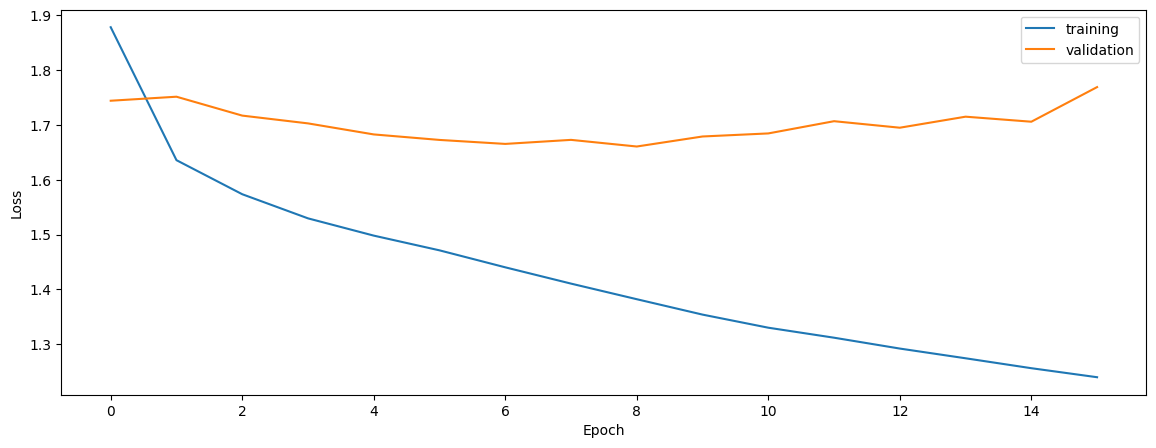

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.47920123915925783
0.3766410247575074
0.3562715284784802


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.48581641189444064
0.4418163726333907
0.43929147942934427


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.48547841141055786
0.4411926504565959
0.4467500473754027


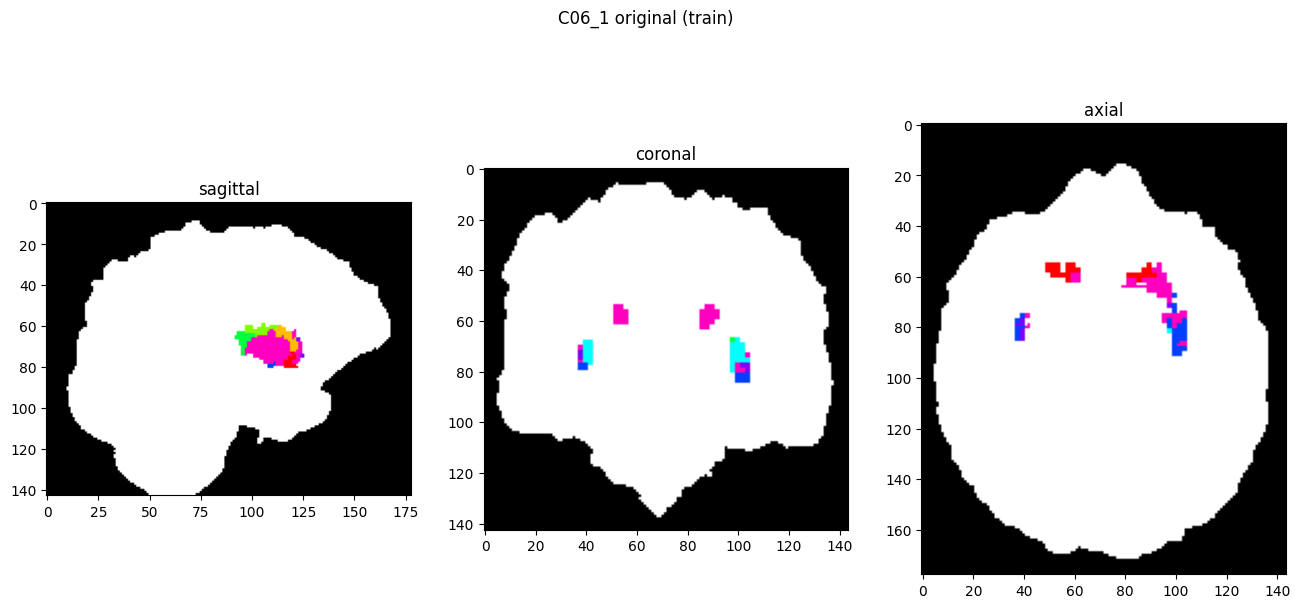

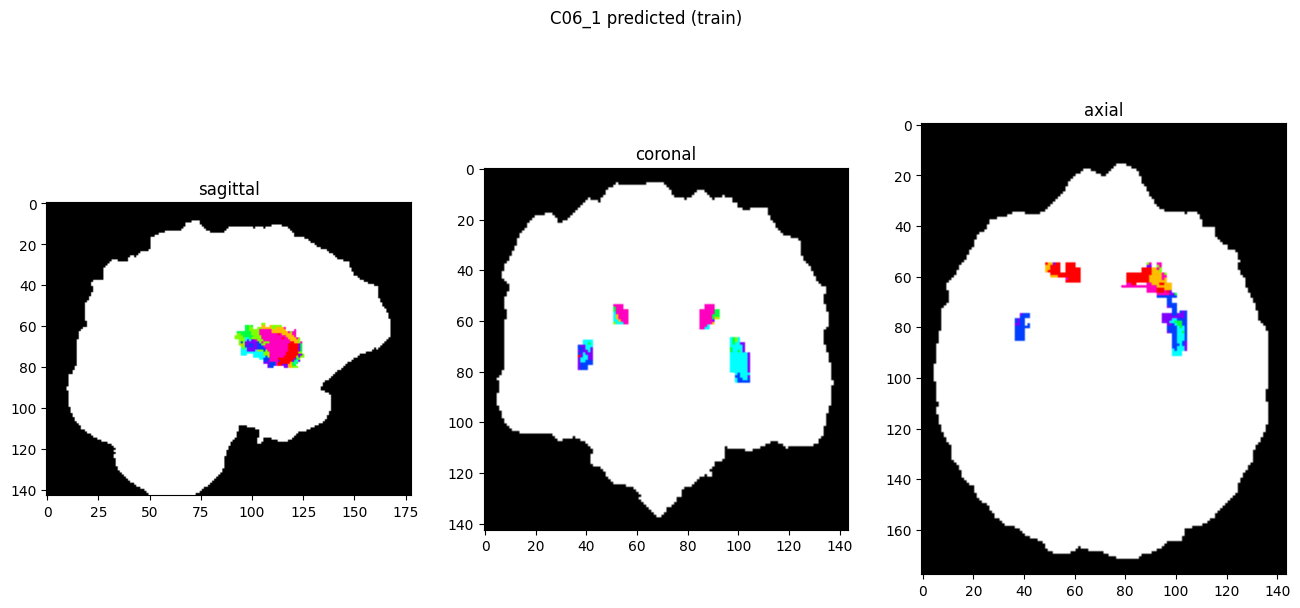

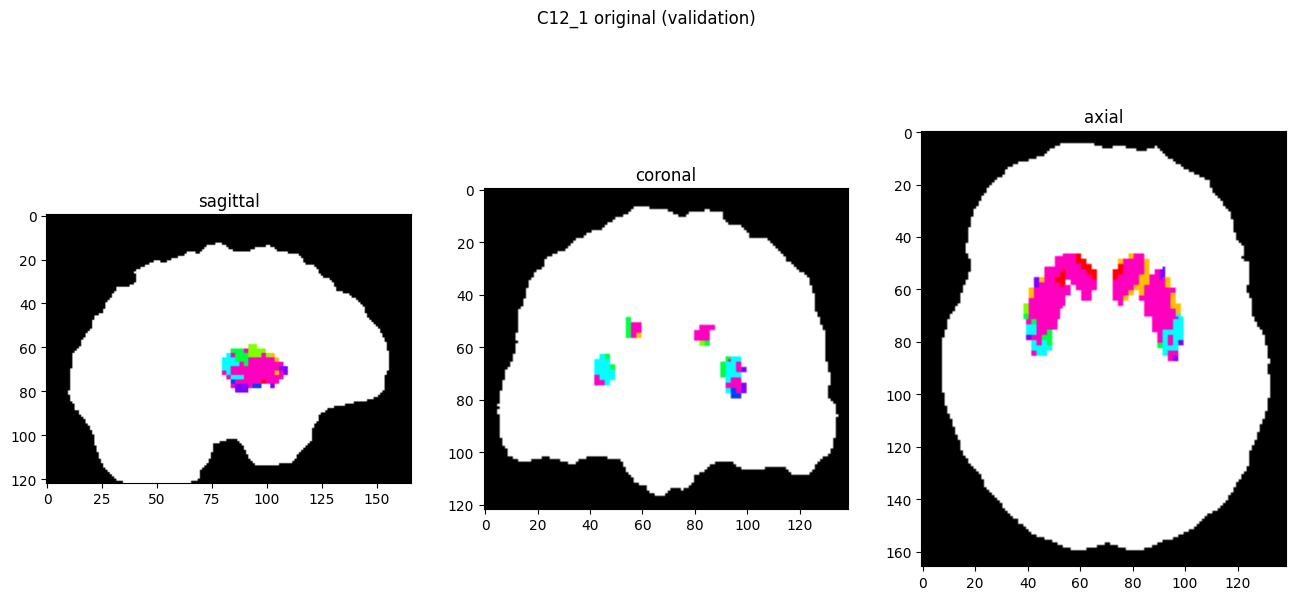

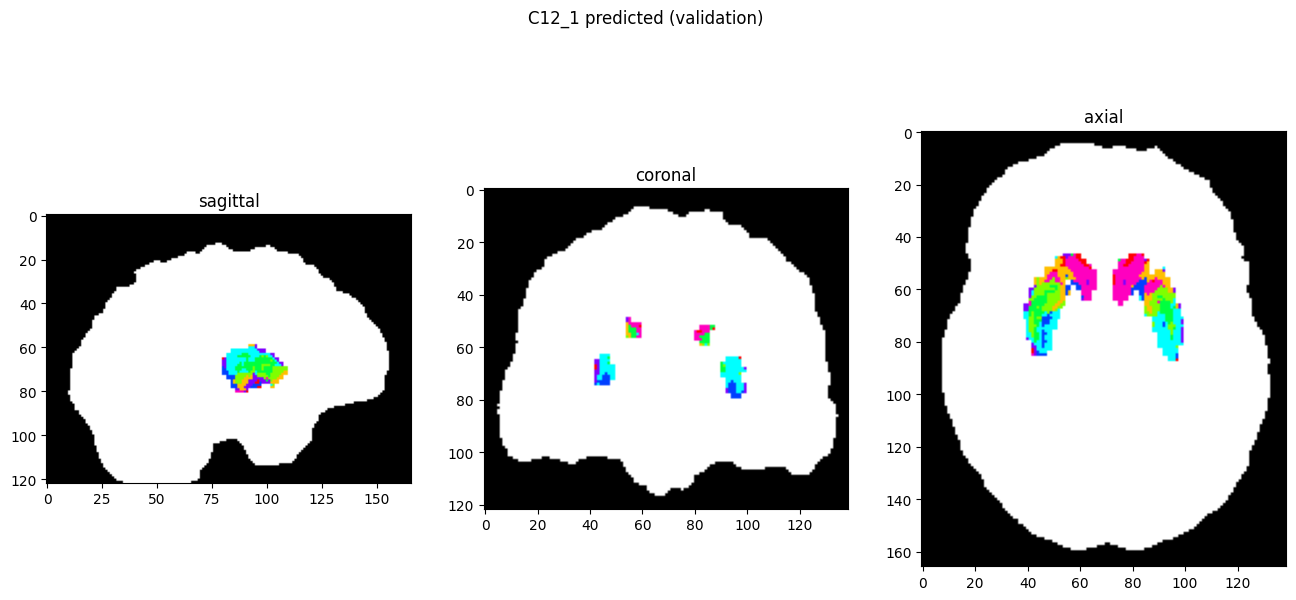

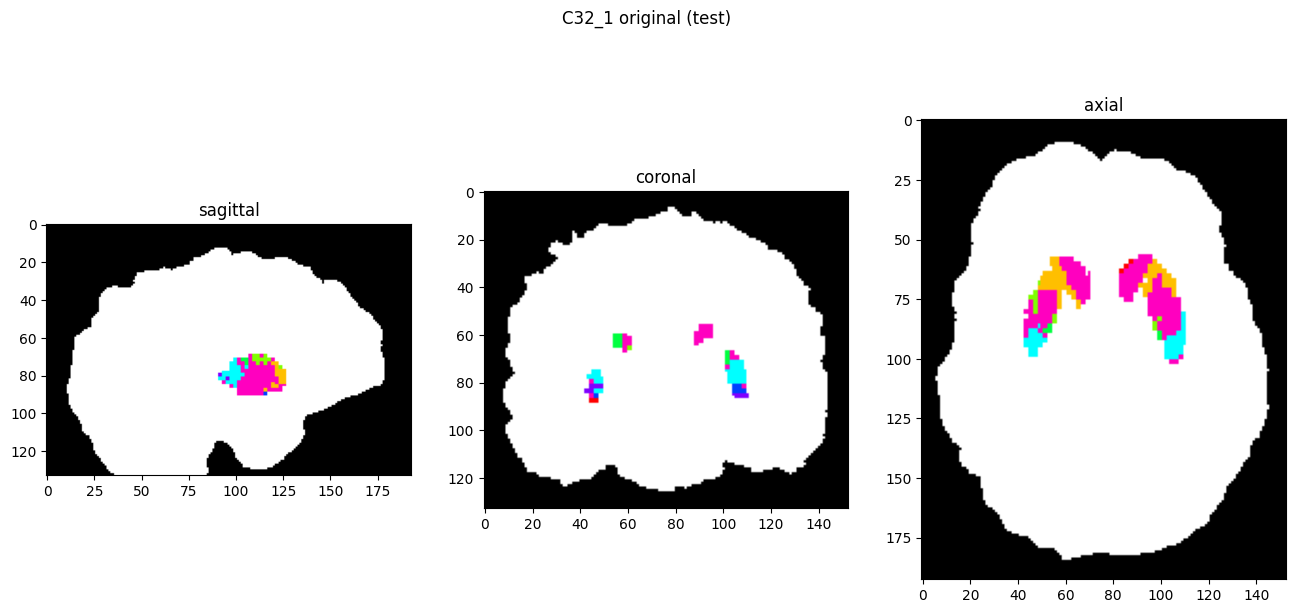

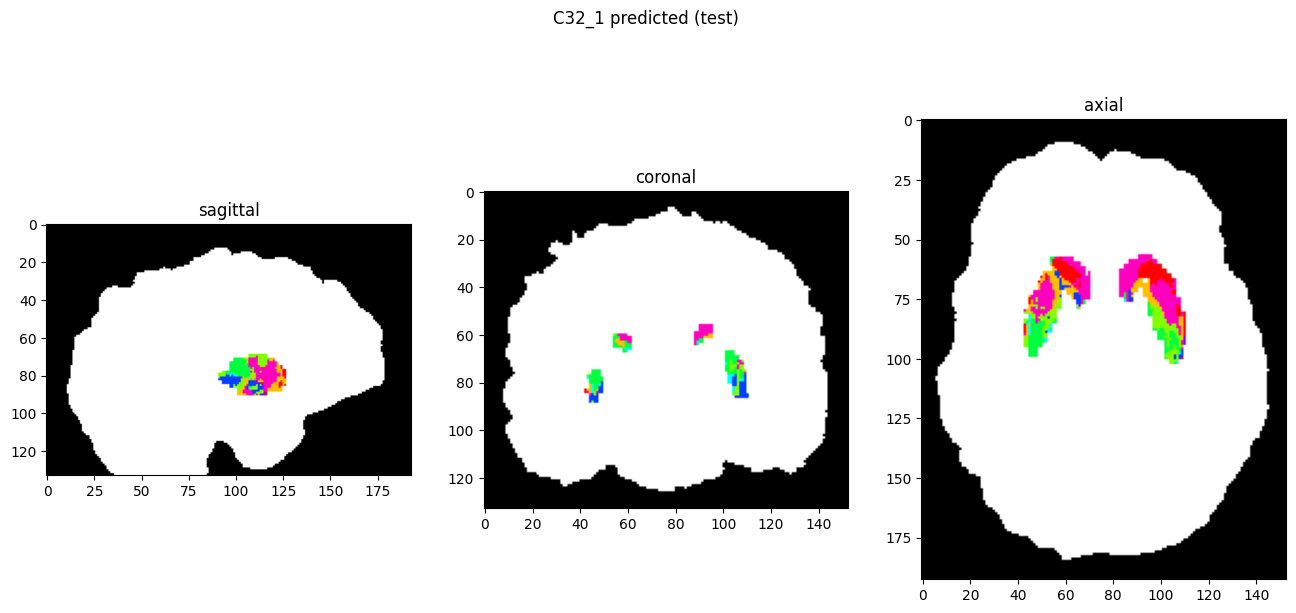

In [10]:
showResults(model, gen, threshold=0)